In [1]:
if "run_once" not in get_ipython().user_ns:
    %cd ..
    %cd ..
    %cd ..
    get_ipython().user_ns["run_once"] = True

/home/chamara/Documents/projects/1-poisoning-xai/notebooks/decentralised FL
/home/chamara/Documents/projects/1-poisoning-xai/notebooks
/home/chamara/Documents/projects/1-poisoning-xai


In [2]:
import flwr as fl
import torch
import ray
%matplotlib inline
import importlib

from src.NN import NNUtil
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# import sys
# sys.path.append('../src')
from src.FLProcess.CustomFedAvg import CustomFedAvg
from src.FLProcess.FLUtil import weighted_average
from src.FLProcess.FlowerClient import FlowerClient
from src.NN.NNConfig import get_nn
from src.dataset import dataLoaderFactory
from src.dataset.datasetStrategy import poison_strategy_with_non_iid_split, poison_strategy_for_multi_label_split
from src.poisonDetection.clientAnalysis.strategyFnGeneralAlg import client_analysis_fn_general_alg
from src.poisonDetection.clientAnalysis.strategyFnDebugging import client_analysis_strategy_fn_debugging
from src.poisonDetection.clientAnalysis.strategyFnRandomPoison import client_analysis_strategy_fn_random_poison
# from util.constants import NUM_CLIENTS
from util import constants
from src.NN import NNUtil
import numpy as np
from copy import deepcopy
# Import necessary captum tools
from captum.attr import LayerAttribution

import time
# importlib.reload(dataLoaderFactory) # for library code modifications
# importlib.reload(constants) 
# importlib.reload(NNUtil) 

from omnixai.data.image import Image
from omnixai.explainers.vision import CounterfactualExplainer
import torchvision
import torchvision.transforms as transforms

2025-04-13 10:45:48.102680: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-13 10:45:48.173946: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-13 10:45:49.526803: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
from src.FLProcess.FLUtil import get_mdl_from_weights, get_pred_from_models, get_mdl_of_client_at_round
from src.dataset.datasetHandler import get_testloader
import shap
from src.poisonDetection.clusteringHDBSCAN import run_hdbscan_clustering_algorithm
from src.poisonDetection.tsneVisualisation import get_tsne_data_from_input_features, visualise_tsne_clusters_with_idx, \
    visualise_clusters_with_tsne
from src.poisonDetection.clientAnalysis.strategyFnGeneralAlg import general_algorithm_main_calc
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import gray2rgb, rgb2gray, label2rgb # since the code wants color images
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm

In [4]:
from captum.attr import LayerLRP
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from captum.attr import LayerLRP
import matplotlib.pyplot as plt
import numpy as np

In [5]:
# import torch
# torch.cuda.is_available()

In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
def set_constants(num_clients=10, selected_dataset='MNIST'):
    constants.NUM_CLIENTS = num_clients
    constants.SELECTED_DATASET = selected_dataset

In [8]:
set_constants(num_clients=10, selected_dataset='FMNIST')

In [9]:
num_poison = 1

In [10]:
kwargs_train = {'poison_type': 'target_poison', 'poison_ratio': 1, 'target_label': 9, 'target_clients': [i for i in range(num_poison)]}
# kwargs_train = {'poison_type': 'random_poison', 'poison_ratio': 1, 'target_clients': [1,2,3]}
kwargs_val = {'poison_type': 'random_poison', 'poison_ratio': 0, 'target_clients': []}
trainloaders, valloaders, testloaders = dataLoaderFactory.generate_data_loaders(kwargs_train, kwargs_val,
                          strategy=poison_strategy_with_non_iid_split,
                          len_train_data=10000, len_test_data=1000,
                          random_ratio=1, is_visualize=False,
                          visualize_idx=0)

10000
generating train set
processing client:  0
performing targeted poisoning of labels
processing client:  1
no poisoning for client:  1
processing client:  2
no poisoning for client:  2
processing client:  3
no poisoning for client:  3
processing client:  4
no poisoning for client:  4
processing client:  5
no poisoning for client:  5
processing client:  6
no poisoning for client:  6
processing client:  7
no poisoning for client:  7
processing client:  8
no poisoning for client:  8
processing client:  9
no poisoning for client:  9
generating validation set
processing client:  0
no poisoning for client:  0
processing client:  1
no poisoning for client:  1
processing client:  2
no poisoning for client:  2
processing client:  3
no poisoning for client:  3
processing client:  4
no poisoning for client:  4
processing client:  5
no poisoning for client:  5
processing client:  6
no poisoning for client:  6
processing client:  7
no poisoning for client:  7
processing client:  8
no poisoning 

In [11]:
from src.NN.MdlTraining import train, test
from src.NN.NNUtil import get_parameters, set_parameters
class FlowerClientDecen(fl.client.NumPyClient):
    def __init__(self, net, train_loader, val_loader, local_eps = 1):
        self.net = net
        self.trainloader = train_loader
        self.valloader = val_loader
        self.local_eps = local_eps

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        # train_multi_label(self.net, self.trainloader, epochs=1)
        train(self.net, self.trainloader, epochs=self.local_eps)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        # loss, accuracy = test_multi_label(self.net, self.valloader)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

In [12]:
def client_fn(cid) -> FlowerClientDecen:
    """Create a Flower client representing a single organization."""
    # Load model
    net = get_nn()
    net.to(constants.DEVICE)
    # trainloaders, valloaders, _ = get_train_val_test_loaders()
    # Note: each client gets a different trainloader/valloader, so each client
    # will train and evaluate on their own unique data
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]

    # Create a  single Flower client representing a single organization
    return FlowerClientDecen(net, trainloader, valloader, local_eps=5)

In [13]:
client_updates_list_nw = []
aggregated_updates_list = []
results = []
weight_results = []
eliminated_client_list = []
eliminated_client_ids = []
debug_info = []

# should update these value based on the dataset: total_labels_per_client, target_label
kwargs_poison = {'client_ids': ['0', '1', '2', '3', '4'],
                        'explainer_type': 'grad_exp', 'total_rounds': 1, 'sample_count_for_plot': 20,
                        'target_label': 1, 'is_pca': False, 'num_pca_features': 80,
                        'round_idx': 0, 'start_feature_idx': 0, 'total_labels_per_client': 2,
                        'min_cluster_size': 2, 'perplexity': 10,
                        'show_poison_detection_graphs': True, 'malicious_start_idx': 10, 'malicious_end_idx': 40, 'epsilon':0.0,
                        'debug_info': debug_info,'is_eliminating_clients':False}

# kwargs_poison_NSL_KDD = {'client_ids': ['0', '1', '2', '3', '4'],
#                         'explainer_type': 'grad_exp', 'total_rounds': 1, 'sample_count_for_plot': 3,
#                         'target_label': 1, 'is_pca': False, 'num_pca_features': 80,
#                         'round_idx': 0, 'start_feature_idx': 0, 'total_labels_per_client': 2,
#                         'min_cluster_size': 2, 'perplexity': 19,
#                         'show_poison_detection_graphs': False, 'malicious_start_idx': 2, 'malicious_end_idx': 8,
#                         'debug_info': debug_info,'is_eliminating_clients':True}

strategy = CustomFedAvg(
    fraction_fit=1.0,
    evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
    client_updates_list=client_updates_list_nw,
    aggregated_updates_list=aggregated_updates_list,
    results_all=results,
    # client_analysis_strategy_fn=client_analysis_fn_general_alg,
    strategy_kwargs=kwargs_poison,
    eliminated_client_list=eliminated_client_list,
    eliminated_client_ids=eliminated_client_ids,
    weight_results=weight_results
)

client_resources = None
if constants.DEVICE == "cuda":
    # 10 client can run concurrently on a single GPU, but only if you have 10 CPU threads. 
    client_resources = {"num_cpus": 1, "num_gpus": 0.2}

# Start simulation
sim = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=constants.NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=10),
    strategy=strategy,
    client_resources=client_resources,
    ray_init_args={"log_to_driver": False, "num_cpus": 10, "num_gpus": 1}
)

INFO flwr 2025-04-13 10:47:21,817 | app.py:175 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
04/13/2025 10:47:21:INFO:Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
2025-04-13 10:47:24,879	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
INFO flwr 2025-04-13 10:47:25,977 | app.py:210 | Flower VCE: Ray initialized with resources: {'object_store_memory': 26145305395.0, 'GPU': 1.0, 'CPU': 10.0, 'node:193.1.133.164': 1.0, 'node:__internal_head__': 1.0, 'memory': 52290610791.0}
04/13/2025 10:47:25:INFO:Flower VCE: Ray initialized with resources: {'object_store_memory': 26145305395.0, 'GPU': 1.0, 'CPU': 10.0, 'node:193.1.133.164': 1.0, 'node:__internal_head__': 1.0, 'memory': 52290610791.0}
INFO flwr 2025-04-13 10:47:25,980 | app.py:224 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.2}
04/13/2025 10:47:25:INFO:Flower VCE: Resources for 

Attempting to initialize parameters


INFO flwr 2025-04-13 10:47:34,390 | server.py:280 | Received initial parameters from one random client
04/13/2025 10:47:34:INFO:Received initial parameters from one random client
INFO flwr 2025-04-13 10:47:34,392 | server.py:91 | Evaluating initial parameters
04/13/2025 10:47:34:INFO:Evaluating initial parameters
INFO flwr 2025-04-13 10:47:34,394 | server.py:104 | FL starting
04/13/2025 10:47:34:INFO:FL starting
DEBUG flwr 2025-04-13 10:47:34,396 | server.py:222 | fit_round 1: strategy sampled 10 clients (out of 10)
04/13/2025 10:47:34:DEBUG:fit_round 1: strategy sampled 10 clients (out of 10)
DEBUG flwr 2025-04-13 10:47:49,328 | server.py:236 | fit_round 1 received 10 results and 0 failures
04/13/2025 10:47:49:DEBUG:fit_round 1 received 10 results and 0 failures
WARNING flwr 2025-04-13 10:47:49,487 | CustomFedAvg.py:147 | No fit_metrics_aggregation_fn provided
04/13/2025 10:47:49:WARNING:No fit_metrics_aggregation_fn provided
DEBUG flwr 2025-04-13 10:47:49,490 | server.py:173 | evalua

No fit_metrics_aggregation_fn provided
Time taken: 0.1591024398803711 seconds


DEBUG flwr 2025-04-13 10:47:52,216 | server.py:187 | evaluate_round 1 received 10 results and 0 failures
04/13/2025 10:47:52:DEBUG:evaluate_round 1 received 10 results and 0 failures
DEBUG flwr 2025-04-13 10:47:52,219 | server.py:222 | fit_round 2: strategy sampled 10 clients (out of 10)
04/13/2025 10:47:52:DEBUG:fit_round 2: strategy sampled 10 clients (out of 10)
DEBUG flwr 2025-04-13 10:48:00,270 | server.py:236 | fit_round 2 received 10 results and 0 failures
04/13/2025 10:48:00:DEBUG:fit_round 2 received 10 results and 0 failures
DEBUG flwr 2025-04-13 10:48:00,399 | server.py:173 | evaluate_round 2: strategy sampled 10 clients (out of 10)
04/13/2025 10:48:00:DEBUG:evaluate_round 2: strategy sampled 10 clients (out of 10)


Time taken: 0.12672185897827148 seconds


DEBUG flwr 2025-04-13 10:48:03,255 | server.py:187 | evaluate_round 2 received 10 results and 0 failures
04/13/2025 10:48:03:DEBUG:evaluate_round 2 received 10 results and 0 failures
DEBUG flwr 2025-04-13 10:48:03,257 | server.py:222 | fit_round 3: strategy sampled 10 clients (out of 10)
04/13/2025 10:48:03:DEBUG:fit_round 3: strategy sampled 10 clients (out of 10)
DEBUG flwr 2025-04-13 10:48:11,174 | server.py:236 | fit_round 3 received 10 results and 0 failures
04/13/2025 10:48:11:DEBUG:fit_round 3 received 10 results and 0 failures
DEBUG flwr 2025-04-13 10:48:11,309 | server.py:173 | evaluate_round 3: strategy sampled 10 clients (out of 10)
04/13/2025 10:48:11:DEBUG:evaluate_round 3: strategy sampled 10 clients (out of 10)


Time taken: 0.13188433647155762 seconds


DEBUG flwr 2025-04-13 10:48:13,882 | server.py:187 | evaluate_round 3 received 10 results and 0 failures
04/13/2025 10:48:13:DEBUG:evaluate_round 3 received 10 results and 0 failures
DEBUG flwr 2025-04-13 10:48:13,885 | server.py:222 | fit_round 4: strategy sampled 10 clients (out of 10)
04/13/2025 10:48:13:DEBUG:fit_round 4: strategy sampled 10 clients (out of 10)
DEBUG flwr 2025-04-13 10:48:21,326 | server.py:236 | fit_round 4 received 10 results and 0 failures
04/13/2025 10:48:21:DEBUG:fit_round 4 received 10 results and 0 failures
DEBUG flwr 2025-04-13 10:48:21,472 | server.py:173 | evaluate_round 4: strategy sampled 10 clients (out of 10)
04/13/2025 10:48:21:DEBUG:evaluate_round 4: strategy sampled 10 clients (out of 10)


Time taken: 0.14393925666809082 seconds


DEBUG flwr 2025-04-13 10:48:24,157 | server.py:187 | evaluate_round 4 received 10 results and 0 failures
04/13/2025 10:48:24:DEBUG:evaluate_round 4 received 10 results and 0 failures
DEBUG flwr 2025-04-13 10:48:24,160 | server.py:222 | fit_round 5: strategy sampled 10 clients (out of 10)
04/13/2025 10:48:24:DEBUG:fit_round 5: strategy sampled 10 clients (out of 10)
DEBUG flwr 2025-04-13 10:48:32,231 | server.py:236 | fit_round 5 received 10 results and 0 failures
04/13/2025 10:48:32:DEBUG:fit_round 5 received 10 results and 0 failures
DEBUG flwr 2025-04-13 10:48:32,362 | server.py:173 | evaluate_round 5: strategy sampled 10 clients (out of 10)
04/13/2025 10:48:32:DEBUG:evaluate_round 5: strategy sampled 10 clients (out of 10)


Time taken: 0.1282811164855957 seconds


DEBUG flwr 2025-04-13 10:48:35,287 | server.py:187 | evaluate_round 5 received 10 results and 0 failures
04/13/2025 10:48:35:DEBUG:evaluate_round 5 received 10 results and 0 failures
DEBUG flwr 2025-04-13 10:48:35,289 | server.py:222 | fit_round 6: strategy sampled 10 clients (out of 10)
04/13/2025 10:48:35:DEBUG:fit_round 6: strategy sampled 10 clients (out of 10)
DEBUG flwr 2025-04-13 10:48:43,130 | server.py:236 | fit_round 6 received 10 results and 0 failures
04/13/2025 10:48:43:DEBUG:fit_round 6 received 10 results and 0 failures
DEBUG flwr 2025-04-13 10:48:43,273 | server.py:173 | evaluate_round 6: strategy sampled 10 clients (out of 10)
04/13/2025 10:48:43:DEBUG:evaluate_round 6: strategy sampled 10 clients (out of 10)


Time taken: 0.1405959129333496 seconds


DEBUG flwr 2025-04-13 10:48:45,786 | server.py:187 | evaluate_round 6 received 10 results and 0 failures
04/13/2025 10:48:45:DEBUG:evaluate_round 6 received 10 results and 0 failures
DEBUG flwr 2025-04-13 10:48:45,789 | server.py:222 | fit_round 7: strategy sampled 10 clients (out of 10)
04/13/2025 10:48:45:DEBUG:fit_round 7: strategy sampled 10 clients (out of 10)
DEBUG flwr 2025-04-13 10:48:53,656 | server.py:236 | fit_round 7 received 10 results and 0 failures
04/13/2025 10:48:53:DEBUG:fit_round 7 received 10 results and 0 failures
DEBUG flwr 2025-04-13 10:48:53,794 | server.py:173 | evaluate_round 7: strategy sampled 10 clients (out of 10)
04/13/2025 10:48:53:DEBUG:evaluate_round 7: strategy sampled 10 clients (out of 10)


Time taken: 0.13619351387023926 seconds


DEBUG flwr 2025-04-13 10:48:56,431 | server.py:187 | evaluate_round 7 received 10 results and 0 failures
04/13/2025 10:48:56:DEBUG:evaluate_round 7 received 10 results and 0 failures
DEBUG flwr 2025-04-13 10:48:56,434 | server.py:222 | fit_round 8: strategy sampled 10 clients (out of 10)
04/13/2025 10:48:56:DEBUG:fit_round 8: strategy sampled 10 clients (out of 10)
DEBUG flwr 2025-04-13 10:49:03,987 | server.py:236 | fit_round 8 received 10 results and 0 failures
04/13/2025 10:49:03:DEBUG:fit_round 8 received 10 results and 0 failures
DEBUG flwr 2025-04-13 10:49:04,126 | server.py:173 | evaluate_round 8: strategy sampled 10 clients (out of 10)
04/13/2025 10:49:04:DEBUG:evaluate_round 8: strategy sampled 10 clients (out of 10)


Time taken: 0.1357433795928955 seconds


DEBUG flwr 2025-04-13 10:49:06,810 | server.py:187 | evaluate_round 8 received 10 results and 0 failures
04/13/2025 10:49:06:DEBUG:evaluate_round 8 received 10 results and 0 failures
DEBUG flwr 2025-04-13 10:49:06,813 | server.py:222 | fit_round 9: strategy sampled 10 clients (out of 10)
04/13/2025 10:49:06:DEBUG:fit_round 9: strategy sampled 10 clients (out of 10)
DEBUG flwr 2025-04-13 10:49:14,213 | server.py:236 | fit_round 9 received 10 results and 0 failures
04/13/2025 10:49:14:DEBUG:fit_round 9 received 10 results and 0 failures
DEBUG flwr 2025-04-13 10:49:14,359 | server.py:173 | evaluate_round 9: strategy sampled 10 clients (out of 10)
04/13/2025 10:49:14:DEBUG:evaluate_round 9: strategy sampled 10 clients (out of 10)


Time taken: 0.14278578758239746 seconds


DEBUG flwr 2025-04-13 10:49:17,015 | server.py:187 | evaluate_round 9 received 10 results and 0 failures
04/13/2025 10:49:17:DEBUG:evaluate_round 9 received 10 results and 0 failures
DEBUG flwr 2025-04-13 10:49:17,017 | server.py:222 | fit_round 10: strategy sampled 10 clients (out of 10)
04/13/2025 10:49:17:DEBUG:fit_round 10: strategy sampled 10 clients (out of 10)
DEBUG flwr 2025-04-13 10:49:24,586 | server.py:236 | fit_round 10 received 10 results and 0 failures
04/13/2025 10:49:24:DEBUG:fit_round 10 received 10 results and 0 failures
DEBUG flwr 2025-04-13 10:49:24,720 | server.py:173 | evaluate_round 10: strategy sampled 10 clients (out of 10)
04/13/2025 10:49:24:DEBUG:evaluate_round 10: strategy sampled 10 clients (out of 10)


Time taken: 0.13167691230773926 seconds


DEBUG flwr 2025-04-13 10:49:27,364 | server.py:187 | evaluate_round 10 received 10 results and 0 failures
04/13/2025 10:49:27:DEBUG:evaluate_round 10 received 10 results and 0 failures
INFO flwr 2025-04-13 10:49:27,367 | server.py:153 | FL finished in 112.97113961726427
04/13/2025 10:49:27:INFO:FL finished in 112.97113961726427
INFO flwr 2025-04-13 10:49:27,370 | app.py:225 | app_fit: losses_distributed [(1, 0.03466272288560868), (2, 0.02551678967475891), (3, 0.025966214448213582), (4, 0.022725028708577157), (5, 0.02349714714288712), (6, 0.020693060338497164), (7, 0.020463630557060245), (8, 0.020411208018660545), (9, 0.01888869121670723), (10, 0.01881181594729423)]
04/13/2025 10:49:27:INFO:app_fit: losses_distributed [(1, 0.03466272288560868), (2, 0.02551678967475891), (3, 0.025966214448213582), (4, 0.022725028708577157), (5, 0.02349714714288712), (6, 0.020693060338497164), (7, 0.020463630557060245), (8, 0.020411208018660545), (9, 0.01888869121670723), (10, 0.01881181594729423)]
INFO f

In [14]:
# Shutdown Ray after the simulation completes
ray.shutdown()

## LRP-based poisoning attacks

In [15]:
def prepare_mdl(itr, mdl_id_str):
    sample_mdl_weights = client_updates_list_nw[itr][mdl_id_str][0]
    sample_mdl = get_mdl_from_weights(sample_mdl_weights)
    sample_mdl.to(constants.DEVICE)
    return sample_mdl

def get_fixed_sample_data(sample_id):
    test_data = torchvision.datasets.MNIST(constants.DATASET_ROOT + "/dataset", train=False, download=True)
    test_data.data = test_data.data.numpy()
    x_test, y_test = Image(test_data.data, batched=True), test_data.targets
    original_sample = x_test[sample_id]
    original_label = y_test[sample_id]
    return original_sample, original_label

### Perturbations generation

In [16]:
# Step 4: Targeted FGSM Attack
def targeted_fgsm_attack(model, data, target_class, epsilon):
    # Set requires_grad to True to compute gradients
    data.requires_grad = True

    # Forward pass
    output = model(data)
    loss = criterion(output, target_class)
    model.zero_grad()

    # Backward pass (to get gradients)
    loss.backward()

    # Collect the sign of the gradients
    data_grad = data.grad.data
    sign_data_grad = data_grad.sign()

    # Create the perturbed image by adjusting the input data
    perturbed_data = data - epsilon * sign_data_grad
    perturbed_data = torch.clamp(perturbed_data, 0, 1)

    return perturbed_data

# Step 5: Targeted PGD Attack
def targeted_pgd_attack(model, data, target_class, epsilon, alpha, iterations):
    perturbed_data = data.clone().detach().requires_grad_(True)

    for _ in range(iterations):
        # Forward pass
        output = model(perturbed_data)
        loss = criterion(output, target_class)
        model.zero_grad()

        # Backward pass
        loss.backward()

        # Update perturbed data using the sign of the gradient
        perturbed_data = perturbed_data - alpha * perturbed_data.grad.sign()

        # Clip the perturbation to keep it within the epsilon-ball
        perturbed_data = torch.clamp(perturbed_data, data - epsilon, data + epsilon)
        perturbed_data = torch.clamp(perturbed_data, 0, 1)
        perturbed_data = perturbed_data.detach().requires_grad_(True)

    return perturbed_data

def carlini_wagner_attack(model, data, target_class, c=1e-4, lr=0.01, max_iter=1000):
    perturbed_data = data.clone().detach().requires_grad_(True)
    optimizer = optim.Adam([perturbed_data], lr=lr)

    for _ in range(max_iter):
        optimizer.zero_grad()

        # Forward pass through the model
        output = model(perturbed_data)
        loss = F.cross_entropy(output, target_class)

        # Add regularization term to minimize perturbation
        perturbation = torch.norm(perturbed_data - data)
        loss += c * perturbation

        # Backward pass and update the perturbed image
        loss.backward()
        optimizer.step()

        # Clamp values to ensure valid pixel ranges
        perturbed_data.data = torch.clamp(perturbed_data.data, 0, 1)

    return perturbed_data

def counterfactuals_attack(model, data):
    
    explainer_b = CounterfactualExplainer(
    model=cli_0_mdl,
    preprocess_function=preprocess
    )
    # explanations_b = explainer_b.explain(x_test[0:5])
    explanations_b = explainer_b.explain(data)
    explanations_b.ipython_plot(index=0)
    cfs = (explanations_b.explanations[0]['cf'])
    return cfs

# Step 6: Test Targeted Adversarial Attack on MNIST Test Image
def test_adversarial_attack(model, data, target_class, epsilon=0.3, alpha=0.01, iterations=40, c=1e-4, lr=0.01, attack_type='fgsm'):
    # Set the model in evaluation mode
    model.eval()

    # Get the original prediction
    original_output = model(data)
    original_pred = original_output.max(1, keepdim=True)[1]
    print(f"Original Prediction: {original_pred.item()}")

    # Choose attack type
    if attack_type == 'counterfactuals':
        print('please note counterfactuals do not provide a target class, it uses only a given optimal class!')
        perturbed_data = counterfactuals_attack(model, data)
    elif attack_type == 'fgsm':
        perturbed_data = targeted_fgsm_attack(model, data, target_class, epsilon)
    elif attack_type == 'pgd':
        perturbed_data = targeted_pgd_attack(model, data, target_class, epsilon, alpha, iterations)
    elif attack_type == 'cw':
        perturbed_data = carlini_wagner_attack(model, data, target_class, c=c, lr=lr, max_iter=iterations)

    # Get the prediction for the perturbed image
    output = model(perturbed_data)
    final_pred = output.max(1, keepdim=True)[1]
    print(f"Targeted Attack Prediction: {final_pred.item()}")
    
    return perturbed_data

# Helper function to visualize original, perturbed, and perturbation
def visualize_attack(original_data, perturbed_data):
    # Convert tensors to numpy arrays for visualization
    original_data_np = original_data.squeeze().cpu().detach().numpy()
    perturbed_data_np = perturbed_data.squeeze().cpu().detach().numpy()
    perturbation = perturbed_data_np - original_data_np  # Calculate the perturbation

    # Plot the original, perturbed, and perturbation images
    fig, ax = plt.subplots(1, 3, figsize=(10, 3))

    # Original image
    ax[0].imshow(original_data_np, cmap="gray")
    ax[0].set_title("Original Image")
    ax[0].axis("off")

    # Perturbed image
    ax[1].imshow(perturbed_data_np, cmap="gray")
    ax[1].set_title("Perturbed Image")
    ax[1].axis("off")

    # Perturbation (difference)
    ax[2].imshow(perturbation, cmap="gray")
    ax[2].set_title("Perturbation")
    ax[2].axis("off")

    plt.show()

### Performing experiments

In [17]:
selected_instance = 5
target_mdl_and_db_id = 3 #trainloaders are also having the corresponding model id
required_lrp_test_dataset_samples=20

target_mdl = prepare_mdl(itr=2, mdl_id_str=str(target_mdl_and_db_id))
target_data = trainloaders[target_mdl_and_db_id].dataset[selected_instance][0].detach().view(1, 1, 28, 28).to(constants.DEVICE)
original_label = trainloaders[target_mdl_and_db_id].dataset[selected_instance][1]
# sample_data, original_label = get_fixed_sample_data(sample_id=selected_instance)
# ori_img = torch.tensor(sample_data).unsqueeze(0).unsqueeze(0).to(constants.DEVICE)

##### Evaluate the output from the target model on the sample data

In [19]:
output = target_mdl(target_data)
predicted_class = torch.argmax(output, dim=1)
print('pred: ', predicted_class.item())
print('original: ', original_label)

pred:  3
original:  3


##### Run the adversarial test

In [20]:
target_poison_class = 6
perturbed_data = test_adversarial_attack(target_mdl, target_data, torch.tensor([target_poison_class]).to(constants.DEVICE), 
                                            c=1e-4, lr=0.01, iterations=1000, attack_type='cw')
# criterion = nn.CrossEntropyLoss()
# perturbed_data_fgsm = test_adversarial_attack(cli_0_mdl, sample_data_t, target_class, attack_type='fgsm')
# perturbed_data_pgd = test_adversarial_attack(cli_0_mdl, sample_data_t, target_class, epsilon=0.3, alpha=0.01, iterations=1000, attack_type='pgd')

Original Prediction: 3
Targeted Attack Prediction: 6


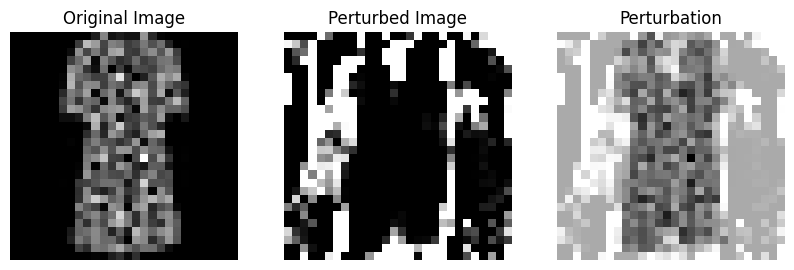

In [22]:
visualize_attack(target_data, perturbed_data)

In [23]:
# ori_img = sample_data_t
# cfs_img = perturbed_data_cw
# cli_0_mdl = cli_0_mdl.to(constants.DEVICE)
# label = original_label

In [24]:
output  = target_mdl(perturbed_data)
predicted_class = torch.argmax(output, dim=1)
print('pred: ', predicted_class.item())

pred:  6


### Try using LayerLRP from captum

In [25]:
def derive_lrp_values(image, mdl, label):
    layer_lrp_all = []
    layer_names = []
    for name, layer in mdl.named_modules():
        # layer_lrp = LayerLRP(cli_0_mdl, layer)
        # layer_lrp_all.append(layer_lrp)
        if not name or isinstance(layer, nn.Dropout):
            continue
            
        layer = getattr(mdl, name)
        layer_names.append(name)
        layer_lrp_fc1 = LayerLRP(mdl, layer)
    
        # Compute the relevance score for the selected image and target label (for this example, using the ground truth label)
        # target_label = labels[0].item()
        attributions_fc1 = layer_lrp_fc1.attribute(image, target=label)
        # Convert attributions to numpy for visualization
        attributions_fc1_np = attributions_fc1.cpu().detach().numpy().squeeze()
        layer_lrp_all.append(attributions_fc1_np)
        # attributions_fc2_np = attributions_fc2.detach().numpy().squeeze()
    return layer_lrp_all,layer_names


In [26]:
def run_layer_lrp_for_client_mdl(target_mdl, ori_data, perturbed_data, original_label, target_layer_id):
    layer_lrp_all_ori,layer_names = derive_lrp_values(image=ori_data, mdl=target_mdl, label=original_label)
    layer_lrp_all_cfs,layer_names = derive_lrp_values(image=perturbed_data, mdl=target_mdl, label=original_label)
    impact_layer_nn = layer_lrp_all_cfs[target_layer_id]-layer_lrp_all_ori[target_layer_id]
    target_layer_name = layer_names[target_layer_id]
    return layer_lrp_all_ori, layer_lrp_all_cfs, impact_layer_nn, layer_names, target_layer_name

In [27]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_fc_layer_attributions(attributions_np, highlight_indices=None, save_path=None):
    plt.figure(figsize=(4, 2.5), dpi=200)  # compact aspect ratio

    bar_color_default = '#1f77b4'  # blue
    bar_color_highlight = 'red'
    bar_width = 0.8

    # Ensure highlight_indices is a set of ints for fast lookup and to avoid type errors
    highlight_indices = set(highlight_indices) if highlight_indices is not None else set()

    # Assign colors based on whether the index is highlighted
    colors = [
        bar_color_highlight if i in highlight_indices else bar_color_default
        for i in range(len(attributions_np))
    ]

    plt.bar(range(len(attributions_np)), attributions_np, width=bar_width, color=colors)

    # Axis labels and ticks
    plt.xlabel('Neuron Index', fontsize=10)
    plt.ylabel('Relevance Score', fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    # Grid for readability
    plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)

    plt.tight_layout()

    # Optionally save
    # if save_path:
    #     plt.savefig(save_path, format='png', dpi=300, bbox_inches='tight')

    plt.show()


In [28]:
# layer_lrp_all_ori, layer_lrp_all_cfs, layer_lrp_diff, layer_names, target_layer_name = run_layer_lrp_for_client_mdl(target_mdl, target_data, perturbed_data, original_label, 
#                                                                                      target_layer_id=-2)

In [29]:
# visualize_fc_layer_attributions(layer_lrp_diff, 'layer difference')
# visualize_fc_layer_attributions(layer_lrp_all_cfs[-2], 'cf')
# visualize_fc_layer_attributions(layer_lrp_all_ori[-2], 'ori')

#### Attack Process

In [30]:
def run_attack(target_mdl, target_layer, target_layer_name, max_neurons_to_perturb=5, perturb_amount=1):
    # Filter positive values and get their indices
    all_indices_sign = np.where(target_layer< 0)[0]
    
    # Get the top 3 positive values by sorting the indices of the positive values
    # top_impact_idxes = all_indices_sign[np.argsort(target_layer[all_indices_sign])[-3:]]
    top_impact_idxes = all_indices_sign[np.argsort(target_layer[all_indices_sign])[:max_neurons_to_perturb]]
    
    # print(top_impact_idxes)
    target_mdl_poi = deepcopy(target_mdl)
    # name = layer_names[target_layer]
    layer = getattr(target_mdl_poi, target_layer_name)
    
    nn_weights = layer.weight.data
    top_impact_weights = nn_weights[top_impact_idxes,:]
    
    # nn_weights[top_impact_idxes,:]=torch.ones_like(top_impact_weights) * 0
    nn_weights[top_impact_idxes,:] = top_impact_weights + perturb_amount
    return target_mdl_poi

In [203]:
def compare_mdl_acc(dataloader, target_mdl, target_mdl_poi):
    loss, accuracy1, accuracy_per_class1 = test_by_class(target_mdl, dataloader)
    
    loss, accuracy2, accuracy_per_class2 = test_by_class(target_mdl_poi, dataloader)
    
    for i, (acc1, acc2) in enumerate(zip(accuracy_per_class1, accuracy_per_class2)):
        if acc1 == acc2:
            print(f"Class {i}: Acc1 = {acc1}, Both accuracies are equal.")
            
        else:
            print(f"Class {i}: Acc1 = {acc1}, Acc2 = {acc2}")
    return accuracy_per_class1, accuracy_per_class2, accuracy1, accuracy2


def test_by_class(net, testloader):
    """Evaluate the network on the entire test set and compute class-wise accuracy."""
    criterion = torch.nn.CrossEntropyLoss()
    net.eval()
    
    # Initialize overall loss, correct, and total counters
    correct, total, loss = 0, 0, 0.0
    
    # Number of classes (assuming 10 classes, i.e., 0-9)
    num_classes = 10
    
    # Initialize lists to track correct predictions and total samples per class
    correct_per_class = [0] * num_classes
    total_per_class = [0] * num_classes
    
    # Disable gradient calculations
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(constants.DEVICE), labels.to(constants.DEVICE)
            
            # Forward pass
            outputs = net(images)
            
            # Calculate loss
            loss += criterion(outputs, labels).item()
            
            # Get predictions (the index of the max log-probability)
            _, predicted = torch.max(outputs.data, 1)
            
            # Update overall correct and total counts
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Update class-wise correct and total counts
            for label, prediction in zip(labels, predicted):
                total_per_class[label] += 1
                if prediction == label:
                    correct_per_class[label] += 1
    
    # Calculate overall loss and accuracy
    loss /= len(testloader.dataset)
    accuracy = correct / total
    
    # Calculate class-wise accuracy
    accuracy_per_class = [correct_class / total_class if total_class > 0 else 0
                          for correct_class, total_class in zip(correct_per_class, total_per_class)]
    
    # Return overall loss, overall accuracy, and class-wise accuracy
    return loss, accuracy, accuracy_per_class


def plot_classwise_accuracy_comparison(num_classes, accuracy_per_class1, accuracy_per_class2, 
                                       labels=('Original', 'Poisoned')):
    bar_width = 0.35
    index = np.arange(num_classes)

    plt.figure(figsize=(10, 6))
    plt.bar(index, accuracy_per_class1, bar_width, label=labels[0], color='b', alpha=0.7)
    plt.bar(index + bar_width, accuracy_per_class2, bar_width, label=labels[1], color='r', alpha=0.7)

    plt.xlabel('Classes', fontsize=16)
    plt.ylabel('Accuracy', fontsize=16)
    plt.xticks(index + bar_width / 2, index, fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(fontsize=14)
    plt.tight_layout()
    plt.show()

def get_first_index_of_class(dataloader, target_class_label):
    dataset = dataloader.dataset
    idxes = []
    for idx in range(len(dataset)):
        _, label = dataset[idx]
        if label == target_class_label:
            idxes.append(idx)

    if len(idxes)==0:
        raise ValueError(f"Label {target_class_label} not found in the dataset.")
    return idxes



#### Run the atack

In [211]:
target_mdl_and_db_id = 8 #trainloaders are also having the corresponding model id
required_lrp_test_dataset_samples=20
target_nn_layer_id = -2

target_label = 9
target_poison_class = 1

selected_sample_data_index = get_first_index_of_class(trainloaders[target_mdl_and_db_id], target_label)[1]

target_mdl = prepare_mdl(itr=2, mdl_id_str=str(target_mdl_and_db_id))

target_data = trainloaders[target_mdl_and_db_id].dataset[selected_sample_data_index][0].detach().view(1, 1, 28, 28).to(constants.DEVICE)
original_label = trainloaders[target_mdl_and_db_id].dataset[selected_sample_data_index][1]

perturbed_data = test_adversarial_attack(target_mdl, target_data, torch.tensor([target_poison_class]).to(constants.DEVICE), 
                                            c=1e-4, lr=0.01, iterations=1000, attack_type='cw')
# sample_data, original_label = get_fixed_sample_data(sample_id=selected_instance)
# ori_img = torch.tensor(sample_data).unsqueeze(0).unsqueeze(0).to(constants.DEVICE)

Original Prediction: 9
Targeted Attack Prediction: 1


In [212]:
layer_lrp_all_ori, layer_lrp_all_cfs, layer_lrp_diff, layer_names, target_layer_name = run_layer_lrp_for_client_mdl(target_mdl, target_data, perturbed_data, original_label, 
                                                                                     target_layer_id=target_nn_layer_id)

In [213]:
# visualize_fc_layer_attributions(layer_lrp_diff)

In [214]:
def run_attack(target_mdl, target_layer, target_layer_name, max_neurons_to_perturb=5, perturb_amount=1):
    # Filter positive values and get their indices
    all_indices_sign = np.where(target_layer < 0)[0]
    # print(all_indices_sign)
    # Get the top 3 positive values by sorting the indices of the positive values
    # top_impact_idxes = all_indices_sign[np.argsort(target_layer[all_indices_sign])[-max_neurons_to_perturb:]]
    top_impact_idxes = all_indices_sign[np.argsort(target_layer[all_indices_sign])[:max_neurons_to_perturb]]
    
    # print(top_impact_idxes)
    target_mdl_poi = deepcopy(target_mdl)
    # name = layer_names[target_layer]
    layer = getattr(target_mdl_poi, target_layer_name)
    
    nn_weights = layer.weight.data
    top_impact_weights = nn_weights[top_impact_idxes,:]
    
    # nn_weights[top_impact_idxes,:]=torch.ones_like(top_impact_weights) * 0
    nn_weights[top_impact_idxes,:] = top_impact_weights + perturb_amount
    return target_mdl_poi, all_indices_sign, top_impact_idxes

It all depends on which target layer you are focusing on.

[1] If LRP scores targeting is from the original model and we apply a negative threshold to it, we will get less accuracy on the original class only.

[2] If LRP scores targeting is from the original model and we apply a positive threshold to it, we will get high accuracy on the original class only.

[3] If LRP scores from the perturbed data is used and we apply a positive threshold, we get high accuracy in the target class only.

In [215]:
# target_layer_imp=layer_lrp_all_cfs[-2]
target_layer_imp = layer_lrp_all_ori[-2]

In [268]:
# Scenario 1
target_layer_imp = layer_lrp_all_ori[-2]
target_mdl_poi, all_indices_sign, top_impact_idxes = run_attack(target_mdl, target_layer_imp, 
                                                                                target_layer_name, max_neurons_to_perturb=50, perturb_amount=-0.02)

# Scenario 2
# target_layer_imp = layer_lrp_all_ori[-2]
# target_mdl_poi, all_indices_sign, top_impact_idxes = run_attack(target_mdl, target_layer_imp, 
#                                                                                 target_layer_name, max_neurons_to_perturb=50, perturb_amount=0.02)

# # Scenario 3
# target_layer_imp = layer_lrp_all_cfs[-2]
# target_mdl_poi, all_indices_sign, top_impact_idxes = run_attack(target_mdl, target_layer_imp, 
#                                                                                 target_layer_name, max_neurons_to_perturb=50, perturb_amount=0.2)

In [269]:
len(all_indices_sign)

34

In [270]:
accuracy_per_class1, accuracy_per_class2, accuracy1, accuracy2 = compare_mdl_acc(dataloader=trainloaders[9], target_mdl=target_mdl, target_mdl_poi=target_mdl_poi)

Class 0: Acc1 = 0.7446808510638298, Acc2 = 0.723404255319149
Class 1: Acc1 = 0.941747572815534, Acc2 = 0.9611650485436893
Class 2: Acc1 = 0.5688073394495413, Acc2 = 0.6880733944954128
Class 3: Acc1 = 0.7623762376237624, Acc2 = 0.7029702970297029
Class 4: Acc1 = 0.4895833333333333, Acc2 = 0.6666666666666666
Class 5: Acc1 = 0.963302752293578, Acc2 = 0.8899082568807339
Class 6: Acc1 = 0.625, Acc2 = 0.5795454545454546
Class 7: Acc1 = 0.8, Acc2 = 0.89
Class 8: Acc1 = 0.96, Both accuracies are equal.
Class 9: Acc1 = 0.93, Acc2 = 0.06


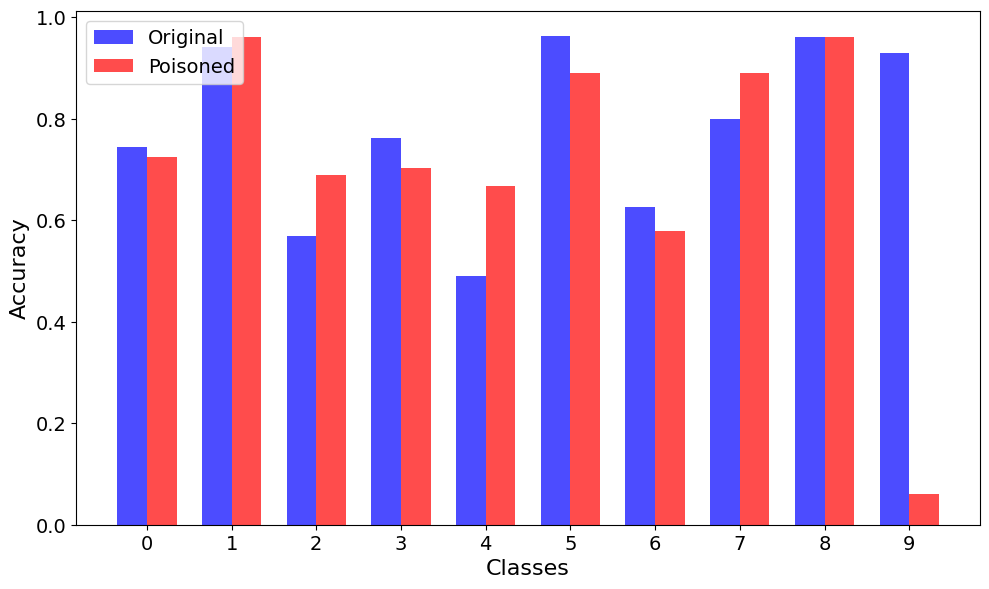

In [271]:
plot_classwise_accuracy_comparison(num_classes = 10, accuracy_per_class1=accuracy_per_class1, accuracy_per_class2=accuracy_per_class2)

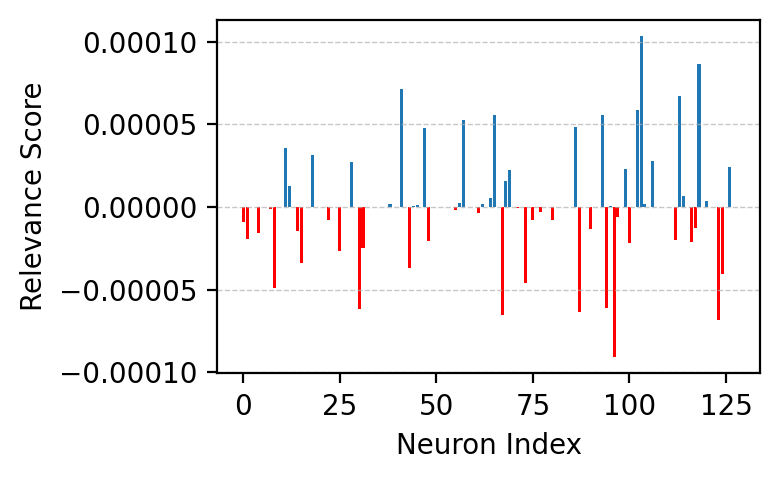

In [272]:
visualize_fc_layer_attributions(layer_lrp_all_ori[-2], highlight_indices=all_indices_sign)

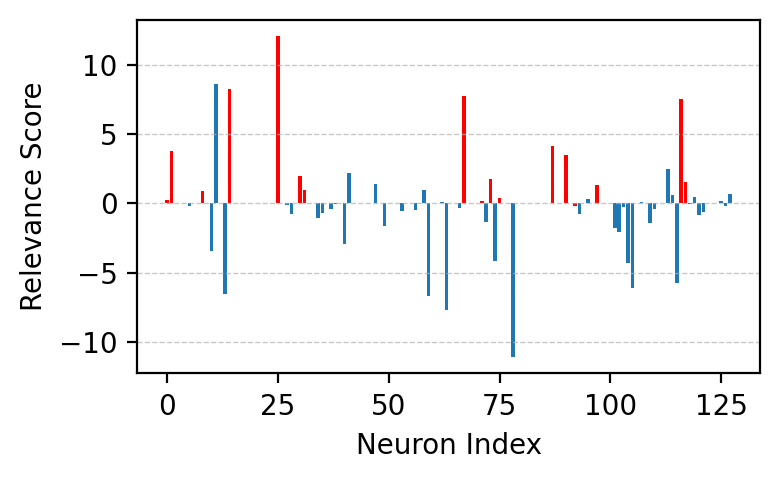

In [273]:
visualize_fc_layer_attributions(layer_lrp_all_cfs[-2], highlight_indices=all_indices_sign)

### Old codes

In [ ]:
### Old codes (unrefined)

In [465]:
# target_layer = layer_lrp_all_cfs[-2] 
target_layer = impact_layer_nn
# Filter positive values and get their indices
all_indices_sign = np.where(target_layer<0)[0]

# Get the top 3 positive values by sorting the indices of the positive values
# top_impact_idxes = all_indices_sign[np.argsort(target_layer[all_indices_sign])[-3:]]
top_impact_idxes = all_indices_sign[np.argsort(target_layer[all_indices_sign])[:10]]

print(top_impact_idxes)

[ 38 111 100  94 124  51  86 122  42  43]


In [466]:
from copy import deepcopy
cli_0_mdl_d = deepcopy(cli_0_mdl)
name = layer_names[-2]
layer = getattr(cli_0_mdl_d, name)

In [467]:
nn_weights = layer.weight.data
top_impact_weights = nn_weights[top_impact_idxes,:]

In [468]:
np.shape(nn_weights)

torch.Size([128, 9216])

In [469]:
len(nn_weights[top_impact_idxes,:][0])

9216

In [470]:
min_value = top_impact_weights.min()
max_value = top_impact_weights.max()

print(f"Range of values: Min = {min_value.item()}, Max = {max_value.item()}")

Range of values: Min = -0.038002364337444305, Max = 0.04635482653975487


In [471]:
# nn_weights[top_impact_idxes,:]=torch.ones_like(top_impact_weights) * 0
nn_weights[top_impact_idxes,:] = top_impact_weights + 1

In [472]:
top_impact_weights

tensor([[ 0.0099,  0.0052, -0.0106,  ...,  0.0100, -0.0091, -0.0053],
        [-0.0006, -0.0015, -0.0056,  ...,  0.0100, -0.0078, -0.0066],
        [ 0.0099, -0.0079, -0.0007,  ..., -0.0081,  0.0027,  0.0027],
        ...,
        [-0.0004,  0.0067, -0.0092,  ..., -0.0045,  0.0015,  0.0023],
        [-0.0084,  0.0047, -0.0105,  ..., -0.0084,  0.0096, -0.0031],
        [ 0.0022, -0.0037, -0.0115,  ..., -0.0055, -0.0094, -0.0014]],
       device='cuda:0')

In [473]:
nn_weights[top_impact_idxes,:]

tensor([[1.0099, 1.0052, 0.9894,  ..., 1.0100, 0.9909, 0.9947],
        [0.9994, 0.9985, 0.9944,  ..., 1.0100, 0.9922, 0.9934],
        [1.0099, 0.9921, 0.9993,  ..., 0.9919, 1.0027, 1.0027],
        ...,
        [0.9996, 1.0067, 0.9908,  ..., 0.9955, 1.0015, 1.0023],
        [0.9916, 1.0047, 0.9895,  ..., 0.9916, 1.0096, 0.9969],
        [1.0022, 0.9963, 0.9885,  ..., 0.9945, 0.9906, 0.9986]],
       device='cuda:0')

In [474]:
output=cli_0_mdl_d(ori_img)
predicted_label = torch.argmax(output, dim=1).item()
print(predicted_label)

9


In [475]:
output=cli_0_mdl(ori_img)
predicted_label = torch.argmax(output, dim=1).item()
print(predicted_label)

2


#### Evaluating the impact for different data values

In [421]:
import torch

def test_by_class(net, testloader):
    """Evaluate the network on the entire test set and compute class-wise accuracy."""
    criterion = torch.nn.CrossEntropyLoss()
    net.eval()
    
    # Initialize overall loss, correct, and total counters
    correct, total, loss = 0, 0, 0.0
    
    # Number of classes (assuming 10 classes, i.e., 0-9)
    num_classes = 10
    
    # Initialize lists to track correct predictions and total samples per class
    correct_per_class = [0] * num_classes
    total_per_class = [0] * num_classes
    
    # Disable gradient calculations
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(constants.DEVICE), labels.to(constants.DEVICE)
            
            # Forward pass
            outputs = net(images)
            
            # Calculate loss
            loss += criterion(outputs, labels).item()
            
            # Get predictions (the index of the max log-probability)
            _, predicted = torch.max(outputs.data, 1)
            
            # Update overall correct and total counts
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Update class-wise correct and total counts
            for label, prediction in zip(labels, predicted):
                total_per_class[label] += 1
                if prediction == label:
                    correct_per_class[label] += 1
    
    # Calculate overall loss and accuracy
    loss /= len(testloader.dataset)
    accuracy = correct / total
    
    # Calculate class-wise accuracy
    accuracy_per_class = [correct_class / total_class if total_class > 0 else 0
                          for correct_class, total_class in zip(correct_per_class, total_per_class)]
    
    # Return overall loss, overall accuracy, and class-wise accuracy
    return loss, accuracy, accuracy_per_class


In [422]:
loss, accuracy, accuracy_per_class2 = test_by_class(cli_0_mdl_d, trainloaders[9])

In [502]:
loss, accuracy, accuracy_per_class1 = test_by_class(cli_0_mdl, trainloaders[9])

In [503]:
accuracy_per_class1

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]

In [504]:
for i, (acc1, acc2) in enumerate(zip(accuracy_per_class1, accuracy_per_class2)):
    if acc1 == acc2:
        print(f"Class {i}: Acc1 = {acc1}, Both accuracies are equal.")
        
    else:
        print(f"Class {i}: Acc1 = {acc1}, Acc2 = {acc2}")

Class 0: Acc1 = 0.0, Both accuracies are equal.
Class 1: Acc1 = 0.0, Both accuracies are equal.
Class 2: Acc1 = 0.0, Both accuracies are equal.
Class 3: Acc1 = 0.0, Both accuracies are equal.
Class 4: Acc1 = 0.0, Both accuracies are equal.
Class 5: Acc1 = 0.0, Both accuracies are equal.
Class 6: Acc1 = 0.0, Both accuracies are equal.
Class 7: Acc1 = 0.0, Both accuracies are equal.
Class 8: Acc1 = 0.0, Both accuracies are equal.
Class 9: Acc1 = 1.0, Both accuracies are equal.


In [436]:
# target_layer = layer_lrp_all_cfs[-2] 
target_layer = impact_layer_nn
# Filter positive values and get their indices
all_indices_sign = np.where(target_layer< 0)[0]

# Get the top 3 positive values by sorting the indices of the positive values
# top_impact_idxes = all_indices_sign[np.argsort(target_layer[all_indices_sign])[-3:]]
top_impact_idxes = all_indices_sign[np.argsort(target_layer[all_indices_sign])[:30]]

# print(top_impact_idxes)

from copy import deepcopy
cli_0_mdl_d = deepcopy(cli_0_mdl)
name = layer_names[-2]
layer = getattr(cli_0_mdl_d, name)

nn_weights = layer.weight.data
top_impact_weights = nn_weights[top_impact_idxes,:]

# nn_weights[top_impact_idxes,:]=torch.ones_like(top_impact_weights) * 0
nn_weights[top_impact_idxes,:] = top_impact_weights + 5

loss, accuracy, accuracy_per_class2 = test_by_class(cli_0_mdl_d, trainloaders[9])

loss, accuracy, accuracy_per_class1 = test_by_class(cli_0_mdl, trainloaders[9])

for i, (acc1, acc2) in enumerate(zip(accuracy_per_class1, accuracy_per_class2)):
    if acc1 == acc2:
        print(f"Class {i}: Acc1 = {acc1}, Both accuracies are equal.")
        
    else:
        print(f"Class {i}: Acc1 = {acc1}, Acc2 = {acc2}")

Class 0: Acc1 = 0.9619047619047619, Acc2 = 0.0
Class 1: Acc1 = 0.9590163934426229, Acc2 = 0.0
Class 2: Acc1 = 0.9647058823529412, Acc2 = 0.0
Class 3: Acc1 = 0.9468085106382979, Acc2 = 0.0
Class 4: Acc1 = 0.9574468085106383, Acc2 = 0.0
Class 5: Acc1 = 0.9012345679012346, Acc2 = 0.0
Class 6: Acc1 = 1.0, Acc2 = 0.0
Class 7: Acc1 = 0.9615384615384616, Acc2 = 0.0
Class 8: Acc1 = 0.9473684210526315, Acc2 = 0.0
Class 9: Acc1 = 0.9259259259259259, Acc2 = 1.0


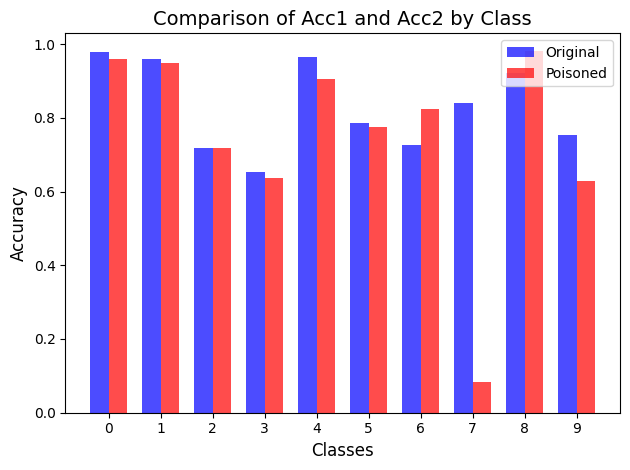

In [123]:
import matplotlib.pyplot as plt
import numpy as np

classes = np.arange(10)  # Assuming 10 classes (0-9)

# Plot Acc1 and Acc2 side by side for each class
bar_width = 0.35
index = np.arange(len(classes))

plt.bar(index, accuracy_per_class1, bar_width, label='Original', color='b', alpha=0.7)
plt.bar(index + bar_width, accuracy_per_class2, bar_width, label='Poisoned', color='r', alpha=0.7)

# Add labels and title
plt.xlabel('Classes', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Comparison of Acc1 and Acc2 by Class', fontsize=14)
plt.xticks(index + bar_width / 2, classes)

# Add legend
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

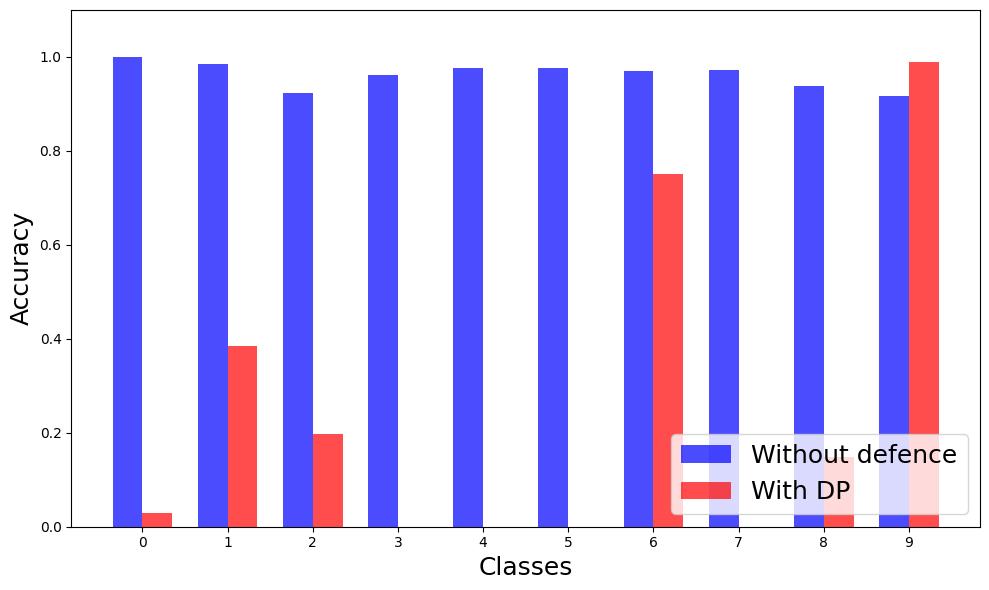

In [2]:
# Re-importing required libraries after reset
import matplotlib.pyplot as plt
import numpy as np

# Accuracy data for each class
classes = np.arange(10)  # Classes 0-9
accuracy_per_class1 = [1.0, 0.9852941176470589, 0.9239130434782609, 0.9620253164556962,
                       0.9770114942528736, 0.975609756097561, 0.9711538461538461,
                       0.9727272727272728, 0.9381443298969072, 0.9159663865546218]
accuracy_per_class2 = [0.0297029702970297,
 0.3838383838383838,
 0.19811320754716982,
 0.0,
 0.0,
 0.0,
 0.75,
 0.0,
 0.14772727272727273,
 0.9891304347826086]

# Plot Acc1 and Acc2 side by side for each class
bar_width = 0.35
index = np.arange(len(classes))

plt.figure(figsize=(10, 6))
plt.bar(index, accuracy_per_class1, bar_width, label='Without defence', color='b', alpha=0.7)
plt.bar(index + bar_width, accuracy_per_class2, bar_width, label='With DP', color='r', alpha=0.7)

# Add labels and title
plt.xlabel('Classes', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
# plt.title('Comparison of Acc1 and Acc2 by Class', fontsize=14)
plt.xticks(index + bar_width / 2, classes)
plt.ylim(0, 1.1)  # Set y-axis range to better visualize accuracy

# Add legend
plt.legend(fontsize=18,loc='lower right')

# Display the plot
plt.tight_layout()
plt.show()


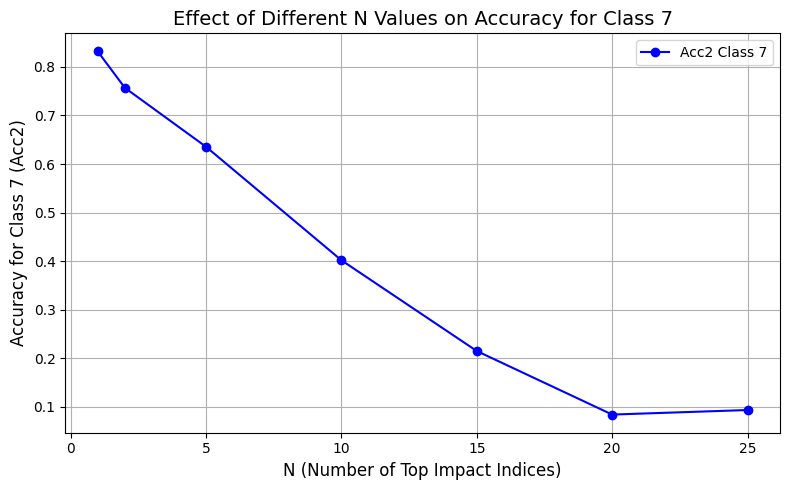

In [88]:
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy

# Values for N (number of top impact indices)
N_values = [1, 2, 5, 10, 15, 20, 25]

# Placeholder for accuracy values for class 7 (Acc2)
acc2_class7 = []

# Assuming 'cli_0_mdl', 'layer_lrp_all_cfs', 'trainloaders', etc. are already defined in your environment

# Extract the target layer
target_layer = layer_lrp_all_cfs[-2]

# Filter positive values and get their indices
all_indices_sign = np.where(target_layer < 0)[0]

# Loop over different N values
for N in N_values:
    # Get the top N impact indices by sorting the indices of the negative values
    top_impact_idxes = all_indices_sign[np.argsort(target_layer[all_indices_sign])[:N]]

    # Create a deepcopy of the model
    cli_0_mdl_d = deepcopy(cli_0_mdl)
    name = layer_names[-2]
    layer = getattr(cli_0_mdl_d, name)

    # Modify the weights in the model
    nn_weights = layer.weight.data
    top_impact_weights = nn_weights[top_impact_idxes, :]
    nn_weights[top_impact_idxes, :] = top_impact_weights - 0.01

    # Run the modified model and get accuracies
    loss, accuracy, accuracy_per_class2 = test_by_class(cli_0_mdl_d, trainloaders[9])

    # Collect accuracy for class 7 (Acc2)
    acc2_class7.append(accuracy_per_class2[7])

# Plotting the results
plt.figure(figsize=(8, 5))
plt.plot(N_values, acc2_class7, marker='o', linestyle='-', color='b', label='Acc2 Class 7')

# Add labels and title
plt.xlabel('N (Number of Top Impact Indices)', fontsize=12)
plt.ylabel('Accuracy for Class 7 (Acc2)', fontsize=12)
plt.title('Effect of Different N Values on Accuracy for Class 7', fontsize=14)

# Show the plot
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import torch
from collections import defaultdict

def get_classwise_size(dataloader, num_classes=10):
    # Dictionary to hold class counts
    class_count = defaultdict(int)
    
    # Loop through the dataloader and count occurrences of each class
    for images, labels in dataloader:
        # Convert labels to numpy for easier counting (optional)
        labels = labels.cpu().numpy()  # If labels are on a different device (like GPU)
        
        # Increment the class count for each label in the batch
        for label in labels:
            class_count[label] += 1

    # Optionally convert defaultdict to a list for better readability if you know the number of classes
    class_count_list = [class_count[i] for i in range(num_classes)]
    
    return class_count_list

In [ ]:
classwise_sizes = get_classwise_size(trainloaders[9], num_classes=10)

for class_idx, count in enumerate(classwise_sizes):
    print(f"Class {class_idx} has {count} samples")

### Standalone function to derive LRP values with counterfactuals and apply poisoning

In [162]:
from omnixai.data.image import Image
from omnixai.explainers.vision import CounterfactualExplainer
import torchvision
import torchvision.transforms as transforms
from copy import deepcopy

def derive_counterfactuals_for_sample_img():
    test_data = torchvision.datasets.MNIST(constants.DATASET_ROOT + "/dataset", train=False, download=True)
    test_data.data = test_data.data.numpy()
    x_test, y_test = Image(test_data.data, batched=True), test_data.targets
    
    transform = transforms.Compose([transforms.ToTensor()])
    preprocess = lambda ims: torch.stack([transform(im.to_pil()) for im in ims])
    # preprocess = lambda ims: torch.stack([transform(im.to_pil()) for im in ims])
    # cli_b = client_updates_list_nw[2]['6'][0]
    # cli_b_mdl = get_mdl_from_weights(cli_b)
    explainer_b = CounterfactualExplainer(
        model=cli_0_mdl,
        preprocess_function=preprocess
    )
    original_sample = x_test[0] # The instance for which you want to generate a counterfactual
    target_label = 1  # The label you want the prediction to shift to
    original_label = y_test[0]
    # explanations_b = explainer_b.explain(x_test[0:5])
    explanations_b = explainer_b.explain(original_sample)
    cfs = (explanations_b.explanations[0]['cf'])
    ori = (explanations_b.explanations[0]['image'])
    ori_img = torch.tensor(ori).unsqueeze(0).unsqueeze(0).to(constants.DEVICE)
    cfs_img = torch.tensor(cfs).unsqueeze(0).unsqueeze(0).to(constants.DEVICE)
    return ori_img, cfs_img, original_label, target_label, original_sample


def derive_lrp_values(image, mdl, label):
    layer_lrp_all = []
    layer_names = []
    for name, layer in mdl.named_modules():
        # layer_lrp = LayerLRP(cli_0_mdl, layer)
        # layer_lrp_all.append(layer_lrp)
        if not name or isinstance(layer, nn.Dropout):
            continue
        # print('here:',name)
        # print(type(layer))
        layer = getattr(mdl, name)
        layer_names.append(name)
        layer_lrp_fc1 = LayerLRP(mdl, layer)
    
        # Compute the relevance score for the selected image and target label (for this example, using the ground truth label)
        # target_label = labels[0].item()
        attributions_fc1 = layer_lrp_fc1.attribute(image, target=label)
        
        # Initialize LayerLRP for the second fully connected layer (fc2)
        # layer_lrp_fc2 = LayerLRP(model, model.fc2)
        # attributions_fc2 = layer_lrp_fc2.attribute(image, target=target_label)
        
        # Convert attributions to numpy for visualization
        attributions_fc1_np = attributions_fc1.cpu().detach().numpy().squeeze()
        layer_lrp_all.append(attributions_fc1_np)
        # attributions_fc2_np = attributions_fc2.detach().numpy().squeeze()
    return layer_lrp_all,layer_names


In [163]:
## create a single function to poison the model
def poison_target_mdl(sample_mdl, target_layer):
    
    target_layer = layer_lrp_all_cfs[-2] 
    # target_layer = impact_layer_nn
    # Filter positive values and get their indices
    all_indices_sign = np.where(target_layer< 0)[0]
    
    # Get the top 3 positive values by sorting the indices of the positive values
    # top_impact_idxes = all_indices_sign[np.argsort(target_layer[all_indices_sign])[-3:]]
    top_impact_idxes = all_indices_sign[np.argsort(target_layer[all_indices_sign])[:20]]
    
    # print(top_impact_idxes)
    
    from copy import deepcopy
    cli_0_mdl_d = deepcopy(cli_0_mdl)
    name = layer_names[-2]
    layer = getattr(cli_0_mdl_d, name)
    
    nn_weights = layer.weight.data
    top_impact_weights = nn_weights[top_impact_idxes,:]
    
    # nn_weights[top_impact_idxes,:]=torch.ones_like(top_impact_weights) * 0
    nn_weights[top_impact_idxes,:] = top_impact_weights + 0.05
    
    loss, accuracy, accuracy_per_class2 = test_by_class(cli_0_mdl_d, trainloaders[9])
    
    loss, accuracy, accuracy_per_class1 = test_by_class(cli_0_mdl, trainloaders[9])
    
    for i, (acc1, acc2) in enumerate(zip(accuracy_per_class1, accuracy_per_class2)):
        if acc1 == acc2:
            print(f"Class {i}: Acc1 = {acc1}, Both accuracies are equal.")
            
        else:
            print(f"Class {i}: Acc1 = {acc1}, Acc2 = {acc2}")

In [164]:
def initialise_random_mdl(is_poisoning_injecting=False, poisoning_type='LRP'):
    net = get_nn()
    net.to(constants.DEVICE)
    return net

In [221]:
def poison_model(target_mdl, threshold, top_impact_nodes_ct, target_layer_id, show_acc=False):
    # target_layer = layer_lrp_all_cfs[-2] 
    ori_img, cfs_img, original_label, target_label, original_sample = derive_counterfactuals_for_sample_img()
    layer_lrp_all_ori,layer_names = derive_lrp_values(image=ori_img, mdl=target_mdl, label=original_label)
    layer_lrp_all_cfs,layer_names = derive_lrp_values(image=cfs_img, mdl=target_mdl, label=original_label)
    impact_layer_nn = layer_lrp_all_cfs[target_layer_id]-layer_lrp_all_ori[target_layer_id]
    
    target_layer = impact_layer_nn
    name = layer_names[target_layer_id]
    # Filter positive values and get their indices
    all_indices_sign = np.where(target_layer< 0)[0]
    
    # Get the top 3 positive values by sorting the indices of the positive values
    # top_impact_idxes = all_indices_sign[np.argsort(target_layer[all_indices_sign])[-3:]]
    top_impact_idxes = all_indices_sign[np.argsort(target_layer[all_indices_sign])[:top_impact_nodes_ct]]
    
    # print(top_impact_idxes)
    target_mdl_d = deepcopy(target_mdl)
    
    layer = getattr(target_mdl_d, name)
    
    nn_weights = layer.weight.data
    top_impact_weights = nn_weights[top_impact_idxes,:]
    
    # nn_weights[top_impact_idxes,:]=torch.ones_like(top_impact_weights) * 0
    nn_weights[top_impact_idxes,:] = top_impact_weights + threshold
    if show_acc:
        loss, accuracy, accuracy_per_class2 = test_by_class(target_mdl_d, trainloaders[9])
        
        loss, accuracy, accuracy_per_class1 = test_by_class(target_mdl, trainloaders[9])
        
        for i, (acc1, acc2) in enumerate(zip(accuracy_per_class1, accuracy_per_class2)):
            if acc1 == acc2:
                print(f"Class {i}: Acc1 = {acc1}, Both accuracies are equal.")
                
            else:
                print(f"Class {i}: Acc1 = {acc1}, Acc2 = {acc2}")
    return target_mdl_d

In [178]:
# target_layer=-2
# target_mdl = initialise_random_mdl()
# ori_img, cfs_img, original_label, target_label, original_sample = derive_counterfactuals_for_sample_img()
# layer_lrp_all_ori,layer_names = derive_lrp_values(image=ori_img, mdl=target_mdl, label=original_label)
# layer_lrp_all_cfs,layer_names = derive_lrp_values(image=cfs_img, mdl=target_mdl, label=original_label)
# impact_layer_nn = layer_lrp_all_cfs[target_layer]-layer_lrp_all_ori[target_layer]

In [223]:
target_layer_id = -2
top_impact_nodes_ct = 5
threshold = 0.01
target_mdl = initialise_random_mdl()
poisoned_mdl = poison_model(target_mdl, threshold, top_impact_nodes_ct, target_layer_id, show_acc=True)

Binary step: 5 |███████████████████████████████████████-| 99.0% Class 0: Acc1 = 0.0, Both accuracies are equal.
Class 1: Acc1 = 0.0, Both accuracies are equal.
Class 2: Acc1 = 0.9375, Acc2 = 0.0
Class 3: Acc1 = 0.0, Acc2 = 1.0
Class 4: Acc1 = 0.0, Both accuracies are equal.
Class 5: Acc1 = 0.02040816326530612, Acc2 = 0.0
Class 6: Acc1 = 0.0, Both accuracies are equal.
Class 7: Acc1 = 0.0, Both accuracies are equal.
Class 8: Acc1 = 0.0, Both accuracies are equal.
Class 9: Acc1 = 0.0, Both accuracies are equal.


### attempting fed AVG

In [126]:
import torch

def fed_avg(models):
    """
    Perform Federated Averaging (FedAvg) on the given models.
    
    Args:
        models: A list of models (e.g., [cli_0_mdl, cli_1_mdl]).
    
    Returns:
        A model with averaged parameters.
    """
    
    # Get the state dictionaries (parameters) from all models
    state_dicts = [model.state_dict() for model in models]
    
    # Initialize a new state dictionary for the averaged model
    avg_state_dict = state_dicts[0].copy()

    # Iterate through each parameter (layer) in the state dictionary
    for key in avg_state_dict.keys():
        # Average the parameters across all models
        avg_state_dict[key] = sum([state_dict[key] for state_dict in state_dicts]) / len(models)
    
    # Load the averaged state dictionary into one of the models (e.g., cli_0_mdl)
    models[0].load_state_dict(avg_state_dict)
    
    # Return the averaged model (cli_0_mdl in this case)
    return models[0]


In [134]:
mdls = []
samp_mdl_ids = [str(i) for i in range(5)]
for i in samp_mdl_ids:
    cli_0 = client_updates_list_nw[0][i][0]
    cli_0_ = get_mdl_from_weights(cli_0)
    cli_0_.to(constants.DEVICE)
    mdls.append(cli_0_)

In [128]:
# mdls

In [135]:
# Example usage:
# Assuming cli_0_mdl and cli_1_mdl are two PyTorch models
averaged_model = fed_avg(mdls)

In [130]:
loss, accuracy, accuracy_per_class_filter = test_by_class(averaged_model, trainloaders[9])

In [131]:
mdls.append(cli_0_mdl_d)
averaged_model = fed_avg(mdls)

In [157]:
loss, accuracy, accuracy_per_class_no_fil = test_by_class(averaged_model, trainloaders[9])

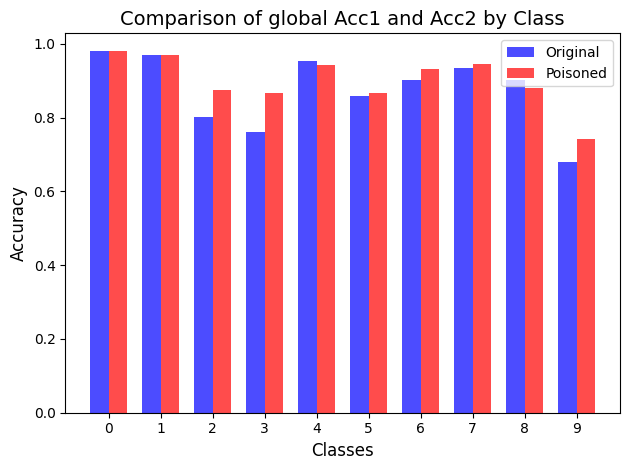

In [158]:
classes = np.arange(10)  # Assuming 10 classes (0-9)

# Plot Acc1 and Acc2 side by side for each class
bar_width = 0.35
index = np.arange(len(classes))

plt.bar(index, accuracy_per_class_filter, bar_width, label='Original', color='b', alpha=0.7)
plt.bar(index + bar_width, accuracy_per_class_no_fil, bar_width, label='Poisoned', color='r', alpha=0.7)

# Add labels and title
plt.xlabel('Classes', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Comparison of global Acc1 and Acc2 by Class', fontsize=14)
plt.xticks(index + bar_width / 2, classes)

# Add legend
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

### Testing foolsgold

In [147]:
import numpy as np
import pdb
import sklearn.metrics.pairwise as smp

# Takes in grad
# Compute similarity
# Get weightings
def foolsgold(grads, n_clients):
    # n_clients = grads.shape[0]
    cs = smp.cosine_similarity(grads) - np.eye(n_clients)
    maxcs = np.max(cs, axis=1)
    # pardoning
    for i in range(n_clients):
        for j in range(n_clients):
            if i == j:
                continue
            if maxcs[i] < maxcs[j]:
                cs[i][j] = cs[i][j] * maxcs[i] / maxcs[j]
    wv = 1 - (np.max(cs, axis=1))
    wv[wv > 1] = 1
    wv[wv < 0] = 0

    # Rescale so that max value is wv
    wv = wv / np.max(wv)
    wv[(wv == 1)] = .99
    
    # Logit function
    wv = (np.log(wv / (1 - wv)) + 0.5)
    wv[(np.isinf(wv) + wv > 1)] = 1
    wv[(wv < 0)] = 0

    return wv

In [260]:
def run_foolsgold(num_clients, num_rounds, weight_results, with_history=False):
    grad_len = len(np.concatenate([arr.flatten() for arr in weight_results[0][0][0]]))
    all_results = []
    
    arr = np.zeros((num_clients, grad_len))
    
    for i in range(num_rounds):
        items = []
        for j in range(num_clients):
            arr_i_j = np.concatenate([arr.flatten() for arr in weight_results[i][j][0]])
            items.append(arr_i_j)    

        if with_history:
            arr+=items
            res = foolsgold(arr, n_clients=num_clients)
        else:
            res = foolsgold(items, n_clients=num_clients)
        all_results.append(res)
    return all_results

def run_foolsgold_new(num_clients, num_rounds, weights, with_history=True):
    grad_len = len(np.concatenate([arr.flatten() for arr in weights[0][0]]))
    all_results = []
    
    arr = np.zeros((num_clients, grad_len))
    
    for i in range(num_rounds):
        items = []
        for j in range(num_clients):
            arr_i_j = np.concatenate([arr.flatten() for arr in weights[i][j]])
            items.append(arr_i_j)    

        if with_history:
            arr+=items
            res = foolsgold(arr, n_clients=num_clients)
        else:
            res = foolsgold(items, n_clients=num_clients)
        all_results.append(res)
    return all_results

([array([[[[ 1.83832347e-01,  3.46789360e-01,  3.58372211e-01],
           [ 3.28794301e-01,  2.16612875e-01,  2.29879305e-01],
           [ 1.09587021e-01,  2.43983269e-01,  3.36246282e-01]]],
  
  
         [[[-2.08459765e-01,  1.57177404e-01,  2.57814258e-01],
           [ 3.27977777e-01, -3.69021930e-02,  2.05233946e-01],
           [ 1.48161829e-01, -2.70973921e-01,  2.83935577e-01]]],
  
  
         [[[ 1.94435090e-01, -5.96754402e-02,  1.78363353e-01],
           [ 3.63596529e-01,  2.99005240e-01,  2.23270729e-01],
           [ 3.35950971e-01, -1.81772690e-02, -7.50147402e-02]]],
  
  
         [[[ 1.16239883e-01, -2.56415606e-01, -2.20997468e-01],
           [ 1.14481449e-01,  7.30813146e-02, -2.65789747e-01],
           [ 2.49916911e-01, -4.11607511e-02, -3.12419862e-01]]],
  
  
         [[[-2.28838086e-01, -2.61344790e-01,  3.42700273e-01],
           [ 1.98855884e-02,  2.78351247e-01, -2.84506887e-01],
           [-2.73793459e-01,  1.23354428e-01, -2.86065847e-01]]],
  
  


In [276]:
# Example usage:
# Assuming cli_0_mdl and cli_1_mdl are two PyTorch models
mdls = []

target_layer_id = -2
top_impact_nodes_ct = 20
threshold = 0.005

poison_ids = [str(i) for i in range(5)]
samp_mdl_ids = [str(i) for i in range(10)]
for i in samp_mdl_ids:
    cli_0 = client_updates_list_nw[0][i][0]
    cli_0_ = get_mdl_from_weights(cli_0)
    cli_0_.to(constants.DEVICE)
    if i in poison_ids:
        print('poisoning: ',i)
        poisoned_mdl = poison_model(cli_0_, threshold, top_impact_nodes_ct, target_layer_id, show_acc=True)
        mdls.append(poisoned_mdl)
    else:
        mdls.append(cli_0_)
# mdls.append(cli_0_mdl_d)


# averaged_model = fed_avg(mdls)

poisoning:  0
Binary step: 5 |███████████████████████████████████████-| 99.0% 

/home/chamara/anaconda3/envs/1-poisoning-xai/lib/python3.11/site-packages/captum/_utils/gradient.py:57: UserWarning:

Input Tensor 0 did not already require gradients, required_grads has been set automatically.



Class 0: Acc1 = 0.8932038834951457, Acc2 = 0.912621359223301
Class 1: Acc1 = 0.9714285714285714, Acc2 = 0.3904761904761905
Class 2: Acc1 = 0.8725490196078431, Both accuracies are equal.
Class 3: Acc1 = 0.5486725663716814, Acc2 = 0.3893805309734513
Class 4: Acc1 = 0.9550561797752809, Acc2 = 0.011235955056179775
Class 5: Acc1 = 0.4383561643835616, Acc2 = 0.0
Class 6: Acc1 = 0.9565217391304348, Acc2 = 0.7065217391304348
Class 7: Acc1 = 0.8793103448275862, Acc2 = 0.9827586206896551
Class 8: Acc1 = 0.912621359223301, Acc2 = 0.30097087378640774
Class 9: Acc1 = 0.7211538461538461, Acc2 = 0.0
poisoning:  1
Binary step: 5 |███████████████████████████████████████-| 99.0% Class 0: Acc1 = 0.7184466019417476, Acc2 = 0.4174757281553398
Class 1: Acc1 = 0.9428571428571428, Acc2 = 0.0
Class 2: Acc1 = 0.7058823529411765, Acc2 = 0.0392156862745098
Class 3: Acc1 = 0.49557522123893805, Acc2 = 0.017699115044247787
Class 4: Acc1 = 0.1797752808988764, Acc2 = 0.0
Class 5: Acc1 = 1.0, Acc2 = 0.2465753424657534


In [277]:
# Assume 'models' is a list of PyTorch models
# mdls = [model1, model2, model3]  # Example list of models

# Create an empty list to store all weights for all models
all_models_weights_list = []

# Iterate over each model in the models list
for model in mdls:
    model_weights = model.state_dict()  # Get the state_dict for the current model
    
    model_weights_list = []  # Temporary list to store the weights for this model
    
    # Iterate over all the weights in the state_dict and append them to the model's list
    for param_tensor in model_weights:
        weights = model_weights[param_tensor].cpu().numpy()  # Convert to numpy (optional)
        model_weights_list.append(weights)
    
    # Append this model's weights to the main list
    all_models_weights_list.append(model_weights_list)

# Now all_models_weights_list contains weights for each model in the models list


In [339]:
from src.FLProcess.FLUtil import get_mdl_from_weights, get_weights_from_mdl

def get_mdls_poisoned_for_analysis(num_poison,iteration, client_updates_list=None, threshold = 0.005, top_impact_nodes_ct = 20, target_layer_id = -2):
    mdls = []
    
    target_layer_id = -2
    # top_impact_nodes_ct = 20
    # threshold = 0.005
    if(client_updates_list!=None):
        client_updates_list_nw2 = copy.deepcopy(client_updates_list)
    else:
        client_updates_list_nw2 = copy.deepcopy(client_updates_list_nw)
    
    poison_ids = [str(i) for i in range(num_poison)]
    samp_mdl_ids = [str(i) for i in range(len(client_updates_list_nw[0]))]
    for i in samp_mdl_ids:
        cli_0 = client_updates_list_nw2[iteration][i][0]
        cli_0_ = get_mdl_from_weights(cli_0)
        cli_0_.to(constants.DEVICE)
        if i in poison_ids:
            print('poisoning: ',i)
            poisoned_mdl = poison_model(cli_0_, threshold, top_impact_nodes_ct, target_layer_id, show_acc=True)
            mdls.append(poisoned_mdl)
        else:
            mdls.append(cli_0_)
        client_updates_list_nw2[iteration][i] = (get_weights_from_mdl(poisoned_mdl),32)
    # mdls.append(cli_0_mdl_d)
    
    
    # averaged_model = fed_avg(mdls)
    
    all_models_weights_list = []
    
    # Iterate over each model in the models list
    for model in mdls:
        model_weights = model.state_dict()  # Get the state_dict for the current model
        
        model_weights_list = []  # Temporary list to store the weights for this model
        
        # Iterate over all the weights in the state_dict and append them to the model's list
        for param_tensor in model_weights:
            weights = model_weights[param_tensor].cpu().numpy()  # Convert to numpy (optional)
            model_weights_list.append(weights)
        
        # Append this model's weights to the main list
        all_models_weights_list.append(model_weights_list)
    
    # Now all_models_weights_list contains weights for each model in the models list
    return all_models_weights_list, client_updates_list_nw2


In [280]:
run_foolsgold_new(num_clients=len(mdls), num_rounds=1, weights=[all_models_weights_list], with_history=False)

[array([1.        , 1.        , 1.        , 1.        , 1.        ,
        0.9599255 , 0.94926879, 0.9599255 , 0.94926879, 1.        ])]

In [154]:
# weight_results[0][0][0]

In [358]:
num_clients = 10
num_rounds = 1
all_results_fg = []
total_time_fg = []

for i in range(1):
    start_time = time.time()
    all_models_weights_list, _ = get_mdls_poisoned_for_analysis(num_poison=5,iteration=i)
    all_results = run_foolsgold_new(num_clients=len(mdls), num_rounds=1, weights=[all_models_weights_list], with_history=False)
    print(all_results)
    end_time = time.time()
    all_results_fg.append(all_results)
    elapsed = end_time-start_time
    print('time taken: ', elapsed)
    total_time_fg.append(elapsed)

poisoning:  0
Binary step: 5 |███████████████████████████████████████-| 99.0% 

/home/chamara/anaconda3/envs/1-poisoning-xai/lib/python3.11/site-packages/captum/_utils/gradient.py:57: UserWarning:

Input Tensor 0 did not already require gradients, required_grads has been set automatically.



Class 0: Acc1 = 0.8932038834951457, Acc2 = 0.0
Class 1: Acc1 = 0.9714285714285714, Acc2 = 0.6285714285714286
Class 2: Acc1 = 0.8725490196078431, Acc2 = 0.803921568627451
Class 3: Acc1 = 0.5486725663716814, Acc2 = 0.08849557522123894
Class 4: Acc1 = 0.9550561797752809, Acc2 = 0.14606741573033707
Class 5: Acc1 = 0.4383561643835616, Acc2 = 0.0
Class 6: Acc1 = 0.9565217391304348, Acc2 = 0.010869565217391304
Class 7: Acc1 = 0.8793103448275862, Acc2 = 0.8189655172413793
Class 8: Acc1 = 0.912621359223301, Both accuracies are equal.
Class 9: Acc1 = 0.7211538461538461, Acc2 = 1.0
poisoning:  1
Binary step: 5 |███████████████████████████████████████-| 99.0% Class 0: Acc1 = 0.7184466019417476, Acc2 = 0.1941747572815534
Class 1: Acc1 = 0.9428571428571428, Acc2 = 0.0
Class 2: Acc1 = 0.7058823529411765, Acc2 = 0.8921568627450981
Class 3: Acc1 = 0.49557522123893805, Acc2 = 0.23008849557522124
Class 4: Acc1 = 0.1797752808988764, Acc2 = 0.0
Class 5: Acc1 = 1.0, Acc2 = 0.3972602739726027
Class 6: Acc1 =

In [293]:
TARGET_CLIENTS = [str(i) for i in range(5)]

for result_ct in range(len(all_results_fg)):
    all_results = all_results_fg[result_ct]
    values_to_find =  [str(i) for i in TARGET_CLIENTS]
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    
    for i in range(num_rounds):
        my_list = list(client_updates_list[i].keys())
        poison_indexes = [i for i, value in enumerate(my_list) if value in values_to_find]
        for j in range(num_clients):
            cli_p = all_results[i][j]
            if cli_p<0.5 and j in poison_indexes:
                TP+=1
            if cli_p<0.5 and j not in poison_indexes:
                FP+=1
            elif cli_p>=0.5 and j not in poison_indexes:
                TN+=1
            elif cli_p>=0.5 and j in poison_indexes:
                FN+=1
    
    print(f"TP: {TP}, TN: {TN}, FP: {FP}, FN: {FN}")

TP: 0, TN: 5, FP: 0, FN: 5
TP: 0, TN: 3, FP: 2, FN: 5
TP: 1, TN: 1, FP: 4, FN: 4
TP: 1, TN: 2, FP: 3, FN: 4
TP: 1, TN: 1, FP: 4, FN: 4
TP: 1, TN: 1, FP: 4, FN: 4
TP: 1, TN: 1, FP: 4, FN: 4
TP: 1, TN: 1, FP: 4, FN: 4
TP: 0, TN: 1, FP: 4, FN: 5
TP: 1, TN: 1, FP: 4, FN: 4


In [360]:
TARGET_CLIENTS = [str(i) for i in range(5)]

for result_ct in range(len(all_results_fg)):
    all_results = all_results_fg[result_ct]
    
    values_to_find =  [str(i) for i in TARGET_CLIENTS]
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    
    for i in range(num_rounds):
        my_list = list(client_updates_list[i].keys())
        poison_indexes = [i for i, value in enumerate(my_list) if value in values_to_find]
        for j in range(num_clients):
            cli_p = all_results[i][j]
            if cli_p<0.5 and j in poison_indexes:
                TP+=1
            if cli_p<0.5 and j not in poison_indexes:
                FP+=1
            elif cli_p>=0.5 and j not in poison_indexes:
                TN+=1
            elif cli_p>=0.5 and j in poison_indexes:
                FN+=1
    
    print(f"TP: {TP}, TN: {TN}, FP: {FP}, FN: {FN}")

[[array([1.        , 1.        , 1.        , 1.        , 1.        ,
         0.80743389, 0.79769662, 0.80743389, 0.79769662, 0.99344103])]]

### Testing SHERPA

In [310]:
from src.FLProcess.FLUtil import get_mdl_from_weights, get_pred_from_models, get_mdl_of_client_at_round, get_weights_from_mdl
from src.dataset.datasetHandler import get_testloader
import shap
from src.poisonDetection.clusteringHDBSCAN import run_hdbscan_clustering_algorithm
from src.poisonDetection.tsneVisualisation import get_tsne_data_from_input_features, visualise_tsne_clusters_with_idx, \
    visualise_clusters_with_tsne
from src.poisonDetection.clientAnalysis.strategyFnGeneralAlg import general_algorithm_main_calc
import copy

In [328]:
_, client_updates_list_nw2 = get_mdls_poisoned_for_analysis(num_poison=5,iteration=10)

poisoning:  0
Binary step: 5 |███████████████████████████████████████-| 99.0% Class 0: Acc1 = 0.9902912621359223, Acc2 = 0.4174757281553398
Class 1: Acc1 = 0.9904761904761905, Acc2 = 0.6476190476190476
Class 2: Acc1 = 0.9803921568627451, Acc2 = 0.30392156862745096
Class 3: Acc1 = 0.9734513274336283, Acc2 = 0.7787610619469026
Class 4: Acc1 = 0.9775280898876404, Acc2 = 0.38202247191011235
Class 5: Acc1 = 1.0, Acc2 = 0.5616438356164384
Class 6: Acc1 = 1.0, Acc2 = 0.7065217391304348
Class 7: Acc1 = 0.9741379310344828, Acc2 = 0.9913793103448276
Class 8: Acc1 = 0.9805825242718447, Acc2 = 0.7475728155339806
Class 9: Acc1 = 0.9903846153846154, Acc2 = 0.9711538461538461
poisoning:  1
Binary step: 5 |███████████████████████████████████████-| 99.0% Class 0: Acc1 = 0.9805825242718447, Acc2 = 0.7475728155339806
Class 1: Acc1 = 0.9904761904761905, Acc2 = 0.34285714285714286
Class 2: Acc1 = 1.0, Acc2 = 0.6568627450980392
Class 3: Acc1 = 0.9823008849557522, Acc2 = 0.46017699115044247
Class 4: Acc1 = 0

In [352]:
# client_updates_list_nw2 = copy.deepcopy(client_updates_list_nw)
_, client_updates_list_nw2 = get_mdls_poisoned_for_analysis(num_poison = 5 , iteration=0 , client_updates_list=client_updates_list_nw, 
                                                            threshold = 0.005, top_impact_nodes_ct = 20)
for i in range(9):
    _, client_updates_list_nw2 = get_mdls_poisoned_for_analysis(num_poison=5, iteration=i+1, client_updates_list=client_updates_list_nw2,
                                                                threshold = 0.005, top_impact_nodes_ct = 20)

poisoning:  0
Binary step: 5 |███████████████████████████████████████-| 99.0% 

/home/chamara/anaconda3/envs/1-poisoning-xai/lib/python3.11/site-packages/captum/_utils/gradient.py:57: UserWarning:

Input Tensor 0 did not already require gradients, required_grads has been set automatically.



Class 0: Acc1 = 0.8932038834951457, Acc2 = 0.1262135922330097
Class 1: Acc1 = 0.9714285714285714, Both accuracies are equal.
Class 2: Acc1 = 0.8725490196078431, Acc2 = 0.5392156862745098
Class 3: Acc1 = 0.5486725663716814, Acc2 = 0.0
Class 4: Acc1 = 0.9550561797752809, Acc2 = 0.38202247191011235
Class 5: Acc1 = 0.4383561643835616, Acc2 = 0.0
Class 6: Acc1 = 0.9565217391304348, Acc2 = 0.5760869565217391
Class 7: Acc1 = 0.8793103448275862, Acc2 = 0.9827586206896551
Class 8: Acc1 = 0.912621359223301, Acc2 = 0.46601941747572817
Class 9: Acc1 = 0.7211538461538461, Acc2 = 0.028846153846153848
poisoning:  1
Binary step: 5 |███████████████████████████████████████-| 99.0% Class 0: Acc1 = 0.7184466019417476, Acc2 = 0.14563106796116504
Class 1: Acc1 = 0.9428571428571428, Acc2 = 0.0
Class 2: Acc1 = 0.7058823529411765, Acc2 = 0.0
Class 3: Acc1 = 0.49557522123893805, Acc2 = 0.0
Class 4: Acc1 = 0.1797752808988764, Acc2 = 0.0
Class 5: Acc1 = 1.0, Acc2 = 0.7945205479452054
Class 6: Acc1 = 0.78260869565

In [312]:
client_updates_list_nw2[0]['4']

([array([[[[ 0.18397932,  0.3430753 ,  0.3519986 ],
           [ 0.32719782,  0.21769057,  0.22632673],
           [ 0.09980163,  0.23263519,  0.32666606]]],
  
  
         [[[-0.20152685,  0.15038145,  0.24673133],
           [ 0.33044788, -0.04299004,  0.19984654],
           [ 0.1466639 , -0.27651396,  0.28104824]]],
  
  
         [[[ 0.19421019, -0.05348359,  0.18526006],
           [ 0.36308005,  0.3017147 ,  0.21735212],
           [ 0.33146146, -0.02430091, -0.08658742]]],
  
  
         [[[ 0.11787386, -0.26094487, -0.22616602],
           [ 0.11620165,  0.06509349, -0.27361354],
           [ 0.24866223, -0.04973934, -0.32051867]]],
  
  
         [[[-0.22385927, -0.257899  ,  0.3473542 ],
           [ 0.02532862,  0.28393373, -0.28250277],
           [-0.27041626,  0.12621808, -0.28751367]]],
  
  
         [[[-0.09240422, -0.32950777,  0.06303146],
           [ 0.00932889,  0.2028938 , -0.33205765],
           [ 0.32941896, -0.26740307,  0.32063875]]],
  
  
         [[[ 0.1

In [313]:
get_mdl_from_weights(get_weights_from_mdl(cli_0_mdl_d))

Net_MNIST(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [314]:
client_updates_list_nw2[0]['3'] = (get_weights_from_mdl(cli_0_mdl_d),32)
client_updates_list_nw2[0]['4'] = (get_weights_from_mdl(cli_0_mdl_d),32)

In [315]:
client_updates_list_nw2[0]['4']

([array([[[[ 1.28079295e-01, -1.98252231e-01,  3.26173782e-01],
           [ 1.71877131e-01,  2.47819290e-01,  3.57033134e-01],
           [-1.70962453e-01, -3.73751581e-01, -8.86401609e-02]]],
  
  
         [[[-3.52411680e-02,  1.25691041e-01,  2.49747336e-01],
           [-4.79811467e-02,  1.41480729e-01, -1.31532699e-01],
           [-7.24238344e-03, -3.14807773e-01,  5.67916892e-02]]],
  
  
         [[[ 1.53851332e-02,  1.53138768e-02,  2.41750002e-01],
           [-1.80487871e-01,  1.24201074e-01, -2.03083873e-01],
           [-2.47884989e-01, -8.05257112e-02, -9.62205082e-02]]],
  
  
         [[[ 3.79780918e-01,  1.18244573e-01, -2.70778567e-01],
           [-1.86415285e-01,  2.88154989e-01, -2.39097506e-01],
           [ 3.62051487e-01, -2.06901640e-01, -1.30052552e-01]]],
  
  
         [[[ 9.56811979e-02,  1.10415611e-02, -2.30333671e-01],
           [-2.01359075e-02,  2.89685756e-01,  3.52047265e-01],
           [-2.99317926e-01, -3.30075234e-01, -3.31989288e-01]]],
  
  


/home/chamara/anaconda3/envs/1-poisoning-xai/lib/python3.11/site-packages/torch/nn/modules/module.py:1344: UserWarning:

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.

/home/chamara/anaconda3/envs/1-poisoning-xai/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/home/chamara/anaconda3/envs/1-poisoning-xai/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



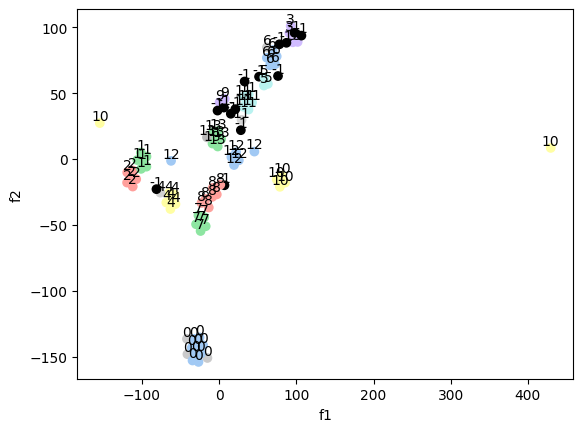

{-1: [34, 36, 38, 60, 63, 64, 66, 68, 69, 82, 84, 86, 94, 99], 0: [7, 17, 27, 30, 35, 37, 47, 57, 67, 77, 87, 97], 1: [2, 12, 22, 42, 52, 72], 2: [9, 19, 29, 49, 59, 79], 3: [31, 61, 62, 91], 4: [3, 13, 23, 33, 43, 53, 73], 5: [65, 90, 95], 6: [1, 11, 21, 41, 51, 71, 81], 7: [4, 14, 24, 44, 54, 74], 8: [80, 83, 85, 88, 89, 92, 93], 9: [32, 39], 10: [0, 10, 20, 40, 50, 70], 11: [8, 18, 28, 48, 58, 78, 98], 12: [5, 15, 25, 45, 55, 75], 13: [6, 16, 26, 46, 56, 76, 96]}
All cluster features are the same: 1
All cluster features are the same: 2
All cluster features are the same: 4
All cluster features are the same: 6
All cluster features are the same: 7
All cluster features are the same: 10
All cluster features are the same: 11
All cluster features are the same: 12
All cluster features are the same: 13
{'5': 1, '6': 1, '9': 1, '3': 9, '4': 1, '8': 1, '0': 10, '7': 1, '1': 9, '2': 8}
dict_values([1, 1, 1, 9, 1, 1, 10, 1, 9, 8])
{'5': 1, '6': 1, '9': 1, '3': 9, '4': 1, '8': 1, '0': 10, '7': 1,

/home/chamara/anaconda3/envs/1-poisoning-xai/lib/python3.11/site-packages/torch/nn/modules/module.py:1344: UserWarning:

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.

/home/chamara/anaconda3/envs/1-poisoning-xai/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/home/chamara/anaconda3/envs/1-poisoning-xai/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



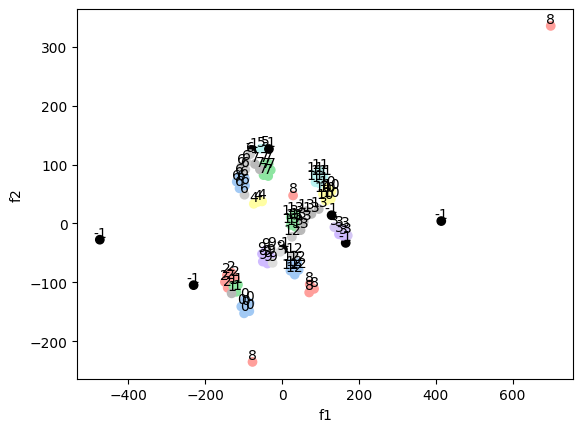

{-1: [35, 36, 39, 64, 68, 89, 94, 99], 0: [9, 19, 29, 49, 59, 79], 1: [37, 67, 87, 97], 2: [7, 17, 27, 47, 57, 77], 3: [34, 69, 84, 85, 86, 96], 4: [82, 92, 93], 5: [38, 98], 6: [0, 10, 20, 30, 40, 50, 60, 65, 70, 80, 90], 7: [2, 12, 22, 42, 52, 62, 63, 72], 8: [4, 14, 24, 44, 54, 74], 9: [3, 13, 23, 33, 43, 53, 73, 83, 88], 10: [8, 18, 28, 48, 58, 78], 11: [5, 15, 25, 45, 55, 75], 12: [1, 11, 21, 32, 41, 51, 61, 71], 13: [6, 16, 26, 31, 46, 56, 66, 76, 81, 91, 95]}
All cluster features are the same: 0
All cluster features are the same: 1
All cluster features are the same: 2
All cluster features are the same: 5
All cluster features are the same: 8
All cluster features are the same: 10
All cluster features are the same: 11
{'5': 5, '6': 5, '9': 5, '3': 8, '4': 5, '8': 5, '0': 9, '7': 5, '1': 9, '2': 8}
dict_values([5, 5, 5, 8, 5, 5, 9, 5, 9, 8])
{'5': 5, '6': 5, '9': 5, '3': 8, '4': 5, '8': 5, '0': 9, '7': 5, '1': 9, '2': 8}
detected:  [3, 6, 8, 9]
original:  []


/home/chamara/anaconda3/envs/1-poisoning-xai/lib/python3.11/site-packages/torch/nn/modules/module.py:1344: UserWarning:

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.

/home/chamara/anaconda3/envs/1-poisoning-xai/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/home/chamara/anaconda3/envs/1-poisoning-xai/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



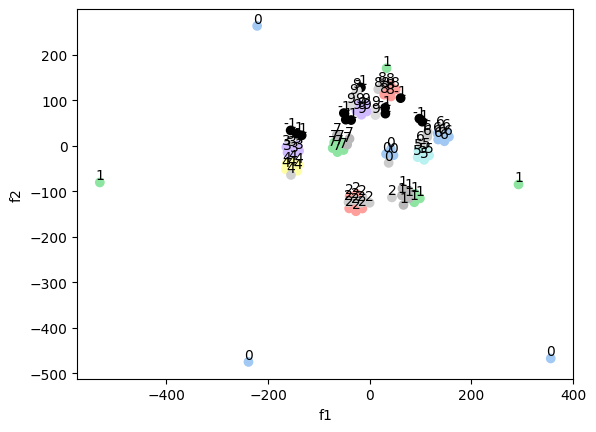

{-1: [34, 39, 60, 62, 63, 65, 66, 69, 81, 82, 83, 84], 0: [3, 13, 23, 30, 43, 53, 73], 1: [9, 19, 29, 32, 49, 59, 79, 89, 93, 98, 99], 2: [7, 17, 27, 37, 47, 57, 67, 77, 87, 90, 95, 97], 3: [6, 16, 26, 46, 56, 76, 86], 4: [4, 14, 24, 44, 54, 74, 94], 5: [0, 10, 20, 40, 50, 70], 6: [2, 12, 22, 33, 42, 52, 72, 80, 88, 92], 7: [5, 15, 25, 35, 36, 45, 55, 61, 75], 8: [1, 11, 21, 31, 41, 51, 71, 91], 9: [8, 18, 28, 38, 48, 58, 64, 68, 78, 85, 96]}
All cluster features are the same: 3
All cluster features are the same: 4
All cluster features are the same: 5
All cluster features are the same: 8
{'5': 6, '6': 6, '9': 6, '3': 9, '4': 6, '8': 6, '0': 10, '7': 6, '1': 9, '2': 8}
dict_values([6, 6, 6, 9, 6, 6, 10, 6, 9, 8])
{'5': 6, '6': 6, '9': 6, '3': 9, '4': 6, '8': 6, '0': 10, '7': 6, '1': 9, '2': 8}
detected:  [3, 6, 8, 9]
original:  []


/home/chamara/anaconda3/envs/1-poisoning-xai/lib/python3.11/site-packages/torch/nn/modules/module.py:1344: UserWarning:

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.

/home/chamara/anaconda3/envs/1-poisoning-xai/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/home/chamara/anaconda3/envs/1-poisoning-xai/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



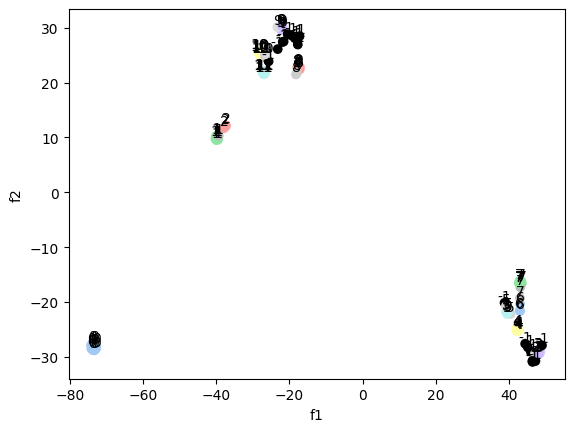

{-1: [30, 32, 33, 35, 36, 38, 39, 60, 61, 62, 63, 64, 65, 68, 82, 85, 91, 98, 99], 0: [7, 17, 27, 37, 47, 57, 67, 77, 87, 97], 1: [2, 12, 22, 42, 52, 72, 92], 2: [83, 89, 93], 3: [6, 16, 26, 46, 56, 66, 76], 4: [5, 15, 25, 45, 55, 75], 5: [1, 11, 21, 31, 41, 51, 71, 81], 6: [84, 86, 96], 7: [4, 14, 24, 34, 44, 54, 74, 94], 8: [0, 10, 20, 40, 50, 70, 80, 90], 9: [9, 19, 29, 49, 59, 69, 79, 95], 10: [8, 18, 28, 48, 58, 78, 88], 11: [3, 13, 23, 43, 53, 73]}
All cluster features are the same: 0
All cluster features are the same: 1
All cluster features are the same: 3
All cluster features are the same: 4
All cluster features are the same: 5
All cluster features are the same: 7
All cluster features are the same: 8
All cluster features are the same: 10
All cluster features are the same: 11
{'5': 1, '6': 1, '9': 1, '3': 7, '4': 1, '8': 1, '0': 8, '7': 1, '1': 6, '2': 6}
dict_values([1, 1, 1, 7, 1, 1, 8, 1, 6, 6])
{'5': 1, '6': 1, '9': 1, '3': 7, '4': 1, '8': 1, '0': 8, '7': 1, '1': 6, '2': 6}


/home/chamara/anaconda3/envs/1-poisoning-xai/lib/python3.11/site-packages/torch/nn/modules/module.py:1344: UserWarning:

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.

/home/chamara/anaconda3/envs/1-poisoning-xai/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/home/chamara/anaconda3/envs/1-poisoning-xai/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



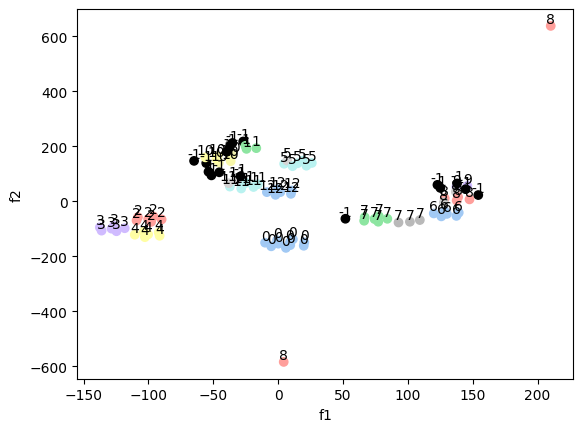

{-1: [30, 39, 60, 61, 66, 69, 80, 83, 86, 89, 90, 91, 93, 94, 98, 99], 0: [7, 17, 27, 37, 47, 57, 67, 77, 87, 97], 1: [34, 84, 96], 2: [0, 10, 20, 40, 50, 70], 3: [3, 13, 23, 43, 53, 73], 4: [2, 12, 22, 42, 52, 72], 5: [4, 14, 24, 44, 54, 64, 74], 6: [9, 19, 29, 49, 59, 79], 7: [8, 18, 28, 48, 58, 63, 78, 82, 92], 8: [5, 15, 25, 45, 55, 65, 68, 75], 9: [32, 62], 10: [33, 35, 36, 38, 85, 88, 95], 11: [1, 11, 21, 31, 41, 51, 71, 81], 12: [6, 16, 26, 46, 56, 76]}
All cluster features are the same: 0
All cluster features are the same: 2
All cluster features are the same: 3
All cluster features are the same: 4
All cluster features are the same: 5
All cluster features are the same: 6
All cluster features are the same: 9
All cluster features are the same: 11
All cluster features are the same: 12
{'5': 2, '6': 2, '9': 2, '3': 7, '4': 2, '8': 2, '0': 7, '7': 2, '1': 8, '2': 9}
dict_values([2, 2, 2, 7, 2, 2, 7, 2, 8, 9])
{'5': 2, '6': 2, '9': 2, '3': 7, '4': 2, '8': 2, '0': 7, '7': 2, '1': 8, '2

/home/chamara/anaconda3/envs/1-poisoning-xai/lib/python3.11/site-packages/torch/nn/modules/module.py:1344: UserWarning:

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.

/home/chamara/anaconda3/envs/1-poisoning-xai/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/home/chamara/anaconda3/envs/1-poisoning-xai/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



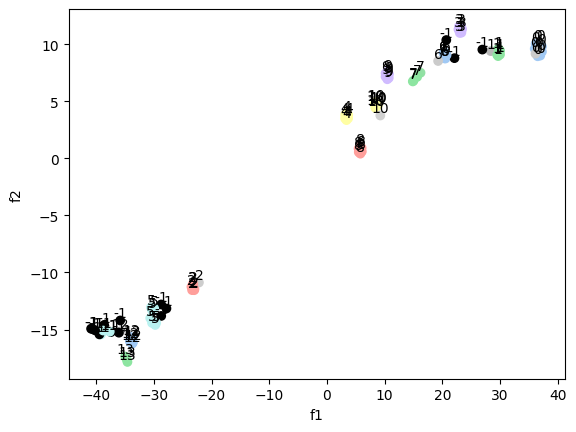

{-1: [30, 31, 33, 35, 61, 62, 66, 82, 83, 86, 88, 89, 91, 96], 0: [7, 17, 27, 37, 47, 57, 67, 77, 87, 97], 1: [9, 19, 29, 32, 49, 59, 79], 2: [4, 14, 24, 34, 44, 54, 74], 3: [0, 10, 20, 40, 50, 70], 4: [1, 11, 21, 41, 51, 71], 5: [36, 60, 80, 90, 92, 93, 98], 6: [3, 13, 23, 43, 53, 63, 73], 7: [38, 39, 69, 99], 8: [2, 12, 22, 42, 52, 72], 9: [5, 15, 25, 45, 55, 75], 10: [8, 18, 28, 48, 58, 68, 78], 11: [65, 85, 95], 12: [6, 16, 26, 46, 56, 76, 81], 13: [64, 84, 94]}
All cluster features are the same: 0
All cluster features are the same: 2
All cluster features are the same: 3
All cluster features are the same: 4
All cluster features are the same: 6
All cluster features are the same: 8
All cluster features are the same: 9
All cluster features are the same: 10
All cluster features are the same: 11
All cluster features are the same: 13
{'5': 2, '6': 2, '9': 2, '3': 8, '4': 2, '8': 2, '0': 5, '7': 2, '1': 7, '2': 7}
dict_values([2, 2, 2, 8, 2, 2, 5, 2, 7, 7])
{'5': 2, '6': 2, '9': 2, '3': 8

/home/chamara/anaconda3/envs/1-poisoning-xai/lib/python3.11/site-packages/torch/nn/modules/module.py:1344: UserWarning:

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.

/home/chamara/anaconda3/envs/1-poisoning-xai/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/home/chamara/anaconda3/envs/1-poisoning-xai/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



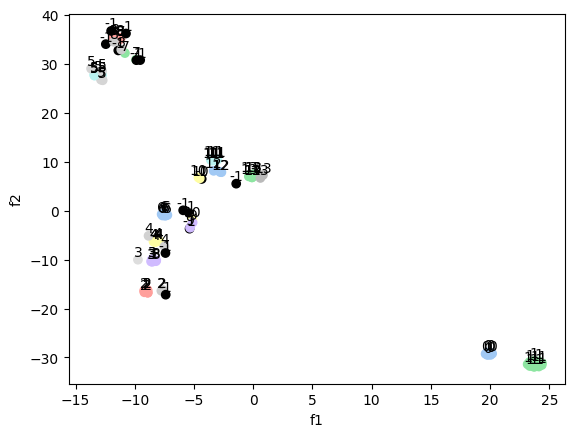

{-1: [30, 39, 60, 61, 63, 65, 80, 82, 89, 90, 92, 95, 96], 0: [8, 18, 28, 48, 58, 78], 1: [7, 17, 27, 37, 47, 57, 67, 77, 87, 97], 2: [0, 10, 20, 32, 40, 50, 70, 88], 3: [9, 19, 29, 31, 49, 59, 79], 4: [3, 13, 23, 43, 53, 62, 73, 85], 5: [4, 14, 24, 34, 44, 54, 64, 74, 84, 94], 6: [2, 12, 22, 42, 52, 72], 7: [35, 36], 8: [6, 16, 26, 46, 56, 66, 76, 86], 9: [69, 99], 10: [33, 83, 93], 11: [5, 15, 25, 45, 55, 75], 12: [38, 68, 98], 13: [1, 11, 21, 41, 51, 71, 81, 91]}
All cluster features are the same: 0
All cluster features are the same: 1
All cluster features are the same: 5
All cluster features are the same: 6
All cluster features are the same: 8
All cluster features are the same: 9
All cluster features are the same: 10
All cluster features are the same: 11
All cluster features are the same: 12
All cluster features are the same: 13
{'5': 3, '6': 3, '9': 3, '3': 6, '4': 3, '8': 3, '0': 5, '7': 3, '1': 5, '2': 4}
dict_values([3, 3, 3, 6, 3, 3, 5, 3, 5, 4])
{'5': 3, '6': 3, '9': 3, '3': 

/home/chamara/anaconda3/envs/1-poisoning-xai/lib/python3.11/site-packages/torch/nn/modules/module.py:1344: UserWarning:

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.

/home/chamara/anaconda3/envs/1-poisoning-xai/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/home/chamara/anaconda3/envs/1-poisoning-xai/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



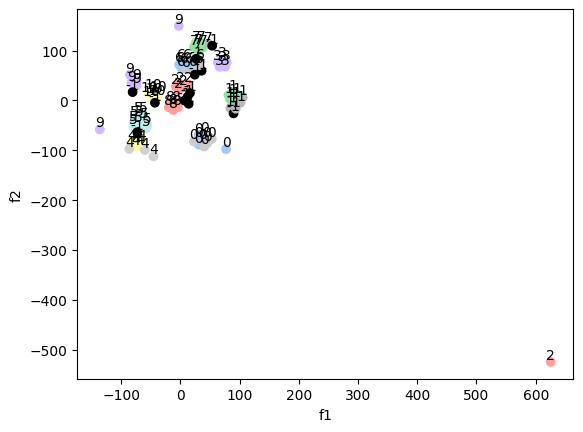

{-1: [32, 35, 64, 80, 81, 82, 84, 85, 93, 94, 96, 99], 0: [7, 17, 27, 37, 47, 57, 67, 77, 87, 89, 97], 1: [6, 16, 26, 30, 33, 36, 38, 46, 56, 76, 86], 2: [5, 15, 25, 45, 55, 75], 3: [9, 19, 29, 49, 59, 79], 4: [0, 10, 20, 40, 50, 60, 62, 68, 70], 5: [39, 63, 69, 83, 88, 90, 91, 92, 95, 98], 6: [1, 11, 21, 31, 41, 51, 61, 65, 66, 71], 7: [4, 14, 24, 34, 44, 54, 74], 8: [2, 12, 22, 42, 52, 72], 9: [8, 18, 28, 48, 58, 78], 10: [3, 13, 23, 43, 53, 73]}
All cluster features are the same: 2
All cluster features are the same: 3
All cluster features are the same: 7
All cluster features are the same: 8
All cluster features are the same: 9
All cluster features are the same: 10
{'5': 4, '6': 4, '9': 4, '3': 9, '4': 4, '8': 4, '0': 10, '7': 4, '1': 10, '2': 10}
dict_values([4, 4, 4, 9, 4, 4, 10, 4, 10, 10])
{'5': 4, '6': 4, '9': 4, '3': 9, '4': 4, '8': 4, '0': 10, '7': 4, '1': 10, '2': 10}
detected:  [3, 6, 8, 9]
original:  []


/home/chamara/anaconda3/envs/1-poisoning-xai/lib/python3.11/site-packages/torch/nn/modules/module.py:1344: UserWarning:

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.

/home/chamara/anaconda3/envs/1-poisoning-xai/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/home/chamara/anaconda3/envs/1-poisoning-xai/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



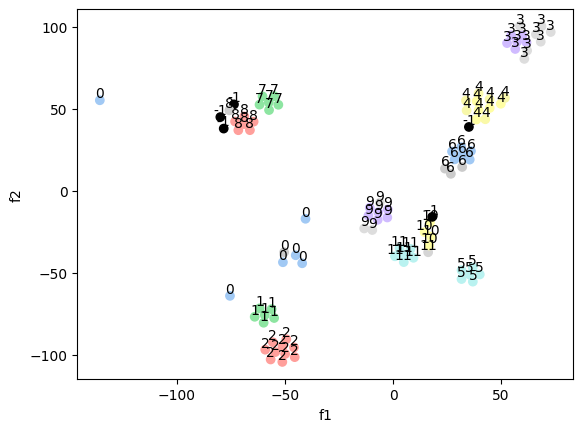

{-1: [39, 62, 83, 92, 99], 0: [3, 13, 23, 43, 53, 73, 82], 1: [9, 19, 29, 49, 59, 79], 2: [7, 17, 27, 37, 47, 57, 67, 77, 87, 97], 3: [6, 16, 26, 34, 46, 56, 65, 66, 76, 81, 84, 86, 96], 4: [31, 35, 36, 60, 63, 64, 68, 85, 88, 89, 94], 5: [4, 14, 24, 44, 54, 74], 6: [1, 11, 21, 38, 41, 51, 71, 91, 95], 7: [5, 15, 25, 45, 55, 75], 8: [8, 18, 28, 48, 58, 78, 93], 9: [0, 10, 20, 30, 40, 50, 70, 80, 90], 10: [33, 61, 69, 98], 11: [2, 12, 22, 32, 42, 52, 72]}
All cluster features are the same: 1
All cluster features are the same: 2
All cluster features are the same: 5
All cluster features are the same: 7
All cluster features are the same: 9
All cluster features are the same: 11
{'5': 4, '6': 4, '9': 4, '3': 7, '4': 4, '8': 4, '0': 9, '7': 4, '1': 8, '2': 8}
dict_values([4, 4, 4, 7, 4, 4, 9, 4, 8, 8])
{'5': 4, '6': 4, '9': 4, '3': 7, '4': 4, '8': 4, '0': 9, '7': 4, '1': 8, '2': 8}
detected:  [3, 6, 8, 9]
original:  []


/home/chamara/anaconda3/envs/1-poisoning-xai/lib/python3.11/site-packages/torch/nn/modules/module.py:1344: UserWarning:

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.

/home/chamara/anaconda3/envs/1-poisoning-xai/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/home/chamara/anaconda3/envs/1-poisoning-xai/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



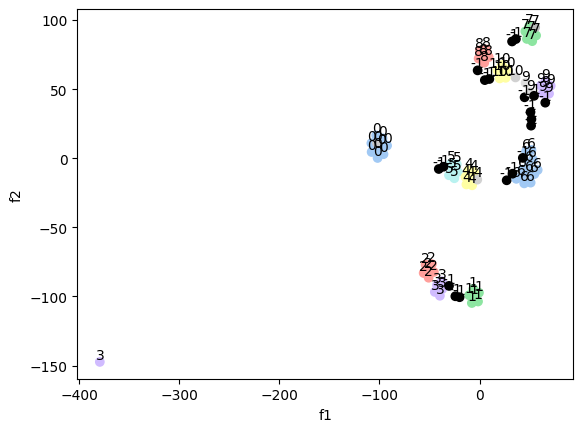

{-1: [31, 34, 36, 61, 62, 63, 66, 68, 69, 80, 82, 84, 89, 90, 91, 94, 95, 96, 99], 0: [7, 17, 27, 37, 47, 57, 67, 77, 87, 97], 1: [6, 16, 26, 46, 56, 76], 2: [5, 15, 25, 45, 55, 75], 3: [1, 11, 21, 41, 51, 71], 4: [3, 13, 23, 43, 53, 73, 83], 5: [9, 19, 29, 49, 59, 79], 6: [30, 32, 33, 35, 39, 60, 65, 81, 88, 92, 93, 98], 7: [4, 14, 24, 44, 54, 64, 74], 8: [2, 12, 22, 42, 52, 72], 9: [0, 10, 20, 40, 50, 70, 85, 86], 10: [8, 18, 28, 38, 48, 58, 78]}
All cluster features are the same: 0
All cluster features are the same: 1
All cluster features are the same: 2
All cluster features are the same: 3
All cluster features are the same: 4
All cluster features are the same: 5
All cluster features are the same: 7
All cluster features are the same: 8
All cluster features are the same: 10
{'5': 1, '6': 1, '9': 1, '3': 8, '4': 1, '8': 1, '0': 8, '7': 1, '1': 8, '2': 9}
dict_values([1, 1, 1, 8, 1, 1, 8, 1, 8, 9])
{'5': 1, '6': 1, '9': 1, '3': 8, '4': 1, '8': 1, '0': 8, '7': 1, '1': 8, '2': 9}
detecte

In [341]:
sample_count_for_test = 100
sample_count_for_plot = 1
total_rounds = 10
total_labels_per_client = 10
client_updates_list = client_updates_list_nw2
target_clients = list(client_updates_list_nw2[0].keys())

testloader = get_testloader(len_test=sample_count_for_test+sample_count_for_plot*2, batch_size=sample_count_for_test+sample_count_for_plot*2, 
                            shuffle=True)
batch = next(iter(testloader))
images, actual_out = batch
background = images[:sample_count_for_test]
test_images = images[sample_count_for_test:sample_count_for_test + sample_count_for_plot]

total_detected_poison_idxes = []

for cli_round in range(total_rounds):
    shap_feature_ori_list_all = []
    round_no = cli_round
    shap_feature_ori_list_all = []
    
    for cli in target_clients:
        target_client_id = cli
        mdl_0 = get_mdl_of_client_at_round(target_client_id=target_client_id, round_no=round_no,
                                           client_updates_list=client_updates_list)
        e = shap.DeepExplainer(mdl_0, background)
        shap_values = e.shap_values(test_images)
        shap_vals_all_flattened = []
        for pred in shap_values:
            for j in pred:
                shap_vals_all_flattened.append(j.flatten())
        shap_feature_ori_list_all.append(shap_vals_all_flattened)
    shap_feature_list = shap_feature_ori_list_all
    shap_feature_per_client = []
    for i in range(len(target_clients)):
        for j in range(sample_count_for_plot*total_labels_per_client):
            shap_feature_per_client.append(shap_feature_list[i][j])
    # print(len(shap_feature_per_client))
    min_cluster_size = 2
    epsilon = 0.011
    # epsilon = 0.0
    hdbscan_labels, hdbscan_clusterer, colors = run_hdbscan_clustering_algorithm(
            input_feature_list=shap_feature_per_client, min_cluster_size=min_cluster_size, epsilon=epsilon)
    # print(hdbscan_labels)
    perplexity = 10
    visualise_clusters_with_tsne(input_feature_list=shap_feature_per_client, label_list=hdbscan_labels,
                                     label_colors=colors, perplexity=perplexity,
                                     show_malicious_items=False, malicious_start_idx=None,
                                     malicious_end_idx=None, show_labels=True)
    poison_idxes = general_algorithm_main_calc2(client_updates_list, total_labels_per_client*sample_count_for_plot, hdbscan_labels)
    total_detected_poison_idxes.append(poison_idxes)

In [316]:
'''main algorithm for new general poisoning detection'''
def general_algorithm_main_calc2(client_updates_list, total_labels_per_client, hdbscan_labels, poisoner_ct=0):
    target_clients = list(client_updates_list[0].keys())
    # print(target_clients)
    # get all cluster ids, ignore -1 cluster id
    all_clusters_ids = np.unique(hdbscan_labels)
    # if np.any(all_clusters_ids == 0):
    #     all_clusters_ids = all_clusters_ids[all_clusters_ids != 0]

    # create an empty dict of arrays to get the positions for each features to be calculated for suspicious counts
    feature_positions = {}
    for i in all_clusters_ids:
        feature_positions[i] = []

    for i in range(len(hdbscan_labels)):
        if hdbscan_labels[i] in feature_positions.keys():
            feature_positions[hdbscan_labels[i]].append(i)
            
    # ## patch to remove outliers       
    # for key, value_list in list(feature_positions.items()):
    #     if len(value_list) > 200:
    #         # Remove the key-value pair if the length is greater than 200
    #         del feature_positions[key]
        
    print(feature_positions)
    diff_idxes_all = []

    # Main algorithm to detect poisoners: compare feature repetitions within the same cluster.
    # If different features are present, possible poisoning alert
    for i in all_clusters_ids:
        # print(i)
        # List of numbers
        numbers = feature_positions[i]
        # print(len(numbers))
        # if len(numbers)>200:
        #     pass
        # Find the remainder when each number is divided by total output features/labels per client
        remainders = [num % total_labels_per_client for num in numbers]

        # Check if all the remainders are the same
        if all(remainder == remainders[0] for remainder in remainders):
            print("All cluster features are the same:", i)
        else:
            # print("Not all features are the same. Possible poisoning")
            # Find and isolate the numbers with different remainders
            different_idxes = [num for num, remainder in zip(numbers, remainders) if remainder != remainders[0]]
            # print("Cluster with different features:", different_idxes)
            # print(numbers)
            diff_idxes_all.extend(numbers)

    sus_ct = {}

    for i in list(target_clients):
        sus_ct[i] = 0
    

    # add a suspicious score for each client
    for i in diff_idxes_all:
        sus_client_position = i // (total_labels_per_client)
        sus_client = target_clients[sus_client_position]
        sus_ct[sus_client] += 1

    print(sus_ct)
    print(sus_ct.values())
    total_sus_ct = sum(sus_ct.values())
    # total_sus_ct = sum(list(sus_ct.values))
    # total_sus_cli = sum(1 for value in sus_ct.values() if value > 0)
    total_cli = len(list(client_updates_list[0].keys()))
    
    print(sus_ct)  # this is what we want!!

    # detecting poison clients
    poison_clients = []
    
    for key, value in sus_ct.items():
        # if value >= total_labels_per_client / 2:
        if value >= int(total_sus_ct/total_cli):
            poison_clients.append(key)  # CONVERTING TO AN INTEGER CAN BE A POTENTIAL BUG - yes it is, so eliminated!!!

    poison_idxes = []
    idxes_to_remove = list(client_updates_list[0].keys())
    for i in poison_clients:
        poison_idxes.append(idxes_to_remove.index(i))

    print('detected: ', poison_idxes)
    debugging_enabled = False
    poison_idx_viewing = True
    if poison_idx_viewing:
        # debugging operation (should update)
        my_list = list(client_updates_list[0].keys())
        values_to_find = [str(i) for i in range(poisoner_ct)]
        # values_to_find = ['1', '2', '3','4','5','6','7','8','9','10']
        values_to_find = ['1', '2', '3', '4', '5']

        # Find the indexes of the values in the list
        indexes = [i for i, value in enumerate(my_list) if value in values_to_find]
        print('original: ', indexes)
        if debugging_enabled:
            return indexes
    return poison_idxes

### Testing SHIELD

In [348]:
import hdbscan
def get_flattened_weights(model):
    """
    Extract and flatten the weight parameters of a PyTorch model.

    Args:
    - model (torch.nn.Module): PyTorch model.

    Returns:
    - flattened_weights (np.ndarray): Flattened weight parameters.
    """
    weights = []
    for param in model.parameters():
        weights.append(param.data.cpu().numpy().flatten())
    flattened_weights = np.concatenate(weights)
    return flattened_weights

def chunk_list(lst, num_chunks):
    avg_chunk_size = len(lst) // num_chunks
    remainder = len(lst) % num_chunks

    chunks = []
    start = 0
    chunk_size = len(lst) // num_chunks
    chunks = [lst[i * chunk_size:(i + 1) * chunk_size] for i in range(num_chunks)]
    return chunks

def chunk_2d_list(lst, num_chunks):
    chunked_2d_list = []
    for inner_lst in lst:
        chunks = chunk_list(inner_lst, num_chunks)
        chunked_2d_list.extend(chunks)
    return chunked_2d_list

In [343]:
def get_flattened_client_models(client_updates_list, aggregated_updates_list, round_no):
    updates_list = client_updates_list[round_no]
    client_ids = list(updates_list.keys())
    
    all_models = []
    
    for i in range(len(client_ids)):
        mdl = get_mdl_from_weights(updates_list[client_ids[i]][0])
        flattened_mdl = get_flattened_weights(mdl)
        all_models.append(flattened_mdl)
    
    aggregated_mdls = []
    
    for i in range(len(aggregated_updates_list)):
        mdl = get_mdl_from_weights(aggregated_updates_list[i])
        flattened_mdl = get_flattened_weights(mdl)
        aggregated_mdls.append(flattened_mdl)
    return all_models, aggregated_mdls

In [344]:
# special operation to add initial version of the global model from a trusted client
def add_initial_benign_model(client_updates_list, aggregated_updates_list, num_poison):
    initial_round_local_mdls = client_updates_list[0]
    aggregated_updates_list_2 = [i for i in aggregated_updates_list]
    if num_poison<len(initial_round_local_mdls):
        next_ben_idx = num_poison+1
        aggregated_updates_list.append(initial_round_local_mdls[str(next_ben_idx)][0])
        return aggregated_updates_list
    else:
        raise ValueError('No benign clients to get the initial benign model')

In [345]:
def calc_acc_rates(predicted_poisoners, actual_poisoners, all_clients, is_print=True):
    # Calculate TP, FP, FN
    tp = len(set(predicted_poisoners) & set(actual_poisoners))
    fp = len(set(predicted_poisoners) - set(actual_poisoners))
    fn = len(set(actual_poisoners) - set(predicted_poisoners))
    
    # For TN, we need to define a universal set. Let's assume a universal set U that includes all predicted and actual elements.
    # This assumption may vary based on the actual problem context.
    universal_set = all_clients
    
    # TN is the count of elements in the universal set that are not in either predicted_poisoners or actual_poisoners
    tn = len(universal_set) - (tp + fp + fn)
    
    # Calculate accuracy
    accuracy = (tp + tn) / (tp + fp + fn + tn)
    if is_print:
        print(f"TP: {tp}")
        print(f"FP: {fp}")
        print(f"FN: {fn}")
        print(f"TN: {tn}")
        print(f"Accuracy: {accuracy:.2f}")
    return tp, tn, fp, fn, accuracy

In [346]:
def run_one_round(client_updates_list, aggregated_updates_list, curr_round_no):
    # special operation to add benign model
    aggregated_updates_list_ = add_initial_benign_model(client_updates_list, aggregated_updates_list,num_poison)
    aggregated_updates_list_ = aggregated_updates_list
    all_models, aggregated_mdls = get_flattened_client_models(client_updates_list, aggregated_updates_list_, curr_round_no)
    
    clusterer = hdbscan.HDBSCAN(min_cluster_size=2, metric='euclidean', cluster_selection_method='leaf')
    clusterer.fit(all_models)
    unique_clusters = np.unique(clusterer.labels_)

    within_group_averages = []
    group_euc_dists_mean = []
    indices_all = []
    central_model0 = aggregated_mdls[curr_round_no]
    groups_all = []
    
    for j in unique_clusters:
        indices = np.where(clusterer.labels_ == j)[0]
        indices_all.append(indices)
        group = [all_models[i] for i in indices]
        groups_all.append(group)
        group_avg = np.mean(group, axis=0)
        within_group_averages.append(group_avg)
        euc_dists = []
        for l in range(len(group)):
            eu_dist = np.linalg.norm(group[l] - central_model0, ord=2) # getting l2 norm
            euc_dists.append(eu_dist)
        group_euc_dists_mean.append(np.mean(euc_dists))
    min_index_group_euc_dists = group_euc_dists_mean.index(min(group_euc_dists_mean))
    print('benign group:', min_index_group_euc_dists)
    l0_avg1 = within_group_averages[min_index_group_euc_dists]
    
    client_ids = list(client_updates_list[curr_round_no].keys())
    benign_group = indices_all[min_index_group_euc_dists]
    predicted_poisoners = [client_ids[i] for i in range(len(client_ids)) if i not in benign_group]
    actual_poisoners = [i for i in client_ids if i in [str(j) for j in range(num_poison)]]
    
    return l0_avg1, benign_group, predicted_poisoners, actual_poisoners

In [357]:
for i in range(10):
    curr_round_no=i
    _, benign_group, predicted_poisoners, actual_poisoners = run_one_round(client_updates_list=client_updates_list_nw2, 
                                                                           aggregated_updates_list=aggregated_updates_list,
                                                                           curr_round_no=curr_round_no)
    
    print(predicted_poisoners)

benign group: 0
[]
benign group: 1
['6', '2', '9', '7', '8', '4', '5']
benign group: 0
[]
benign group: 0
[]
benign group: 0
[]
benign group: 0
['0', '8', '5', '4', '6', '2', '1', '9', '7']
benign group: 0
[]
benign group: 0
[]
benign group: 0
[]
benign group: 0
[]


### Testing Krum

In [362]:
from src.FLProcess.CustomKrum import aggregate_krum_custom

In [370]:
weights_results_krum = list(client_updates_list_nw2[0].values())

In [382]:
for i in range(10):
    weights_results_krum = list(client_updates_list_nw2[i].values())
    weights, indices = aggregate_krum_custom(
                weights_results_krum, num_malicious=5, to_keep=5, is_removing_poisoners=False
            )
    print(indices)

[5 4 2 1 0]
[7 6 5 4 1]
[8 7 6 1 0]
[7 6 5 4 2]
[8 5 3 2 0]
[8 5 4 3 1]
[7 6 4 2 0]
[7 6 5 4 2]
[8 6 2 1 0]
[8 7 6 5 4]


### Testing trim mean

In [161]:
mdls[0]

Net_MNIST(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [221]:
def trimmed_mean(models, trim_percent):
    """
    Perform trimmed mean aggregation on a list of models' gradients or parameters layer by layer.
    
    Args:
    - models: List of models (or gradients) to aggregate.
    - trim_percent: The percentage of highest and lowest gradients to trim.
    
    Returns:
    - trimmed_mean_model: Aggregated model based on trimmed mean.
    - suspicious_indices: Indices of models that were trimmed as suspicious.
    """
    num_models = len(models)
    trim_count = int(trim_percent * num_models // 2)

    # Initialize a new model for trimmed mean result
    trimmed_mean_model = models[0]
    
    suspicious_indices = set()

    # Perform trimming layer by layer
    with torch.no_grad():
        for layer_idx, params in enumerate(trimmed_mean_model.parameters()):
            # Stack parameters for the current layer across all models
            layer_params = torch.stack([model.parameters()[layer_idx].clone().detach() for model in models], dim=0)
            
            # Sort the parameters along the model dimension (dim=0)
            sorted_params, indices = torch.sort(layer_params, dim=0)
            
            # Trim the highest and lowest percentages
            trimmed_params = sorted_params[trim_count:-trim_count]
            
            # Calculate the trimmed mean for this layer
            trimmed_mean_params = torch.mean(trimmed_params, dim=0)
            
            # Update the parameters of the trimmed mean model
            params.copy_(trimmed_mean_params)

            # Track which models were trimmed
            suspicious_indices.update(indices[:trim_count].flatten().tolist())
            suspicious_indices.update(indices[-trim_count:].flatten().tolist())

    return trimmed_mean_model, list(suspicious_indices)

In [222]:
trim_percent = 0.2
trimmed_mean_model, suspicious_models = trimmed_mean(mdls, trim_percent)

print("Suspicious model indices (trimmed):", suspicious_models)
print("Trimmed Mean Model parameters:")
for param in trimmed_mean_model.parameters():
    print(param)

TypeError: 'generator' object is not subscriptable

In [627]:
test_mdl = mdls[0]

In [632]:
torch.stack([p.clone().detach().view(-1) for p in test_mdl.parameters()])

RuntimeError: stack expects each tensor to be equal size, but got [288] at entry 0 and [32] at entry 1

In [633]:
test_mdl

Net_MNIST(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

## Old

In [39]:
# Transformations
transform = transforms.Compose([transforms.ToTensor()])

# Load MNIST Dataset
train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False)


In [45]:
images, labels = next(iter(test_loader))
image = images[0].unsqueeze(0) 
np.shape(image.to(constants.DEVICE))

torch.Size([1, 1, 28, 28])

In [52]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten the input
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize model, loss, and optimizer
model = SimpleNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [53]:
# Training Loop (for demonstration, keep it simple)
def train_model(model, train_loader, criterion, optimizer, epochs=1):
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}')

# Train the model (adjust epochs as needed)
train_model(model, train_loader, criterion, optimizer, epochs=1)


Epoch 1, Loss: 0.3536928052674415


In [54]:
# Select an image from the test dataset
images, labels = next(iter(test_loader))
image = images[0].unsqueeze(0)  # Select the first image from the batch

# Set model to evaluation mode
model.eval()

# Initialize LayerLRP for the first fully connected layer (fc1)
layer_lrp_fc1 = LayerLRP(model, model.fc1)

# Compute the relevance score for the selected image and target label (for this example, using the ground truth label)
target_label = labels[0].item()
attributions_fc1 = layer_lrp_fc1.attribute(image, target=target_label)

# Initialize LayerLRP for the second fully connected layer (fc2)
layer_lrp_fc2 = LayerLRP(model, model.fc2)
attributions_fc2 = layer_lrp_fc2.attribute(image, target=target_label)

# Convert attributions to numpy for visualization
attributions_fc1_np = attributions_fc1.detach().numpy().squeeze()
attributions_fc2_np = attributions_fc2.detach().numpy().squeeze()

# # Visualize the relevance scores
# plt.figure(figsize=(10, 5))

# plt.subplot(1, 2, 1)
# plt.title('LRP for fc1 Layer')
# plt.imshow(attributions_fc1_np.reshape(28, 28), cmap='hot', interpolation='nearest')
# plt.colorbar()

# plt.subplot(1, 2, 2)
# plt.title('LRP for fc2 Layer')
# plt.imshow(attributions_fc2_np.reshape(28, 28), cmap='hot', interpolation='nearest')
# plt.colorbar()

# plt.show()


In [55]:
np.shape(attributions_fc1_np)

(128,)

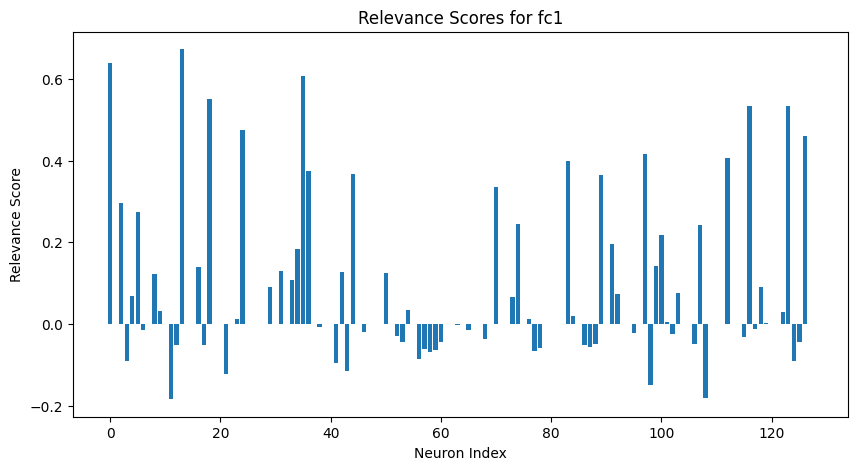

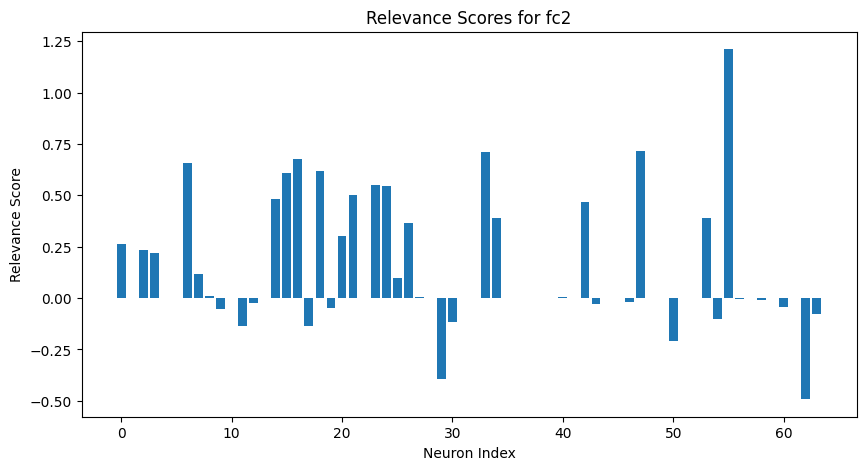

In [56]:
# Import necessary captum tools
from captum.attr import LayerAttribution

# Propagate the attributions back to the input space
import matplotlib.pyplot as plt

def visualize_fc_layer_attributions(attributions, layer_name):
    # Convert attributions to numpy array
    attributions_np = attributions.detach().numpy().squeeze()
    
    # Create a bar plot of the attributions
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(attributions_np)), attributions_np)
    plt.title(f'Relevance Scores for {layer_name}')
    plt.xlabel('Neuron Index')
    plt.ylabel('Relevance Score')
    plt.show()

# Visualize for fc1
visualize_fc_layer_attributions(attributions_fc1, 'fc1')

# Visualize for fc2
visualize_fc_layer_attributions(attributions_fc2, 'fc2')

# Let's visualize the attribution back to the input for fc1
# visualize_layer_attributions_back_to_input(attributions_fc1, 'fc1', image, target_label)

# And also for fc2
# visualize_layer_attributions_back_to_input(attributions_fc2, 'fc2', image, target_label)


In [437]:
## trying conv model

In [57]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from captum.attr import LayerLRP
import matplotlib.pyplot as plt

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(-1, 64 * 7 * 7)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize model, loss, and optimizer
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [58]:
# Training Loop
def train_model(model, train_loader, criterion, optimizer, epochs=1):
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}')

# Train the model
train_model(model, train_loader, criterion, optimizer, epochs=1)


Epoch 1, Loss: 0.17717828822266588


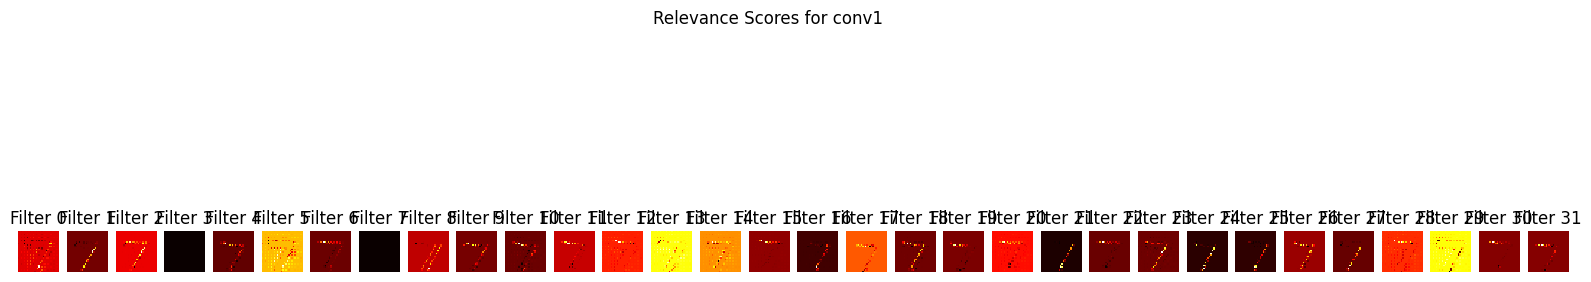

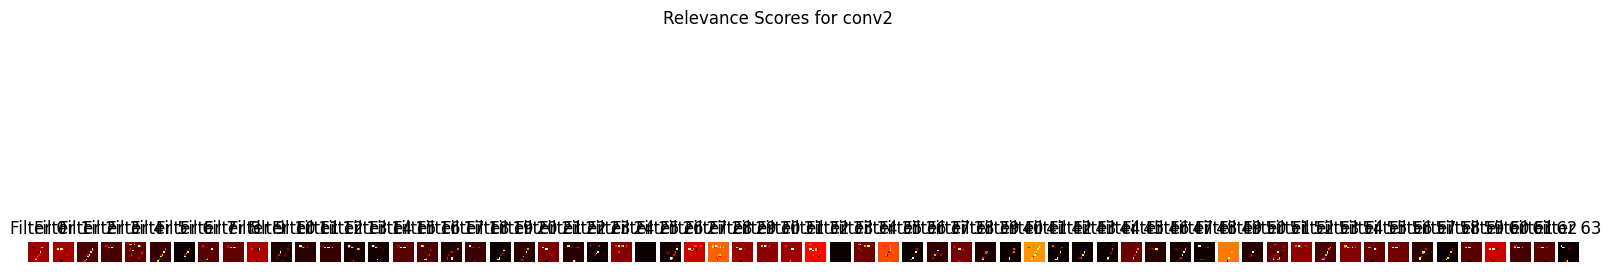

In [59]:
from captum.attr import LayerLRP

# Select an image from the test dataset
images, labels = next(iter(test_loader))
image = images[0].unsqueeze(0)  # Select the first image from the batch

# Set model to evaluation mode
model.eval()

# Initialize LayerLRP for conv1 layer
layer_lrp_conv1 = LayerLRP(model, model.conv1)
attributions_conv1 = layer_lrp_conv1.attribute(image, target=labels[0].item())

# Initialize LayerLRP for conv2 layer
layer_lrp_conv2 = LayerLRP(model, model.conv2)
attributions_conv2 = layer_lrp_conv2.attribute(image, target=labels[0].item())

# Convert attributions to numpy for visualization
attributions_conv1_np = attributions_conv1.detach().numpy().squeeze()
attributions_conv2_np = attributions_conv2.detach().numpy().squeeze()

import torch

def visualize_conv_layer_attributions(attributions, layer_name):
    # Check if attributions are NumPy arrays, convert to PyTorch tensors if so
    if isinstance(attributions, np.ndarray):
        attributions = torch.tensor(attributions)
    
    # Add a batch dimension if it's missing
    if attributions.ndimension() == 3:
        attributions = attributions.unsqueeze(0)  # Add batch dimension

    # Ensure attributions are in the correct shape (N, C, H, W)
    if len(attributions.shape) != 4:
        raise ValueError(f'Expected 4D tensor, but got shape: {attributions.shape}')
    
    num_filters = attributions.shape[1]
    fig, axes = plt.subplots(1, num_filters, figsize=(20, 5))
    
    if num_filters == 1:
        axes = [axes]  # Ensure axes is iterable if there's only one filter
    
    for i in range(num_filters):
        # Each filter’s relevance should be a 2D array (H, W)
        filter_attribution = attributions[0, i].detach().numpy()  # Convert to NumPy array
        
        # Check shape and reshape if necessary
        if filter_attribution.ndim != 2:
            filter_attribution = filter_attribution.squeeze()
        
        # Plot each filter's relevance
        axes[i].imshow(filter_attribution, cmap='hot', interpolation='nearest')
        axes[i].set_title(f'Filter {i}')
        axes[i].axis('off')
    
    plt.suptitle(f'Relevance Scores for {layer_name}')
    plt.show()

# Example usage with convolutional layers
visualize_conv_layer_attributions(attributions_conv1_np, 'conv1')
visualize_conv_layer_attributions(attributions_conv2_np, 'conv2')


In [60]:
np.shape(attributions_conv2_np)

(64, 14, 14)

## Custom LRP rule

In [463]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MNIST_CNN(nn.Module):
    def __init__(self):
        super(MNIST_CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # Input: 28x28x1, Output: 28x28x32
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # Input: 28x28x32, Output: 28x28x64
        self.pool = nn.MaxPool2d(2, 2)  # Halves the size
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Input: 64*7*7, Output: 128
        self.fc2 = nn.Linear(128, 10)  # Output: 10 (MNIST classes)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # After conv1 and pool: 14x14x32
        x = self.pool(F.relu(self.conv2(x)))  # After conv2 and pool: 7x7x64
        x = x.view(-1, 64 * 7 * 7)  # Flatten for fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = MNIST_CNN()


In [464]:
from captum.attr import LayerLRP
import torch

class AlphaBetaLRP(LayerLRP):
    def __init__(self, model, layer, alpha=1, beta=0):
        super().__init__(model, layer)
        self.alpha = alpha
        self.beta = beta

    def custom_lrp_rule(self, layer_input, layer_output, relevance):
        # Alpha-Beta rule: separate positive and negative contributions
        positive_contrib = torch.clamp(layer_input, min=0) * relevance  # Only positive relevance
        negative_contrib = torch.clamp(layer_input, max=0) * relevance  # Only negative relevance
        
        return self.alpha * positive_contrib + self.beta * negative_contrib

    def attribute(self, inputs, target=None, *args, **kwargs):
        # Call LayerLRP's attribute method to compute the relevance
        relevances = super().attribute(inputs, target=target, *args, **kwargs)
        
        # Apply custom alpha-beta rule
        for i in range(relevances.shape[1]):  # Iterate through each channel (filter)
            relevances[:, i, :, :] = self.custom_lrp_rule(inputs, inputs, relevances[:, i, :, :])
        
        return relevances


In [465]:
# Assuming MNIST dataset is loaded and a trained model exists
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

# MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
mnist_test = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = DataLoader(mnist_test, batch_size=1, shuffle=True)

# Get a sample image
# data_iter = iter(test_loader)
# inputs, target = data_iter.next()

# Pass the input through the model (assuming model is trained)
# model.eval()
# outputs = model(inputs)
# Select an image from the test dataset
inputs, target = next(iter(test_loader))
image = images[0].unsqueeze(0)  # Select the first image from the batch

# Set model to evaluation mode
model.eval()

MNIST_CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [466]:
# Apply Alpha-Beta LRP to conv1
alpha_beta_lrp_conv1 = AlphaBetaLRP(model, model.conv1, alpha=1, beta=0)  # Alpha-Beta LRP for conv1
attributions_conv1 = alpha_beta_lrp_conv1.attribute(inputs, target=torch.argmax(outputs))

# Apply Alpha-Beta LRP to conv2
alpha_beta_lrp_conv2 = AlphaBetaLRP(model, model.conv2, alpha=1, beta=0)  # Alpha-Beta LRP for conv2
attributions_conv2 = alpha_beta_lrp_conv2.attribute(inputs, target=torch.argmax(outputs))


RuntimeError: Module MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) is being used more than once in the network, which is not supported by LRP. Please ensure that module is being used only once in the network.

In [450]:
from captum.attr import LayerAttribution
import torch

class CustomLRP(LayerAttribution):
    def __init__(self, model, layer):
        super().__init__(model, layer)
    
    def custom_lrp_rule(self, layer_input, layer_output, relevance):
        # Implement your custom rule (alpha-beta, gamma, etc.)
        # Example: alpha-beta rule:
        positive_contrib = torch.clamp(layer_input, min=0) * relevance
        negative_contrib = torch.clamp(layer_input, max=0) * relevance
        return positive_contrib - negative_contrib

    def attribute(self, inputs, target=None, *args, **kwargs):
        # Get the forward pass outputs
        layer_outputs = self.forward(inputs)

        # Compute initial relevance (can be target output, etc.)
        initial_relevance = layer_outputs.clone()

        # Apply the custom LRP rule layer by layer
        for i, layer_output in enumerate(layer_outputs):
            initial_relevance = self.custom_lrp_rule(inputs, layer_output, initial_relevance)

        return initial_relevance


In [453]:
# Instantiate your custom LRP class
alpha_beta_lrp = AlphaBetaLRP(model, model.conv2, alpha=1, beta=0)

# Compute attributions using the custom LRP rule
attributions = alpha_beta_lrp.attribute(image, target=labels[0].item())


RuntimeError: The size of tensor a (28) must match the size of tensor b (14) at non-singleton dimension 3

In [94]:
# test_data_0 = testloaders.dataset[0][0].to(constants.DEVICE)

In [95]:
# # cli_0_mdl(test_data_0)
# test_data_0 = testloaders.dataset[0][0].to(constants.DEVICE)
# cli_0_mdl.eval()
# with torch.no_grad():
#     for images, labels in testloaders:
#         images, labels = images.to(constants.DEVICE), labels.to(constants.DEVICE)
#         # print(type(images))
#         print(np.shape(images))
#         outputs = cli_0_mdl(images)
#         break

In [96]:
# outputs

In [108]:
cf_data = np.array([[cfs]])
cf_data_t = torch.tensor(cf_data).to(constants.DEVICE)
ori_data = np.array([[ori]])
ori_data_t = torch.tensor(ori_data).to(constants.DEVICE)

In [115]:
cli_0_mdl(ori_data_t)

tensor([[-9.0285e+00, -7.4189e+00, -5.4346e+00, -5.9643e+00, -8.2406e+00,
         -1.0563e+01, -1.2655e+01, -1.0472e-02, -9.6874e+00, -6.0277e+00]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward0>)

In [117]:
cli_0_mdl(cf_data_t)

tensor([[-3.4889, -6.8626, -2.2982, -0.3627, -7.2540, -4.1161, -8.9115, -2.0321,
         -5.4002, -3.9404]], device='cuda:0', grad_fn=<LogSoftmaxBackward0>)

### LRP test

In [100]:
import lrp.plot
from lrp import image, rules
from lrp.core import LRP
from lrp.filter import LayerFilter
from lrp.rules import LrpEpsilonRule, LrpGammaRule, LrpZBoxRule, LrpZeroRule
from lrp.zennit.types import AvgPool, Linear

In [101]:
import torch.nn as nn

class WrappedNetMNIST(nn.Module):
    def __init__(self, original_model):
        super(WrappedNetMNIST, self).__init__()
        # Define the features and classifier based on the original model
        self.features = nn.Sequential(
            original_model.conv1,
            nn.ReLU(),
            original_model.conv2,
            nn.ReLU(),
            nn.MaxPool2d(2),
            original_model.dropout1
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            original_model.fc1,
            nn.ReLU(),
            original_model.dropout2,
            original_model.fc2,
            nn.LogSoftmax(dim=1)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [114]:
cli_0_mdl = WrappedNetMNIST(cli_0_mdl)

In [118]:
# Low and high parameters for zB-rule
from typing import Callable, Dict, List, Tuple, Union

batch_size: int = 1
shape: Tuple[int] = (batch_size, 1, 28, 28)  # MNIST images are 28x28 pixels

low: torch.Tensor = torch.zeros(*shape)
high: torch.Tensor = torch.ones(*shape)

# Init layer filter
target_types: Tuple[type] = (torch.nn.Conv2d, torch.nn.Linear)
filter_by_layer_index_type: LayerFilter = LayerFilter(model=cli_0_mdl, target_types=target_types)

name_map: List[Tuple[List[str], rules.LrpRule, Dict[str, Union[torch.Tensor, float]]]]

# LRP Composite adapted for Net_MNIST
name_map = [
    # Apply LrpZBoxRule to the first convolutional layer (conv1)
    (filter_by_layer_index_type(lambda n: n == 0), LrpZBoxRule, {'low': low, 'high': high}),
    
    # Apply LrpGammaRule to the second convolutional layer (conv2)
    (filter_by_layer_index_type(lambda n: 1), LrpGammaRule, {'gamma': 0.25}),
    
    # Apply LrpEpsilonRule to the first fully connected layer (fc1)
    (filter_by_layer_index_type(lambda n: 3), LrpEpsilonRule, {'epsilon': 0.25}),
    
    # Apply LrpZeroRule to the output layer (fc2)
    (filter_by_layer_index_type(lambda n: 4), LrpZeroRule, {}),
]

# Init LRP
lrp_instance: LRP = LRP(cli_0_mdl)

# Prepare model layers for LRP
lrp_instance.convert_layers(name_map)

# Compute relevance attributions
# R: torch.Tensor = lrp_instance.relevance(X)

# Display heatmap
# lrp_instance.heatmap(R, width=2, height=2)

Finished 'relevance' in 0.0053 secs


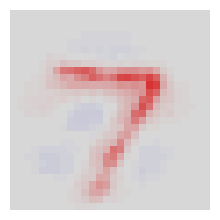

In [124]:
# Fetch a single batch from the testloader
# data_iter = iter(testloaders)
# data, target = next(data_iter)

# Move data to the appropriate device (e.g., GPU if available)
# data = data.to(constants.DEVICE)
# target = target.to(constants.DEVICE)

# Forward pass: Get the model's prediction
output = cli_0_mdl(ori_data_t)
# Compute relevance for the batch
relevance_ori = lrp_instance.relevance(ori_data_t)

# Visualize the relevance for the first sample in the batch
lrp_instance.heatmap(relevance_ori, width=2, height=2)

Finished 'relevance' in 0.0053 secs


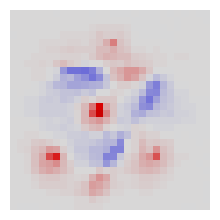

In [125]:
# Fetch a single batch from the testloader
# data_iter = iter(testloaders)
# data, target = next(data_iter)

# Move data to the appropriate device (e.g., GPU if available)
# data = data.to(constants.DEVICE)
# target = target.to(constants.DEVICE)

# Forward pass: Get the model's prediction
output = cli_0_mdl(cf_data_t)
# Compute relevance for the batch
relevance_cf = lrp_instance.relevance(cf_data_t)

# Visualize the relevance for the first sample in the batch
lrp_instance.heatmap(relevance_cf, width=2, height=2)

In [229]:
def calculate_neuron_importance(model, input_relevance_scores):
    model.eval()  # Set model to evaluation mode
    
    # Initialize dictionaries to hold neuron importance and layer-wise activations
    neuron_importance = {}
    
    # Forward pass to get layer outputs
    def forward_hook(module, input, output):
        if isinstance(module, nn.Linear):
            # Calculate neuron importance for the current layer
            with torch.no_grad():
                # Get input activations
                input_activations = input[0]
                
                # Compute relevance propagation
                if module in layer_inputs:
                    previous_layer_relevance = layer_inputs[module]
                else:
                    previous_layer_relevance = input_relevance_scores

                # Calculate neuron importance for this layer
                weights = module.weight.data
                relevance_scores = torch.matmul(previous_layer_relevance, weights.T)
                
                for i, neuron in enumerate(module.out_features):
                    neuron_importance[(module, i)] = relevance_scores[:, i].sum().item()
                
                # Prepare for the next layer
                layer_inputs[module] = relevance_scores
    
    layer_inputs = {}
    hooks = []
    
    # Register forward hooks to capture intermediate activations
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            hook = module.register_forward_hook(forward_hook)
            hooks.append(hook)
    
    # Pass dummy data to activate the forward hooks
    dummy_input = torch.randn(1, input_relevance_scores.size(1))  # Adjust size as needed
    with torch.no_grad():
        _ = model(dummy_input)
    
    # Remove hooks
    for hook in hooks:
        hook.remove()
    
    return neuron_importance


In [233]:
relevance_cf.size()

torch.Size([1, 1, 28, 28])

In [230]:
def calculate_weight_importance(model, neuron_importance):
    weight_importance = {}
    
    # Compute weight importance based on neuron importance
    with torch.no_grad():
        for name, module in model.named_modules():
            if isinstance(module, nn.Linear):
                weights = module.weight.data
                for i in range(weights.size(0)):  # Output neurons
                    for j in range(weights.size(1)):  # Input neurons
                        weight_key = (j, i)
                        if weight_key in weight_importance:
                            weight_importance[weight_key] += neuron_importance[(module, i)] * weights[i, j].item()
                        else:
                            weight_importance[weight_key] = neuron_importance[(module, i)] * weights[i, j].item()
    
    return weight_importance


In [231]:
# Calculate neuron importance
neuron_importance = calculate_neuron_importance(cli_0_mdl, relevance_cf)

# Calculate weight importance
weight_importance = calculate_weight_importance(cli_0_mdl, neuron_importance)

print("Neuron Importance:", neuron_importance)
print("Weight Importance:", weight_importance)


RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [1, 1]

In [319]:
# relevance_ori

In [134]:
# relevance_cf

Finished 'relevance' in 0.0040 secs


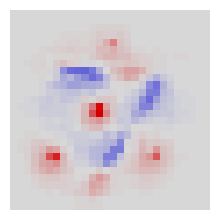

In [131]:
# Fetch a single batch from the testloader
# data_iter = iter(testloaders)
# data, target = next(data_iter)

# Move data to the appropriate device (e.g., GPU if available)
# data = data.to(constants.DEVICE)
# target = target.to(constants.DEVICE)

# Forward pass: Get the model's prediction
output = cli_0_mdl(cf_data_t)
# Compute relevance for the batch
relevance_cf = lrp_instance.relevance(cf_data_t)

# Visualize the relevance for the first sample in the batch
lrp_instance.heatmap(relevance_cf-relevance_ori, width=2, height=2)

In [226]:
np.shape(relevance_cf)

torch.Size([1, 1, 28, 28])

In [149]:
# !pip install innvestigate

### Test LRP local implementation

In [413]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define a simple neural network model in PyTorch
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(5, 10)
        self.fc2 = nn.Linear(10, 5)
        self.fc3 = nn.Linear(5, 1)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the model
model = SimpleNN()

# Example input
x = torch.rand(1, 5, requires_grad=True)

# Forward pass to store intermediate outputs
def forward_pass_with_intermediate_outputs(model, x):
    intermediate_outputs = [x]  # Include the input as the first "intermediate output"
    for layer in model.children():
        # print(np.shape(layer))
        x = F.relu(layer(x)) if isinstance(layer, nn.Linear) else layer(x)
        # if isinstance(layer, nn.Linear):
        #     x = x.view(x.size(0), -1)  # Flatten before fully connected layers
        #     x = F.relu(layer(x))
        # else:
        #     x = layer(x)
        print(np.shape(x))
        intermediate_outputs.append(x)
    return intermediate_outputs

# Capture the outputs at each layer
intermediate_outputs = forward_pass_with_intermediate_outputs(model, x)
# print(intermediate_outputs)

# Final output
output = intermediate_outputs[-1]
# model(x)
# type(x)
# model.children()
# output

torch.Size([1, 10])
torch.Size([1, 5])
torch.Size([1, 1])


In [407]:
# LRP function with weight relevance
def lrp_with_weight_relevance(model, intermediate_outputs):
    relevance = intermediate_outputs[-1]  # Start with output relevance
    weight_relevance_scores = []

    # Iterate through layers in reverse
    num_layers = len(list(model.children()))
    # print(num_layers)
    # print(intermediate_outputs)
    for i, layer in enumerate(reversed(list(model.children()))):
        
        if isinstance(layer, nn.Linear):
            # print(-(i+2))
            
            # print(intermediate_outputs[-(i+2)])
            x = intermediate_outputs[-(i+2)]  # Get the corresponding intermediate output
            z = layer(x).detach()  # Pre-activation values
            # print('z: ',z)
            s = relevance / (z + 1e-9)  # Safe division to avoid division by zero
            print(np.shape(s))
            print(np.shape(s.T))
            print(np.shape(x))
            c = torch.mm(s.T, x)  # Contribution of each weight
            relevance = torch.mm(s, layer.weight)  # Recompute relevance for the input of this layer
            weight_relevance_scores.append(c)
    
    weight_relevance_scores.reverse()  # Relevance scores for layers in original order
    return relevance, weight_relevance_scores

# Perform LRP with weight relevance
input_relevance, weight_relevance_scores = lrp_with_weight_relevance(model, intermediate_outputs)

print("Relevance scores for input features:", input_relevance)

# Print relevance scores for weights in each layer
for i, layer in enumerate(model.children()):
    if isinstance(layer, nn.Linear):
        print(f"Layer {i+1} - Weight relevance scores shape: {weight_relevance_scores[i].shape}")
        print(weight_relevance_scores[i])


torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 5])
torch.Size([1, 5])
torch.Size([5, 1])
torch.Size([1, 10])
torch.Size([1, 10])
torch.Size([10, 1])
torch.Size([1, 5])
Relevance scores for input features: tensor([[-0.9915,  2.0799,  2.9695,  5.1186,  2.6697]], grad_fn=<MmBackward0>)
Layer 1 - Weight relevance scores shape: torch.Size([10, 5])
tensor([[-0.7973, -0.3222, -0.9499, -0.4234, -1.6874],
        [-0.2498, -0.1009, -0.2976, -0.1327, -0.5287],
        [ 0.4473,  0.1808,  0.5330,  0.2375,  0.9467],
        [ 1.4156,  0.5721,  1.6867,  0.7518,  2.9962],
        [ 0.1434,  0.0580,  0.1709,  0.0762,  0.3036],
        [ 0.5717,  0.2310,  0.6812,  0.3036,  1.2101],
        [-3.1475, -1.2719, -3.7503, -1.6715, -6.6618],
        [ 1.4089,  0.5694,  1.6788,  0.7482,  2.9821],
        [ 0.1382,  0.0558,  0.1646,  0.0734,  0.2925],
        [-0.0944, -0.0381, -0.1124, -0.0501, -0.1997]], grad_fn=<MmBackward0>)
Layer 2 - Weight relevance scores shape: torch.Size([5, 10])
tensor([[0.000

In [408]:
def lrp_with_neuron_contribution(model, intermediate_outputs):
    relevance = intermediate_outputs[-1]  # Start with output relevance
    neuron_contributions = []

    # Iterate through layers in reverse
    for i, layer in enumerate(reversed(list(model.children()))):
        if isinstance(layer, nn.Linear):
            x = intermediate_outputs[-(i + 2)]  # Get the corresponding intermediate output
            z = layer(x).detach()  # Pre-activation values
            s = relevance / (z + 1e-9)  # Safe division to avoid division by zero
            
            # Here, instead of using torch.mm, we multiply element-wise
            # to get the contribution for each neuron individually.
            # Expand s to match the weights
            print(s)
            contribution_per_neuron = s.unsqueeze(2) * layer.weight.unsqueeze(0)  # Element-wise multiplication
            relevance = torch.mm(s, layer.weight)  # Recompute relevance for the input of this layer
            
            # Store the contribution for this layer
            neuron_contributions.append(contribution_per_neuron)
    
    neuron_contributions.reverse()  # Contributions for layers in original order
    return relevance, neuron_contributions

# Perform LRP with weight relevance
input_relevance, weight_relevance_scores = lrp_with_neuron_contribution(model, intermediate_outputs)

print("Relevance scores for input features:", input_relevance)

# Print relevance scores for weights in each layer
for i, layer in enumerate(model.children()):
    if isinstance(layer, nn.Linear):
        print(f"Layer {i+1} - Weight relevance scores shape: {weight_relevance_scores[i].shape}")
        print(weight_relevance_scores[i])


tensor([[1.]], grad_fn=<DivBackward0>)
tensor([[0.1833, 0.8667, 2.2518, 0.6337, 0.7244]], grad_fn=<DivBackward0>)
tensor([[-2.3793, -0.7455,  1.3349,  4.2247,  0.4281,  1.7063, -9.3933,  4.2047,
          0.4124, -0.2816]], grad_fn=<DivBackward0>)
Relevance scores for input features: tensor([[-0.9915,  2.0799,  2.9695,  5.1186,  2.6697]], grad_fn=<MmBackward0>)
Layer 1 - Weight relevance scores shape: torch.Size([1, 10, 5])
tensor([[[ 0.6730, -0.2155, -0.8042,  1.0566, -0.6771],
         [-0.0618, -0.0345,  0.1907, -0.2964, -0.1170],
         [ 0.1956,  0.0999,  0.5572,  0.4527,  0.3403],
         [ 1.3487,  0.9849,  0.2387,  1.8799,  1.6359],
         [-0.1702,  0.1535,  0.1194,  0.1162,  0.1307],
         [-0.5225,  0.3959,  0.6603, -0.3085,  0.4864],
         [-1.1718, -0.7915,  3.3780,  3.5848,  1.4285],
         [-1.5300,  1.5631, -1.3803, -1.6022, -0.4406],
         [ 0.1794, -0.0596,  0.0780,  0.1340, -0.1057],
         [ 0.0682, -0.0163, -0.0684,  0.1015, -0.0117]]],
       gra

In [420]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define a simple neural network model with a Conv2d layer in PyTorch
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 3, kernel_size=3)  # Conv layer with 1 input channel, 3 output channels, 3x3 kernel
        self.fc1 = nn.Linear(3 * 3 * 3, 10)  # Adjusted input size for fc1
        self.fc2 = nn.Linear(10, 5)
        self.fc3 = nn.Linear(5, 1)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))  # Apply conv layer and ReLU
        x = x.view(x.size(0), -1)  # Flatten the tensor correctly
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the model
model = SimpleNN()

# Example input (batch size = 1, 1 channel, 5x5 image)
x = torch.rand(1, 1, 5, 5, requires_grad=True)

# Forward pass to store intermediate outputs
def forward_pass_with_intermediate_outputs(model, x):
    intermediate_outputs = [x]  # Include the input as the first "intermediate output"
    for layer in model.children():
        if isinstance(layer, nn.Conv2d):
            x = F.relu(layer(x))
        elif isinstance(layer, nn.Linear):
            x = x.view(x.size(0), -1)  # Flatten before fully connected layers
            x = F.relu(layer(x))
        intermediate_outputs.append(x)
    return intermediate_outputs

# Capture the outputs at each layer
intermediate_outputs = forward_pass_with_intermediate_outputs(model, x)

# print(intermediate_outputs)
# Final output
output = intermediate_outputs[-1]

# LRP function with weight relevance
def lrp_with_weight_relevance(model, intermediate_outputs):
    relevance = intermediate_outputs[-1]  # Start with output relevance
    print(np.shape(relevance))
    weight_relevance_scores = []

    # Iterate through layers in reverse
    for i, layer in enumerate(reversed(list(model.children()))):
        
        if isinstance(layer, nn.Linear):
            x = intermediate_outputs[-(i + 2)]  # Get the corresponding intermediate output
            print('shape:',np.shape(x))
            if x.dim() > 2:
                    x = x.view(x.size(0), -1)
            z = layer(x).detach()  # Pre-activation values
            print('flattend:',np.shape(x))
            print(np.shape(z))
            print('relevance: ',np.shape(relevance))
            s = relevance / (z + 1e-9)  # Safe division to avoid division by zero
            c = torch.mm(s.T, x)  # Contribution of each weight
            relevance = torch.mm(s, layer.weight)  # Recompute relevance for the input of this layer
            weight_relevance_scores.append(c)
        
        # elif isinstance(layer, nn.Conv2d):
        #     x = intermediate_outputs[-(i + 2)]
        #     print('con_x:',np.shape(x))
        #     z = layer(x).detach()
        #     print('con_z:',np.shape(z))
        #     print('relevance: ',np.shape(relevance))
        #     if z.dim() > 2:
        #             z = z.view(z.size(0), -1)
        #     s = relevance / (z + 1e-9)   # Safe division
        #     # Placeholder for convolutional relevance calculation
        #     c = torch.zeros_like(layer.weight)  # Replace with actual computation
        #     relevance = s.sum(dim=1, keepdim=True)  # Adjust relevance propagation for conv layers
        #     weight_relevance_scores.append(c)
            
        elif isinstance(layer, nn.Conv2d):
            x = intermediate_outputs[-(i + 2)]  # Get the output from the previous layer
            z = layer(x).detach()  # Pre-activation values
            print('con_x:', np.shape(x))
            print('con_z:', np.shape(z))
            print('relevance: ', np.shape(relevance))
        
            # Compute the activations for the convolutional layer
            # if z.dim() > 2:
            #     z = z.view(z.size(0), -1)
        
            # # Using the LRP-epsilon rule to propagate relevance
            # epsilon = 1e-9  # Small stabilizer to avoid division by zero
            # s = relevance / (z + epsilon)  # Relevance score per neuron
            #     # Compute activations for the convolutional layer (keeping 4D shape)
            s = relevance / (z + 1e-9)  # Relevance score per neuron
            
            # Make sure `s` is 4D: [batch_size, num_channels, height, width]
            s = s.view_as(z)  # Reshape `s` to match the shape of `z`
        
            # Compute the relevance contribution for each weight
            c = torch.nn.functional.conv2d(x, layer.weight, stride=layer.stride, padding=layer.padding)
            
            relevance = torch.nn.functional.conv_transpose2d(s, layer.weight, stride=layer.stride, padding=layer.padding)
        
            weight_relevance_scores.append(c)

    
    weight_relevance_scores.reverse()  # Relevance scores for layers in original order
    return relevance, weight_relevance_scores

# Perform LRP with weight relevance
input_relevance, weight_relevance_scores = lrp_with_weight_relevance(model, intermediate_outputs)

print("Relevance scores for input features:", input_relevance)

# Print relevance scores for weights in each layer
for i, layer in enumerate(model.children()):
    if isinstance(layer, (nn.Conv2d, nn.Linear)):
        print(f"Layer {i+1} - Weight relevance scores shape: {weight_relevance_scores[i].shape}")
        print(weight_relevance_scores[i])


torch.Size([1, 1])
shape: torch.Size([1, 5])
flattend: torch.Size([1, 5])
torch.Size([1, 1])
relevance:  torch.Size([1, 1])
shape: torch.Size([1, 10])
flattend: torch.Size([1, 10])
torch.Size([1, 5])
relevance:  torch.Size([1, 5])
shape: torch.Size([1, 3, 3, 3])
flattend: torch.Size([1, 27])
torch.Size([1, 10])
relevance:  torch.Size([1, 10])
con_x: torch.Size([1, 1, 5, 5])
con_z: torch.Size([1, 3, 3, 3])
relevance:  torch.Size([1, 27])


RuntimeError: The size of tensor a (27) must match the size of tensor b (3) at non-singleton dimension 3

In [256]:
np.shape(intermediate_outputs[-(i+2)])

torch.Size([1, 3, 3, 3])

In [279]:
# layer(x)

In [276]:
relevance = intermediate_outputs[-1]  # Start with output relevance
# print(np.shape(relevance))
weight_relevance_scores = []

for i, layer in enumerate(reversed(list(model.children()))):
    if isinstance(layer, nn.Linear):
        x = intermediate_outputs[-(i + 2)]  # Get the corresponding intermediate output
        print('shape:',np.shape(x))
        if x.dim() > 2:
                x = x.view(x.size(0), -1)
        z = layer(x).detach()  # Pre-activation values
        print('flattend:',np.shape(x))
        print(np.shape(z))
        print('relevance: ',np.shape(relevance))
        s = relevance / (z + 1e-9)  # Safe division to avoid division by zero
        c = torch.mm(s.T, x)  # Contribution of each weight
        relevance = torch.mm(s, layer.weight)  # Recompute relevance for the input of this layer
        weight_relevance_scores.append(c)
    elif isinstance(layer, nn.Conv2d):
        x = intermediate_outputs[-(i + 2)]
        print('con_x:',np.shape(x))
        z = layer(x).detach()
        print('con_z:',np.shape(z))
        print('relevance: ',np.shape(relevance))
        if z.dim() > 2:
                z = z.view(z.size(0), -1)
        s = relevance / (z + 1e-9)   # Safe division
        # Placeholder for convolutional relevance calculation
        c = torch.zeros_like(layer.weight)  # Replace with actual computation
        relevance = s.sum(dim=1, keepdim=True)  # Adjust relevance propagation for conv layers
        weight_relevance_scores.append(c)

shape: torch.Size([1, 5])
flattend: torch.Size([1, 5])
torch.Size([1, 1])
relevance:  torch.Size([1, 1])
shape: torch.Size([1, 10])
flattend: torch.Size([1, 10])
torch.Size([1, 5])
relevance:  torch.Size([1, 5])
shape: torch.Size([1, 3, 3, 3])
flattend: torch.Size([1, 27])
torch.Size([1, 10])
relevance:  torch.Size([1, 10])
con_x: torch.Size([1, 1, 5, 5])
con_z: torch.Size([1, 3, 3, 3])
relevance:  torch.Size([1, 27])


In [285]:
### with max pool

In [387]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

# Define a simple neural network model with a Conv2d and MaxPool2d layer in PyTorch
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 3, kernel_size=3)  # Conv layer with 1 input channel, 3 output channels, 3x3 kernel
        self.pool = nn.MaxPool2d(2, 2)  # Max pooling layer with 2x2 kernel
        self.fc1 = nn.Linear(3, 10)  # Adjusted input size for fc1
        self.fc2 = nn.Linear(10, 5)
        self.fc3 = nn.Linear(5, 1)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))  # Apply conv layer and ReLU
        x = self.pool(x)  # Apply max pooling
        x = x.view(x.size(0), -1)  # Flatten the tensor correctly
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the model
model = SimpleNN()

# Example input (batch size = 1, 1 channel, 5x5 image)
x = torch.rand(1, 1, 5, 5, requires_grad=True)

# Forward pass to store intermediate outputs
def forward_pass_with_intermediate_outputs(model, x):
    intermediate_outputs = [x]  # Include the input as the first "intermediate output"
    for layer in model.children():
        if isinstance(layer, nn.Conv2d):
            x = F.relu(layer(x))
        elif isinstance(layer, nn.MaxPool2d):
            x = layer(x)  # Apply max pooling
            print('max pool:,',np.shape(x))
        elif isinstance(layer, nn.Linear):
            print(np.shape(x))
            x = x.view(x.size(0), -1)  # Flatten before fully connected layers
            print(np.shape(x))
            x = F.relu(layer(x))
            print
        intermediate_outputs.append(x)
    return intermediate_outputs

# Capture the outputs at each layer
intermediate_outputs = forward_pass_with_intermediate_outputs(model, x)

# Final output
output = intermediate_outputs[-1]

# LRP function with weight relevance
def lrp_with_weight_relevance(model, intermediate_outputs):
    relevance = intermediate_outputs[-1]  # Start with output relevance
    print(np.shape(relevance))
    weight_relevance_scores = []

    # Iterate through layers in reverse
    for i, layer in enumerate(reversed(list(model.children()))):
        if isinstance(layer, nn.Linear):
            x = intermediate_outputs[-(i + 2)]  # Get the corresponding intermediate output
            print('shape:', np.shape(x))
            if x.dim() > 2:
                x = x.view(x.size(0), -1)
            z = layer(x).detach()  # Pre-activation values
            print('flattened:', np.shape(x))
            print(np.shape(z))
            print('relevance:', np.shape(relevance))
            s = relevance / (z + 1e-9)  # Safe division to avoid division by zero
            c = torch.mm(s.T, x)  # Contribution of each weight
            relevance = torch.mm(s, layer.weight)  # Recompute relevance for the input of this layer
            weight_relevance_scores.append(c)
        elif isinstance(layer, nn.Conv2d):
            x = intermediate_outputs[-(i + 2)]
            print('conv_x:', np.shape(x))
            z = layer(x).detach()
            print('conv_z:', np.shape(z))
            print('relevance:', np.shape(relevance))
            # if z.dim() > 2:
            #     z = z.view(z.size(0), -1)
            print('z:', np.shape(z))
            s = relevance / (z + 1e-9)  # Safe division
            c = torch.zeros_like(layer.weight)  # Replace with actual computation
            relevance = s.sum(dim=1, keepdim=True)  # Adjust relevance propagation for conv layers
            weight_relevance_scores.append(c)
        elif isinstance(layer, nn.MaxPool2d):
            print('MaxPool Layer - Relevance unchanged')
    
    weight_relevance_scores.reverse()  # Relevance scores for layers in original order
    return relevance, weight_relevance_scores

# Perform LRP with weight relevance
input_relevance, weight_relevance_scores = lrp_with_weight_relevance(model, intermediate_outputs)

print("Relevance scores for input features:", input_relevance)

# Print relevance scores for weights in each layer
for i, layer in enumerate(model.children()):
    if isinstance(layer, (nn.Conv2d, nn.Linear)):
        
        print(f"Layer {i+1} - Weight relevance scores shape: {weight_relevance_scores[i].shape}")
        print(weight_relevance_scores[i])
weight_relevance_scores

max pool:, torch.Size([1, 3, 1, 1])
torch.Size([1, 3, 1, 1])
torch.Size([1, 3])
torch.Size([1, 10])
torch.Size([1, 10])
torch.Size([1, 5])
torch.Size([1, 5])
torch.Size([1, 1])
shape: torch.Size([1, 5])
flattened: torch.Size([1, 5])
torch.Size([1, 1])
relevance: torch.Size([1, 1])
shape: torch.Size([1, 10])
flattened: torch.Size([1, 10])
torch.Size([1, 5])
relevance: torch.Size([1, 5])
shape: torch.Size([1, 3, 1, 1])
flattened: torch.Size([1, 3])
torch.Size([1, 10])
relevance: torch.Size([1, 10])
MaxPool Layer - Relevance unchanged
conv_x: torch.Size([1, 1, 5, 5])
conv_z: torch.Size([1, 3, 3, 3])
relevance: torch.Size([1, 3])
z: torch.Size([1, 3, 3, 3])
Relevance scores for input features: tensor([[[[-2.3649e+02, -1.1430e+02, -1.7857e+00],
          [-4.8350e+01,  2.9806e+03,  1.4450e+03],
          [-8.5093e+02,  6.2309e+02,  9.0082e+02]]]], grad_fn=<SumBackward1>)
Layer 1 - Weight relevance scores shape: torch.Size([3, 1, 3, 3])
tensor([[[[0., 0., 0.],
          [0., 0., 0.],
       

IndexError: list index out of range

In [306]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

# Define a simple neural network model with a Conv2d and MaxPool2d layer in PyTorch
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 3, kernel_size=3)  # Conv layer with 1 input channel, 3 output channels, 3x3 kernel
        self.pool = nn.MaxPool2d(2, 2)  # Max pooling layer with 2x2 kernel
        self.fc1 = nn.Linear(3, 10)  # Adjusted input size for fc1 to match flattened conv output
        self.fc2 = nn.Linear(10, 5)
        self.fc3 = nn.Linear(5, 1)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))  # Apply conv layer and ReLU
        x = self.pool(x)  # Apply max pooling
        x = x.view(x.size(0), -1)  # Flatten the tensor correctly
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the model
model = SimpleNN()

# Example input (batch size = 1, 1 channel, 5x5 image)
x = torch.rand(1, 1, 5, 5, requires_grad=True)

# Forward pass to store intermediate outputs
def forward_pass_with_intermediate_outputs(model, x):
    intermediate_outputs = [x]  # Include the input as the first "intermediate output"
    for layer in model.children():
        if isinstance(layer, nn.Conv2d):
            x = F.relu(layer(x))
        elif isinstance(layer, nn.MaxPool2d):
            x = layer(x)  # Apply max pooling
        elif isinstance(layer, nn.Linear):
            x = x.view(x.size(0), -1)  # Flatten before fully connected layers
            x = F.relu(layer(x))
        intermediate_outputs.append(x)
    return intermediate_outputs

# Capture the outputs at each layer
intermediate_outputs = forward_pass_with_intermediate_outputs(model, x)

# Final output
output = intermediate_outputs[-1]

# LRP function with weight relevance
def lrp_with_weight_relevance(model, intermediate_outputs):
    relevance = intermediate_outputs[-1]  # Start with output relevance
    print('Initial relevance:', relevance.shape)
    weight_relevance_scores = []

    # Iterate through layers in reverse
    for i, layer in enumerate(reversed(list(model.children()))):
        if isinstance(layer, nn.Linear):
            x = intermediate_outputs[-(i + 2)]  # Get the corresponding intermediate output
            print('Linear layer input shape:', x.shape)
            if x.dim() > 2:
                x = x.view(x.size(0), -1)
            z = layer(x).detach()  # Pre-activation values
            print('Linear layer z shape:', z.shape)
            s = relevance / (z + 1e-9)  # Safe division to avoid division by zero
            c = torch.mm(s.T, x)  # Contribution of each weight
            relevance = torch.mm(s, layer.weight)  # Recompute relevance for the input of this layer
            weight_relevance_scores.append(c)
        elif isinstance(layer, nn.Conv2d):
            x = intermediate_outputs[-(i + 2)]
            print('Conv layer input shape:', x.shape)
            z = layer(x).detach()  # Pre-activation values (before ReLU)
            print('Conv layer z shape:', z.shape)
            print('relevance shape:', np.shape(relevance))
            s = relevance.view(z.shape) / (z + 1e-9)  # Reshape relevance to match z's shape
            # Placeholder for convolutional relevance calculation
            c = torch.zeros_like(layer.weight)  # Replace with actual computation
            relevance = F.conv2d(s, layer.weight, padding=layer.padding)  # Propagate relevance through conv
            weight_relevance_scores.append(c)
        elif isinstance(layer, nn.MaxPool2d):
            print('MaxPool Layer - Relevance unchanged')
    
    weight_relevance_scores.reverse()  # Relevance scores for layers in original order
    return relevance, weight_relevance_scores

# Perform LRP with weight relevance
input_relevance, weight_relevance_scores = lrp_with_weight_relevance(model, intermediate_outputs)

print("Relevance scores for input features:", input_relevance)

# Print relevance scores for weights in each layer
for i, layer in enumerate(model.children()):
    if isinstance(layer, (nn.Conv2d, nn.Linear)):
        print(f"Layer {i+1} - Weight relevance scores shape: {weight_relevance_scores[i].shape}")
        print(weight_relevance_scores[i])

Initial relevance: torch.Size([1, 1])
Linear layer input shape: torch.Size([1, 5])
Linear layer z shape: torch.Size([1, 1])
Linear layer input shape: torch.Size([1, 10])
Linear layer z shape: torch.Size([1, 5])
Linear layer input shape: torch.Size([1, 3, 1, 1])
Linear layer z shape: torch.Size([1, 10])
MaxPool Layer - Relevance unchanged
Conv layer input shape: torch.Size([1, 1, 5, 5])
Conv layer z shape: torch.Size([1, 3, 3, 3])
relevance shape: torch.Size([1, 3])


RuntimeError: shape '[1, 3, 3, 3]' is invalid for input of size 3

In [310]:
# def lrp_with_weight_relevance(model, intermediate_outputs, rule='z'):
#     relevance = intermediate_outputs[-1]  # Start with output relevance
#     weight_relevance_scores = []

#     # Iterate through layers in reverse
#     for i, layer in enumerate(reversed(list(model.children()))):
#         if isinstance(layer, nn.Linear):
#             x = intermediate_outputs[-(i + 2)]
#             if x.dim() > 2:
#                 x = x.view(x.size(0), -1)
#             z = layer(x).detach()
            
#             if rule == 'epsilon':
#                 epsilon = 1e-6
#                 s = relevance / (z + epsilon * torch.sign(z))
#             elif rule == 'gamma':
#                 gamma = 0.1
#                 positive_weights = layer.weight.clamp(min=0)
#                 s = relevance / (torch.matmul(x, positive_weights.T) + 1e-9)
#             elif rule == 'alphabeta':
#                 alpha, beta = 1, 0
#                 z_positive = torch.matmul(x.clamp(min=0), layer.weight.clamp(min=0).T)
#                 z_negative = torch.matmul(x.clamp(max=0), layer.weight.clamp(max=0).T)
#                 s = (alpha * (relevance / (z_positive + 1e-9)) -
#                      beta * (relevance / (z_negative + 1e-9)))
#             else:  # Default 'z' rule
#                 s = relevance / (z + 1e-9)

#             c = torch.mm(s.T, x)
#             relevance = torch.mm(s, layer.weight)
#             weight_relevance_scores.append(c)

#         elif isinstance(layer, nn.Conv2d):
#             x = intermediate_outputs[-(i + 2)]
#             z = layer(x).detach()
            
#             if relevance.dim() == 2:
#                 relevance = relevance.view(relevance.size(0), z.size(1), z.size(2), z.size(3))

#             if rule == 'epsilon':
#                 epsilon = 1e-6
#                 s = relevance / (z + epsilon * torch.sign(z))
#             elif rule == 'gamma':
#                 gamma = 0.1
#                 positive_weights = layer.weight.clamp(min=0)
#                 s = relevance / (F.conv2d(x, positive_weights) + 1e-9)
#             elif rule == 'alphabeta':
#                 alpha, beta = 1, 0
#                 z_positive = F.conv2d(x.clamp(min=0), layer.weight.clamp(min=0))
#                 z_negative = F.conv2d(x.clamp(max=0), layer.weight.clamp(max=0))
#                 s = (alpha * (relevance / (z_positive + 1e-9)) -
#                      beta * (relevance / (z_negative + 1e-9)))
#             else:  # Default 'z' rule
#                 s = relevance / (z + 1e-9)

#             c = torch.zeros_like(layer.weight)  # Replace with actual computation for conv layers
#             relevance = s.sum(dim=(2, 3))  # Sum over spatial dimensions
#             weight_relevance_scores.append(c)
    
#     weight_relevance_scores.reverse()  # Relevance scores for layers in original order
#     return relevance, weight_relevance_scores


In [311]:
# input_relevance, weight_relevance_scores = lrp_with_weight_relevance(model, intermediate_outputs, rule='gamma')

In [280]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define the CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)  # This should be adjusted based on the output from conv layers
        self.fc2 = nn.Linear(50, 10)
    
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(x.size(0), -1)  # Flatten the tensor for fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# Initialize the model, loss function, and optimizer
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# Training loop
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

# Train the model for 1 epoch (more epochs would improve performance)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(1, 2):  # Training for 1 epoch for demonstration; you can increase this
    train(model, device, train_loader, optimizer, epoch)

# Test the model on the test dataset (optional)
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} '
          f'({100. * correct / len(test_loader.dataset):.0f}%)\n')

test(model, device, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.318194
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.349155
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.230544
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.112179
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.158932
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.139798
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.033361
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.165174
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.036810
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.061351

Test set: Average loss: 0.0001, Accuracy: 9752/10000 (98%)



In [284]:
def lrp_with_weight_relevance_cnn(model, x):
    model.to(device)
    model.eval()
    intermediate_outputs = [x]
    x = x.to(device)
    intermediate_outputs = [x]  # Include the input as the first "intermediate output"
    for layer in model.children():
        if isinstance(layer, nn.Conv2d):
            x = F.relu(layer(x))
        elif isinstance(layer, nn.MaxPool2d):
            x = F.max_pool2d(x, kernel_size=2)
            intermediate_outputs.append(x)
        elif isinstance(layer, nn.Linear):
            x = x.view(x.size(0), -1)  # Flatten before fully connected layers
            x = F.relu(layer(x))
        intermediate_outputs.append(x)
    # return intermediate_outputs
    # for layer in model.children():
    #     print(np.shape(x))
    #     if isinstance(layer, nn.Conv2d):
    #         x = F.relu(layer(x))
    #         intermediate_outputs.append(x)
    #     elif isinstance(layer, nn.MaxPool2d):
    #         x = F.max_pool2d(x, kernel_size=2)
    #         intermediate_outputs.append(x)
    #     elif isinstance(layer, nn.Linear):
    #         x = x.view(x.size(0), -1)  # Flatten the tensor
    #         x = F.relu(layer(x))
    #         intermediate_outputs.append(x)

    relevance = intermediate_outputs[-1]  # Start with the final output relevance
    weight_relevance_scores = []
    return relevance, weight_relevance_scores

    # Backward relevance propagation
    for i, layer in enumerate(reversed(list(model.children()))):
        # if isinstance(layer, nn.Linear):
        #     x = intermediate_outputs[-(i + 2)]
        #     z = layer(x).detach()
        #     s = relevance / (z + 1e-9)  # Safe division
        #     c = torch.mm(s.T, x)  # Contribution of each weight
        #     relevance = torch.mm(s, layer.weight)
        #     weight_relevance_scores.append(c)
        # elif isinstance(layer, nn.Conv2d):
        #     x = intermediate_outputs[-(i + 2)]
        #     z = layer(x).detach()
        #     s = relevance / (z + 1e-9)  # Safe division
        #     # Placeholder convolution relevance calculation
        #     # c = conv2d_relevance(s, x, layer.weight)
        #     # relevance = conv2d_relevance_propagation(s, layer.weight, layer)
        #     weight_relevance_scores.append(c)
        if isinstance(layer, nn.Linear):
            x = intermediate_outputs[-(i + 2)]  # Get the corresponding intermediate output
            print('shape:',np.shape(x))
            if x.dim() > 2:
                    x = x.view(x.size(0), -1)
            z = layer(x).detach()  # Pre-activation values
            print('flattend:',np.shape(x))
            print(np.shape(z))
            print('relevance: ',np.shape(relevance))
            s = relevance / (z + 1e-9)  # Safe division to avoid division by zero
            c = torch.mm(s.T, x)  # Contribution of each weight
            relevance = torch.mm(s, layer.weight)  # Recompute relevance for the input of this layer
            weight_relevance_scores.append(c)
        elif isinstance(layer, nn.Conv2d):
            x = intermediate_outputs[-(i + 2)]
            print('con_x:',np.shape(x))
            z = layer(x).detach()
            print('con_z:',np.shape(z))
            print('relevance: ',np.shape(relevance))
            if z.dim() > 2:
                    z = z.view(z.size(0), -1)
            s = relevance / (z + 1e-9)   # Safe division
            # Placeholder for convolutional relevance calculation
            c = torch.zeros_like(layer.weight)  # Replace with actual computation
            relevance = s.sum(dim=1, keepdim=True)  # Adjust relevance propagation for conv layers
            weight_relevance_scores.append(c)

    weight_relevance_scores.reverse()  # Relevance scores in original order
    return relevance, weight_relevance_scores

# Example input from the MNIST dataset
x, _ = next(iter(test_loader))
x = x.to(device)

# Perform LRP with weight relevance
input_relevance, weight_relevance_scores = lrp_with_weight_relevance_cnn(model, x)

print("Relevance scores for input features shape:", input_relevance.shape)

# Print relevance scores for weights in each layer
for i, layer in enumerate(model.children()):
    if isinstance(layer, (nn.Conv2d, nn.Linear)):
        print(f"Layer {i+1} - Weight relevance scores shape: {weight_relevance_scores[i].shape}")


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1000x8000 and 320x50)

In [225]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def lrp_with_weight_relevance_cnn(model, x):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()
    x = x.to(device)
    
    intermediate_outputs = [x]
    # Forward pass
    for layer in model.children():
        if isinstance(layer, nn.Conv2d):
            x = F.relu(layer(x))
            intermediate_outputs.append(x)
        elif isinstance(layer, nn.MaxPool2d):
            x = F.max_pool2d(x, kernel_size=2)
            intermediate_outputs.append(x)
        elif isinstance(layer, nn.Linear):
            x = x.view(x.size(0), -1)  # Flatten the tensor
            x = F.relu(layer(x))
            intermediate_outputs.append(x)

    relevance = intermediate_outputs[-1]  # Start with the final output relevance
    weight_relevance_scores = []

    # Backward relevance propagation
    for i, layer in enumerate(reversed(list(model.children()))):
        if isinstance(layer, nn.Linear):
            x = intermediate_outputs[-(i + 2)]
            z = layer(x).detach()
            s = relevance / (z + 1e-9)  # Safe division
            c = torch.mm(s.T, x)  # Contribution of each weight
            relevance = torch.mm(s, layer.weight)
            weight_relevance_scores.append(c)
        elif isinstance(layer, nn.Conv2d):
            x = intermediate_outputs[-(i + 2)]
            z = layer(x).detach()
            s = relevance / (z + 1e-9)  # Safe division
            # Placeholder convolution relevance calculation
            c = torch.zeros_like(layer.weight)  # Replace with actual computation
            weight_relevance_scores.append(c)

    weight_relevance_scores.reverse()  # Relevance scores in original order
    return relevance, weight_relevance_scores

# Create a single instance of dummy data
batch_size = 1
channels = 1
height = 28
width = 28
x = torch.randn(batch_size, channels, height, width)  # Dummy data for a single instance

# # Example model (make sure it matches the actual model you're using)
# model = nn.Sequential(
#     nn.Conv2d(1, 10, kernel_size=5),
#     nn.ReLU(),
#     nn.MaxPool2d(kernel_size=2),
#     nn.Conv2d(10, 20, kernel_size=5),
#     nn.ReLU(),
#     nn.MaxPool2d(kernel_size=2),
#     nn.Flatten(),
#     nn.Linear(320, 50),
#     nn.ReLU(),
#     nn.Linear(50, 10)
# )

# Perform LRP with weight relevance
input_relevance, weight_relevance_scores = lrp_with_weight_relevance_cnn(model, x)

print("Relevance scores for input features shape:", input_relevance.shape)

# Print relevance scores for weights in each layer
for i, layer in enumerate(model.children()):
    if isinstance(layer, (nn.Conv2d, nn.Linear)):
        print(f"Layer {i+1} - Weight relevance scores shape: {weight_relevance_scores[i].shape}")


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x8000 and 320x50)

In [223]:
# class CNN(nn.Module):
#     def __init__(self, fc1_input_size):
#         super(CNN, self).__init__()
#         self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
#         self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
#         self.fc1 = nn.Linear(fc1_input_size, 50)
#         self.fc2 = nn.Linear(50, 10)
    
#     def forward(self, x):
#         x = F.relu(F.max_pool2d(self.conv1(x), 2))
#         x = F.relu(F.max_pool2d(self.conv2(x), 2))
#         x = x.view(x.size(0), -1)  # Flatten the tensor for fully connected layers
#         x = F.relu(self.fc1(x))
#         x = self.fc2(x)
#         return F.log_softmax(x, dim=1)

# # Compute the correct size and initialize the model
# fc1_input_size = get_fc1_input_size(model, (1, 28, 28))
# model = CNN(fc1_input_size)

# def get_fc1_input_size(model, input_size):
#     with torch.no_grad():
#         x = torch.zeros(1, *input_size)
#         x = F.relu(F.max_pool2d(model.conv1(x), 2))
#         x = F.relu(F.max_pool2d(model.conv2(x), 2))
#         x = x.view(1, -1)
#     return x.size(1)

# # Initialize the model and compute the correct size
# # model = CNN()
# # fc1_input_size = get_fc1_input_size(model, (1, 28, 28))  # MNIST images are 28x28
# # print(f"FC1 input size: {fc1_input_size}")


In [172]:
# fc1_input_size = get_fc1_input_size(model, (1, 28, 28))
# model = CNN(fc1_input_size)

In [22]:
# cli_0_mdl = get_mdl_from_weights(cli_0)

In [56]:
# cli_0_mdl(background)

In [32]:
# !pip install omnixai

In [17]:
from omnixai.data.image import Image
from omnixai.explainers.vision import CounterfactualExplainer

In [76]:
# preprocess = lambda ims: torch.stack([transform(im.to_pil()) for im in ims])
# explainer = CounterfactualExplainer(
#     model=cli_0_mdl,
#     preprocess_function=preprocess
# )

In [27]:
# # test_data = torchvision.datasets.MNIST(root='../data', train=False, download=True)
# def get_sample_rep_img_for_shap(sample_count_for_test):
#     # sample_count_for_test = 100
#     sample_count_for_plot = 1
#     total_rounds = 1
#     total_labels_per_client = 10
#     client_updates_list = client_updates_list_nw
#     target_clients = list(client_updates_list[0].keys())
    
#     testloader = get_testloader(len_test=sample_count_for_test+sample_count_for_plot*2, batch_size=sample_count_for_test+sample_count_for_plot*2, 
#                                 shuffle=False)
#     batch = next(iter(testloader))
#     images, actual_out = batch
#     background = images[:sample_count_for_test]
#     sample_ct=sample_count_for_test+1
#     test_images = images[sample_ct:sample_ct + sample_count_for_plot]
#     return background, test_images

# background, test_images = get_sample_rep_img_for_shap(sample_count_for_test=100)

In [ ]:
# x_test, y_test = Image(test_data.data, batched=True), test_data.targets

In [60]:
# Image(background)

In [36]:
# sample_count_for_test = 100
# sample_count_for_plot = 1
# total_rounds = 1
# total_labels_per_client = 10
# client_updates_list = client_updates_list_nw
# target_clients = list(client_updates_list[0].keys())

# testloader = get_testloader(len_test=sample_count_for_test+sample_count_for_plot*2, batch_size=sample_count_for_test+sample_count_for_plot*2, 
#                             shuffle=False)
# batch = next(iter(testloader))
# images, actual_out = batch
# background = images[:sample_count_for_test]
# sample_ct=sample_count_for_test+1
# test_images = images[sample_ct:sample_ct + sample_count_for_plot]
# # return background, test_images

In [40]:
# img_arr = images.detach().cpu().numpy()

In [30]:
# Image(img_arr[0], batched=True)

In [20]:
# import torch
# import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
# from torch.utils.data import Dataset
# from torch.utils.data import DataLoader
# import matplotlib.pyplot as plt
# # import constants

In [21]:
test_data = torchvision.datasets.MNIST(constants.DATASET_ROOT + "/dataset", train=False, download=True)

In [22]:
test_data.data = test_data.data.numpy()

In [23]:
x_test, y_test = Image(test_data.data, batched=True), test_data.targets

In [24]:
np.shape(test_data.data)

(10000, 28, 28)

In [25]:
y_test[0]

tensor(7)

In [26]:
np.shape(x_test)

(10000, 28, 28, 1)

In [27]:
# import torchvision.transforms as transforms
transform = transforms.Compose([transforms.ToTensor()])
preprocess = lambda ims: torch.stack([transform(im.to_pil()) for im in ims])

In [28]:
x_test_2 = preprocess(x_test)

In [31]:
# explanations = explainer.explain(x_test[0:5])

In [32]:
# explanations.ipython_plot(index=2)

In [33]:
# y_test[1]

### poisoners vs. honest clients

In [169]:
preprocess = lambda ims: torch.stack([transform(im.to_pil()) for im in ims])
cli_b = client_updates_list_nw[2]['6'][0]
cli_b_mdl = get_mdl_from_weights(cli_b)
explainer_b = CounterfactualExplainer(
    model=cli_b_mdl,
    preprocess_function=preprocess
)

In [170]:
original_sample = x_test[0] # The instance for which you want to generate a counterfactual
target_label = 1  # The label you want the prediction to shift to

In [171]:
# explanations_b = explainer_b.explain(x_test[0:5])
explanations_b = explainer_b.explain(original_sample)

Binary step: 5 |███████████████████████████████████████-| 99.0% 

In [172]:
# print(explanations_b)

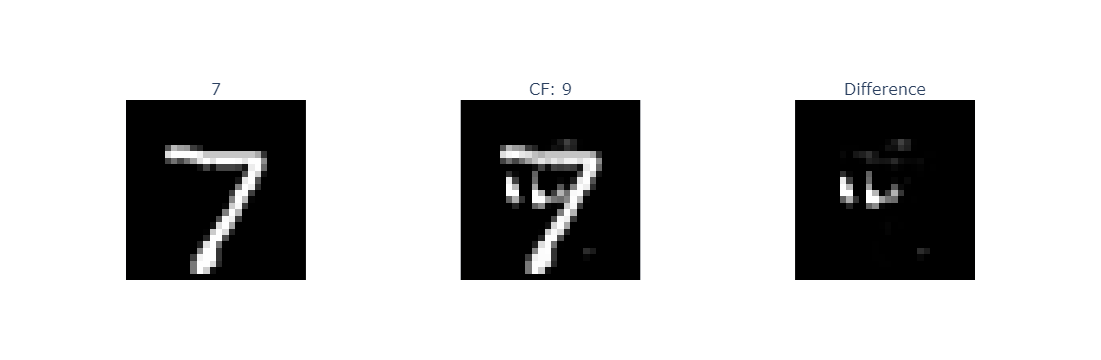

In [173]:
explanations_b.ipython_plot(index=0)

In [151]:
preprocess = lambda ims: torch.stack([transform(im.to_pil()) for im in ims])
cli_p = client_updates_list_nw[1]['4'][0]
cli_p_mdl = get_mdl_from_weights(cli_p)
explainer_p = CounterfactualExplainer(
    model=cli_p_mdl,
    preprocess_function=preprocess
)

In [152]:
explanations_p = explainer_p.explain(x_test[0:5])

Binary step: 5 |███████████████████████████████████████-| 99.0% 

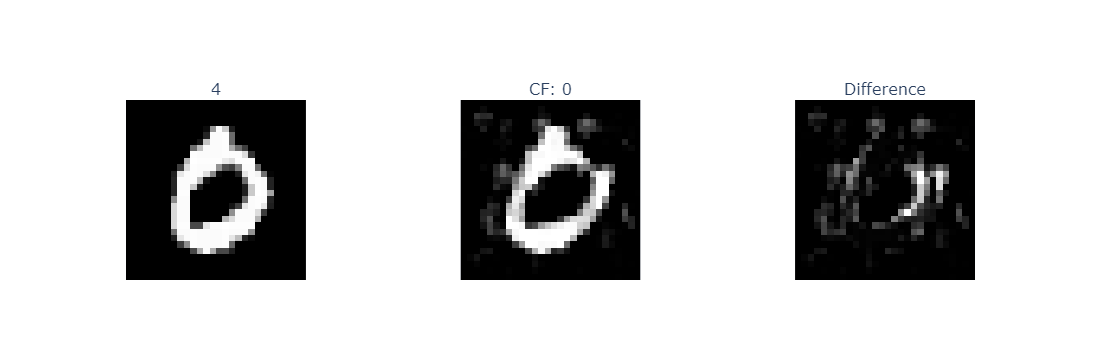

In [153]:
explanations_p.ipython_plot(index=3)

Binary step: 5 |███████████████████████████████████████-| 99.0% 

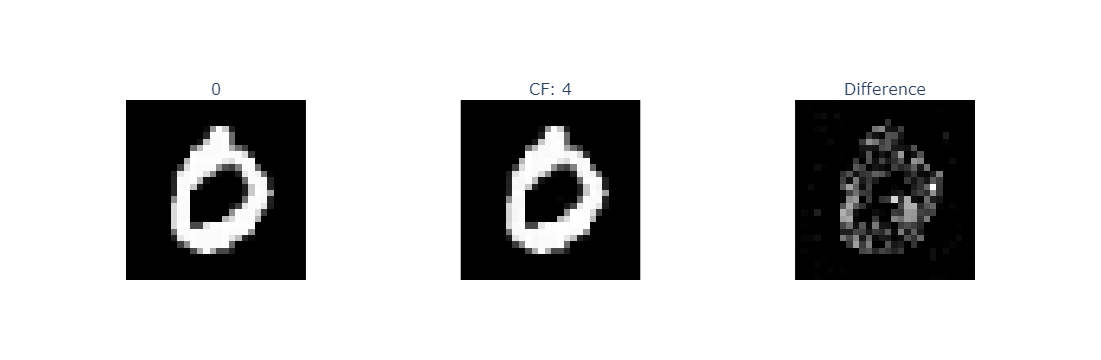

In [145]:
preprocess = lambda ims: torch.stack([transform(im.to_pil()) for im in ims])
cli_p = client_updates_list_nw[0]['1'][0]
cli_p_mdl = get_mdl_from_weights(cli_p)
explainer_p = CounterfactualExplainer(
    model=cli_p_mdl,
    preprocess_function=preprocess
)
explanations_p = explainer_p.explain(x_test[0:5])
explanations_p.ipython_plot(index=3)

Binary step: 5 |███████████████████████████████████████-| 99.0% 

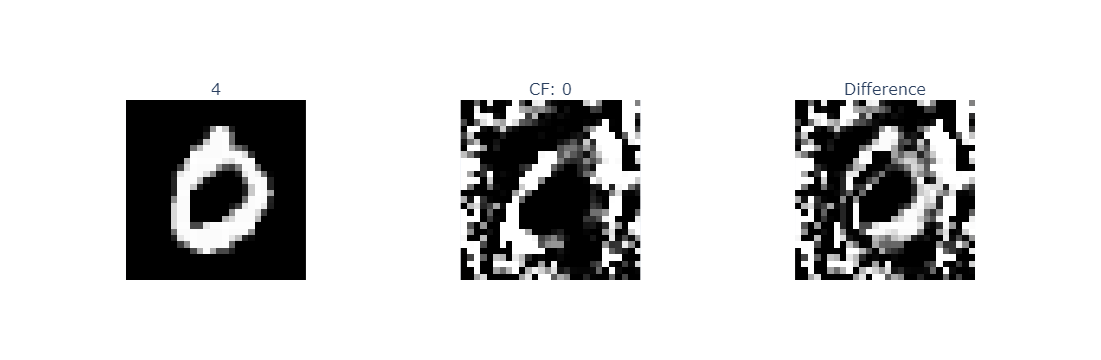

In [147]:
preprocess = lambda ims: torch.stack([transform(im.to_pil()) for im in ims])
cli_p = client_updates_list_nw[0]['3'][0]
cli_p_mdl = get_mdl_from_weights(cli_p)
explainer_p = CounterfactualExplainer(
    model=cli_p_mdl,
    preprocess_function=preprocess
)
explanations_p = explainer_p.explain(x_test[0:5])
explanations_p.ipython_plot(index=3)

### Hidden trigger attacks simulation

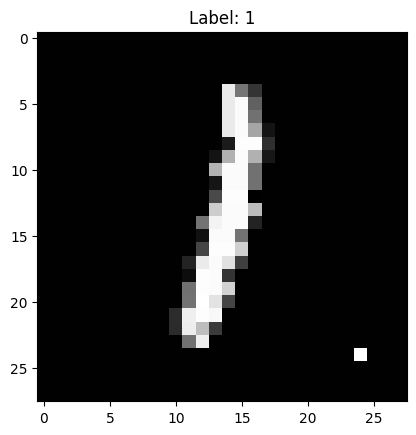

In [246]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

class PoisonedMNISTDataset(Dataset):
    def __init__(self, dataset, trigger_position=(24, 24), trigger_size=1, target_label=1):
        self.dataset = dataset
        self.trigger_position = trigger_position
        self.trigger_size = trigger_size
        self.target_label = target_label

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]

        # If the label matches the target label, apply the trigger
        if label == self.target_label:
            img = self.add_trigger(img)

        return img, label

    def add_trigger(self, img):
        # Convert the tensor to a numpy array for manipulation
        img_np = img.squeeze().numpy()  # Shape (28, 28)

        # Define the trigger position and size
        x, y = self.trigger_position
        trigger_end_x = min(x + self.trigger_size, img_np.shape[0])
        trigger_end_y = min(y + self.trigger_size, img_np.shape[1])

        # Add the trigger: a white square in the specified position
        img_np[x:trigger_end_x, y:trigger_end_y] = 1.0  # Use 1.0 for white in normalized range

        # Convert back to a PIL Image (ensure mode 'L' for grayscale)
        img_with_trigger = Image.fromarray((img_np * 255).astype(np.uint8), mode="L")  # Convert to 0-255 range
        
        # Convert back to tensor
        img_with_trigger_tensor = transforms.ToTensor()(img_with_trigger)
        
        return img_with_trigger_tensor

# Load the MNIST dataset with the ToTensor transform
transform = transforms.ToTensor()
# mnist_train = MNIST(root='./data', train=True, download=True, transform=transform)

# Wrap the MNIST dataset with our PoisonedMNISTDataset
# poisoned_dataset = PoisonedMNISTDataset(dataset=mnist_train)
poisoned_dataset = PoisonedMNISTDataset(dataset=trainloaders[1].dataset)

# Create the DataLoader with the poisoned dataset
poisoned_loader = DataLoader(poisoned_dataset, batch_size=64, shuffle=True)

# Example: Visualize one poisoned image
for images, labels in poisoned_loader:
    for i in range(len(images)):
        if labels[i] == 1:
            poisoned_image = images[i].squeeze().numpy()  # Extract one poisoned image
            plt.imshow(poisoned_image, cmap='gray')
            plt.title(f"Label: {labels[i].item()}")
            plt.show()
            break
    break  # Only need to display one image, so break after first batch


In [255]:
# poisoned_loader.dataset[0]

In [256]:
# Example: Visualize one poisoned image
for images, labels in trainloaders[0]:
    for i in range(len(images)):
        
        if labels[i] == 1:
            poisoned_image = images[i].squeeze().numpy()  # Extract one poisoned image
            plt.imshow(poisoned_image, cmap='gray')
            plt.title(f"Label: {labels[i].item()}")
            plt.show()
            # break
            
    break  # Only need to display one image, so break after first batch

TypeError: 'int' object is not subscriptable

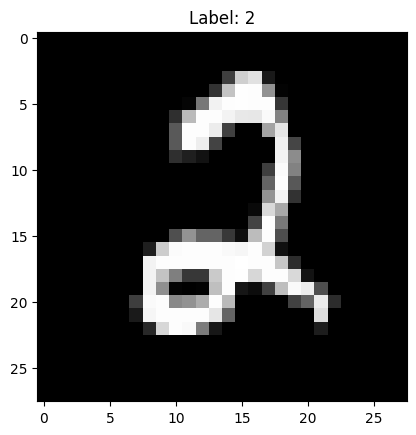

In [227]:
# Example: Visualize one poisoned image
for images, labels in poisoned_loader:
    for i in range(len(images)):
        
        if labels[i] == 2:
            poisoned_image = images[i].squeeze().numpy()  # Extract one poisoned image
            plt.imshow(poisoned_image, cmap='gray')
            plt.title(f"Label: {labels[i].item()}")
            plt.show()
            break
            
    break  # Only need to display one image, so break after first batch

In [257]:
kwargs_train = {'poison_type': 'target_poison', 'poison_ratio': 0.5, 'target_label': 4, 'target_clients': [i for i in range(0)]}
# kwargs_train = {'poison_type': 'random_poison', 'poison_ratio': 1, 'target_clients': [1,2,3]}
kwargs_val = {'poison_type': 'random_poison', 'poison_ratio': 0, 'target_clients': []}
trainloaders, valloaders, testloaders = dataLoaderFactory.generate_data_loaders(kwargs_train, kwargs_val,
                          strategy=poison_strategy_with_non_iid_split,
                          len_train_data=10000, len_test_data=1000,
                          random_ratio=1, is_visualize=False,
                          visualize_idx=0)

10000
generating train set
processing client:  0
no poisoning for client:  0
processing client:  1
no poisoning for client:  1
processing client:  2
no poisoning for client:  2
processing client:  3
no poisoning for client:  3
processing client:  4
no poisoning for client:  4
processing client:  5
no poisoning for client:  5
processing client:  6
no poisoning for client:  6
processing client:  7
no poisoning for client:  7
processing client:  8
no poisoning for client:  8
processing client:  9
no poisoning for client:  9
generating validation set
processing client:  0
no poisoning for client:  0
processing client:  1
no poisoning for client:  1
processing client:  2
no poisoning for client:  2
processing client:  3
no poisoning for client:  3
processing client:  4
no poisoning for client:  4
processing client:  5
no poisoning for client:  5
processing client:  6
no poisoning for client:  6
processing client:  7
no poisoning for client:  7
processing client:  8
no poisoning for client: 

In [248]:
## applying poisoned update for the dataloaders
for i in range(5):
    trainloaders[i] = PoisonedMNISTDataset(dataset=trainloaders[i].dataset)

In [251]:
# Example: Visualize one poisoned image
for images, labels in trainloaders[0].dataset:
    for i in range(len(images)):
        
        if labels[i] == 1:
            poisoned_image = images[i].squeeze().numpy()  # Extract one poisoned image
            plt.imshow(poisoned_image, cmap='gray')
            plt.title(f"Label: {labels[i].item()}")
            plt.show()
            break
            
    break  # Only need to display one image, so break after first batch

TypeError: 'int' object is not subscriptable

In [249]:
client_updates_list_nw = []
aggregated_updates_list = []
results = []
weight_results = []
eliminated_client_list = []
eliminated_client_ids = []
debug_info = []

# should update these value based on the dataset: total_labels_per_client, target_label
kwargs_poison = {'client_ids': ['0', '1', '2', '3', '4'],
                        'explainer_type': 'grad_exp', 'total_rounds': 1, 'sample_count_for_plot': 20,
                        'target_label': 1, 'is_pca': False, 'num_pca_features': 80,
                        'round_idx': 0, 'start_feature_idx': 0, 'total_labels_per_client': 2,
                        'min_cluster_size': 2, 'perplexity': 10,
                        'show_poison_detection_graphs': True, 'malicious_start_idx': 10, 'malicious_end_idx': 40, 'epsilon':0.0,
                        'debug_info': debug_info,'is_eliminating_clients':False}

# kwargs_poison_NSL_KDD = {'client_ids': ['0', '1', '2', '3', '4'],
#                         'explainer_type': 'grad_exp', 'total_rounds': 1, 'sample_count_for_plot': 3,
#                         'target_label': 1, 'is_pca': False, 'num_pca_features': 80,
#                         'round_idx': 0, 'start_feature_idx': 0, 'total_labels_per_client': 2,
#                         'min_cluster_size': 2, 'perplexity': 19,
#                         'show_poison_detection_graphs': False, 'malicious_start_idx': 2, 'malicious_end_idx': 8,
#                         'debug_info': debug_info,'is_eliminating_clients':True}

strategy = CustomFedAvg(
    fraction_fit=1.0,
    evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
    client_updates_list=client_updates_list_nw,
    aggregated_updates_list=aggregated_updates_list,
    results_all=results,
    # client_analysis_strategy_fn=client_analysis_fn_general_alg,
    strategy_kwargs=kwargs_poison,
    eliminated_client_list=eliminated_client_list,
    eliminated_client_ids=eliminated_client_ids,
    weight_results=weight_results
)

client_resources = None
if constants.DEVICE == "cuda":
    # 10 client can run concurrently on a single GPU, but only if you have 10 CPU threads. 
    client_resources = {"num_cpus": 1, "num_gpus": 0.2}

# Start simulation
sim = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=constants.NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=3),
    strategy=strategy,
    client_resources=client_resources,
    ray_init_args={"log_to_driver": False, "num_cpus": 10, "num_gpus": 1}
)

INFO flwr 2024-08-21 00:07:11,789 | app.py:175 | Starting Flower simulation, config: ServerConfig(num_rounds=3, round_timeout=None)
08/21/2024 00:07:11:INFO:Starting Flower simulation, config: ServerConfig(num_rounds=3, round_timeout=None)
2024-08-21 00:07:16,732	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
INFO flwr 2024-08-21 00:07:17,788 | app.py:210 | Flower VCE: Ray initialized with resources: {'node:193.1.133.164': 1.0, 'node:__internal_head__': 1.0, 'CPU': 10.0, 'object_store_memory': 30081141964.0, 'memory': 60189331252.0, 'GPU': 1.0}
08/21/2024 00:07:17:INFO:Flower VCE: Ray initialized with resources: {'node:193.1.133.164': 1.0, 'node:__internal_head__': 1.0, 'CPU': 10.0, 'object_store_memory': 30081141964.0, 'memory': 60189331252.0, 'GPU': 1.0}
INFO flwr 2024-08-21 00:07:17,791 | app.py:224 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.2}
08/21/2024 00:07:17:INFO:Flower VCE: Resources for ea

Attempting to initialize parameters


INFO flwr 2024-08-21 00:07:26,396 | server.py:280 | Received initial parameters from one random client
08/21/2024 00:07:26:INFO:Received initial parameters from one random client
INFO flwr 2024-08-21 00:07:26,398 | server.py:91 | Evaluating initial parameters
08/21/2024 00:07:26:INFO:Evaluating initial parameters
INFO flwr 2024-08-21 00:07:26,400 | server.py:104 | FL starting
08/21/2024 00:07:26:INFO:FL starting
DEBUG flwr 2024-08-21 00:07:26,402 | server.py:222 | fit_round 1: strategy sampled 10 clients (out of 10)
08/21/2024 00:07:26:DEBUG:fit_round 1: strategy sampled 10 clients (out of 10)
ERROR flwr 2024-08-21 00:07:32,650 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/chamara/anaconda3/envs/1-poisoning-xai/lib/python3.11/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ch

No fit_metrics_aggregation_fn provided
Time taken: 0.07650542259216309 seconds


DEBUG flwr 2024-08-21 00:07:40,494 | server.py:187 | evaluate_round 1 received 10 results and 0 failures
08/21/2024 00:07:40:DEBUG:evaluate_round 1 received 10 results and 0 failures
DEBUG flwr 2024-08-21 00:07:40,496 | server.py:222 | fit_round 2: strategy sampled 10 clients (out of 10)
08/21/2024 00:07:40:DEBUG:fit_round 2: strategy sampled 10 clients (out of 10)
ERROR flwr 2024-08-21 00:07:41,483 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/chamara/anaconda3/envs/1-poisoning-xai/lib/python3.11/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/chamara/anaconda3/envs/1-poisoning-xai/lib/python3.11/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File 

Time taken: 0.07623577117919922 seconds


DEBUG flwr 2024-08-21 00:07:46,717 | server.py:187 | evaluate_round 2 received 10 results and 0 failures
08/21/2024 00:07:46:DEBUG:evaluate_round 2 received 10 results and 0 failures
DEBUG flwr 2024-08-21 00:07:46,720 | server.py:222 | fit_round 3: strategy sampled 10 clients (out of 10)
08/21/2024 00:07:46:DEBUG:fit_round 3: strategy sampled 10 clients (out of 10)
ERROR flwr 2024-08-21 00:07:47,839 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/home/chamara/anaconda3/envs/1-poisoning-xai/lib/python3.11/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/chamara/anaconda3/envs/1-poisoning-xai/lib/python3.11/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File 

Time taken: 0.06804394721984863 seconds


DEBUG flwr 2024-08-21 00:07:53,340 | server.py:187 | evaluate_round 3 received 10 results and 0 failures
08/21/2024 00:07:53:DEBUG:evaluate_round 3 received 10 results and 0 failures
INFO flwr 2024-08-21 00:07:53,342 | server.py:153 | FL finished in 26.940472053945996
08/21/2024 00:07:53:INFO:FL finished in 26.940472053945996
INFO flwr 2024-08-21 00:07:53,345 | app.py:225 | app_fit: losses_distributed [(1, 0.015531189095228912), (2, 0.00889555776398629), (3, 0.005803064908483066)]
08/21/2024 00:07:53:INFO:app_fit: losses_distributed [(1, 0.015531189095228912), (2, 0.00889555776398629), (3, 0.005803064908483066)]
INFO flwr 2024-08-21 00:07:53,347 | app.py:226 | app_fit: metrics_distributed_fit {}
08/21/2024 00:07:53:INFO:app_fit: metrics_distributed_fit {}
INFO flwr 2024-08-21 00:07:53,348 | app.py:227 | app_fit: metrics_distributed {'accuracy': [(1, 0.8969999999999999), (2, 0.9369999999999999), (3, 0.959)]}
08/21/2024 00:07:53:INFO:app_fit: metrics_distributed {'accuracy': [(1, 0.89699